<font color='#5a9bd4'>**Proyecto Telecom X - Etapa 2 - Machine Learning**</font>
---

# <font color='#5a9bd4'>**Previsión de Evasión (Churn) de clientes.**</font>

## <font color='#b0b0b0'>**Índice**</font>

1. Descripción del proyecto
2. Importación de librerías y configuraciones
   - Importación de librerías
   - Paths
   - Configuraciones
   - Funciones
4. Preprocesamiento de datos
   - Encoding de variables categóricas
   - Normalización de datos
   - Correlación entre variables
   - Análisis de multicolinealidad
   - Análisis dirigido
5. Modelado de datos
   - Train/Test split
   - Balance del dataset
   - Baseline Model - Decision Tree Classifier
   - Random Forest Classifier
   - Logistic Regression
   - K-Nearest Neighbors
   - XGBoost Classifier
   - Support Vector Machine
7. Evaluación Best Models
   - Métricas Generales
   - Subajuste (Underfitting) y Sobreajuste (Overfitting)
   - Matrices de confusión
   - Importancias y Coeficientes
8. Champion Model
9. Pipeline de prueba en entorno productivo
   - Generación de datos artificiales
   - Pipeline de prueba

# <font color='#5a9bd4'>**1. Descripción del proyecto**</font>

Con el objetivo de anticiparse al problema de cancelación identificado en la etapa anterior, en este notebook se desarrollará un pipeline sólido para la fase inicial de modelado. Este proceso incluirá las siguientes tareas:

* Preparación de los datos para el modelado, incluyendo tratamiento, codificación y normalización.

* Análisis de correlación y selección de variables relevantes.

* Entrenamiento de distintos modelos de clasificación, evaluación de su desempeño mediante diversas métricas, e interpretación de sus resultados.

* Elaboración de un informe con una conclusión estratégica que identifique los principales factores que influyen en la cancelación de clientes.



# <font color='#5a9bd4'>**2. Importación de librerías y configuraciones**</font>

## <font color='#ebac3a'>**Importación de librerías**</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [2]:
import matplotlib
import sklearn

In [3]:
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==1.26.4
pandas==2.2.2
matplotlib==3.10.0
seaborn==0.13.2
scikit-learn==1.5.2
imblearn==1.5.2
xgboost==2.1.3


## <font color='#ebac3a'>**Paths**</font>

In [ ]:
PROJECT_PATH = 'C:/Users/Ivesqui/JupyterScripts/ONE/challenge_telecomX_parte_2'

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
IMG_PATH = PROJECT_PATH / img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports


champion = Path('champion')
CHAMPION_PATH = PROJECT_PATH / champion

champion_preduction = Path('production')
champion_monitor = Path('monitor')

PRODUCTION_PATH = CHAMPION_PATH / 'log' / champion_preduction
MONITOR_PATH = CHAMPION_PATH / 'log' / champion_monitor

dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH, CHAMPION_PATH, PRODUCTION_PATH, MONITOR_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directoryo creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

## <font color='#ebac3a'>**Configuraciones**</font>

### Paleta de Colores del Proyecto

**Azules**  
<span style="display:inline-block; width:20px; height:20px; background:#4682b4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#5a9bd4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#2e6eab; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#1f4e79; margin-right:5px;"></span>

**Naranjas**  
<span style="display:inline-block; width:20px; height:20px; background:#e9611d; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#f07c3e; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#cc4e0f; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#a53d0c; margin-right:5px;"></span>

**Púrpuras**  
<span style="display:inline-block; width:20px; height:20px; background:#6a3fa0; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#8b5fc4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#4f2d84; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#381c66; margin-right:5px;"></span>

**Cremas / Mostazas**  
<span style="display:inline-block; width:20px; height:20px; background:#ebac3a; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#d99a2e; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#c48824; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#b0771b; margin-right:5px;"></span>


**Grises**  
<span style="display:inline-block; width:20px; height:20px; background:#4d4d4d; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#7a7a7a; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#b0b0b0; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#dcdcdc; margin-right:5px;"></span>


In [5]:
# Estandarización de colores
sns.set_palette('colorblind')
churn_colors = ['#4682b4', '#e9611d']

In [6]:
# Colores del proyecto
AZUL_1, AZUL_2, AZUL_3, AZUL_4 = '#4682b4', '#5a9bd4', '#2e6eab', '#1f4e79'
NARANJA_1, NARANJA_2, NARANJA_3, NARANJA_4 = '#e9611d', '#f07c3e', '#cc4e0f', '#a53d0c'
PURPURA_1, PURPURA_2, PURPURA_3, PURPURA_4 = '#6a3fa0', '#8b5fc4', '#4f2d84', '#381c66'
CREMA_1, CREMA_2, CREMA_3, CREMA_4 = '#ebac3a', '#d99a2e', '#c48824', '#b0771b'
GRIS_1, GRIS_2, GRIS_3, GRIS_4 = '#4d4d4d', '#7a7a7a','#b0b0b0','#dcdcdc'

In [7]:
# Definir los colores personalizados
custom_colors = [
    '#4682b4', '#5a9bd4', '#2e6eab', '#1f4e79',  # Azules
    '#6a3fa0', '#8b5fc4', '#4f2d84', '#381c66',  # Púrpuras
    '#ebac3a', '#d99a2e', '#c48824', '#b0771b',  # Cremas
    '#e9611d', '#f07c3e', '#cc4e0f', '#a53d0c',  # Naranjas
]

# Crear el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

## <font color='#ebac3a'>**Funciones**</font>

In [ ]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):
    
    """    
   Generar y guardar un gráfico de tipo boxplot que muestre la distribución de una variable numérica 
   (ycol) segmentada según la condición de churn de los clientes.
    --------------------------------------------------------------------------------------------------
    Parámetros
    
        df : pd.DataFrame
            DataFrame que contiene los datos a graficar. Debe incluir las columnas 'Churn' y `ycol`.
            
        ycol : str
            Nombre de la columna numérica cuya distribución se desea visualizar.
            
        ylabel : str, opcional
            Etiqueta personalizada para el eje Y. Si no se especifica, se usa `ycol`.
            
        title_translate : str, opcional
            Nombre personalizado para mostrar en el título del gráfico. Si no se especifica, se usa `ycol`.
    --------------------------------------------------------------------------------------------------
    Guardado:

        Guarda el gráfico como imagen PNG en la ruta `IMG_PATH` con el nombre `boxplot_Churn_<ycol>.png`.
    --------------------------------------------------------------------------------------------------
    Returns:
    
        fig: matplotlib.figure.Figure
            Objeto de figura de Matplotlib con los gráficos generados.
    
    """

    if ylabel is None:
        ylabel = ycol
    if title_translate is None:
        title_translate = ycol
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax = sns.boxplot(data=df, x='Churn', y=ycol, hue='Churn', palette=churn_colors)
    plt.title(f'Distribución de {title_translate} según\nEvasión (Churn) de clientes', fontsize=18, pad=20)
    plt.xlabel('Churn', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.grid(True)
    
    fig.savefig(IMG_PATH /f'boxplot_Churn_{ycol}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    plt.show()
    return fig

In [9]:
def metricas_evaluacion(modelo, 
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       conjunto: str,
                       umbral: float=None):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
    
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
            
        x_test: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para evaluar el modelo
            
        y_test:
            Pandas Series con las etiquetas reales de los datos utilizados para evaluar el modelo
            
        nombre: str
            Nombre que identificará el modelo para comparaciones
            
        conjunto: str
            Nombre del conjunto de datos utilizados para entrenar y evaluar el modelo
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo, dataset utilizado y metricas: Accuracy, Precision, Recall, F1-score
    """
    
    if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Dataset'] = conjunto
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50
    else:
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Dataset'] = conjunto
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueEror('El modelo no cuenta con el método "predict_proba"')
    
    return metricas

In [10]:
def cv_score_interval(results, 
                      nombre: str, 
                      score:str='Recall'):
    """
    Calcula e imprime el intervalo de confianza del 95% para una métrica de evaluación,
    a partir de los resultados de validación cruzada.

    Este análisis ayuda a entender la variabilidad del desempeño del modelo y 
    en qué rango se espera que se encuentre la métrica seleccionada (ej. recall, precisión, F1).
    ------------------------------------------------------------------------------------------
    Parámetros:
    
        results : dict o DataFrame-like
            Resultados obtenidos mediante cross_validate(), conteniendo la clave 'test_score'
            con los valores de la métrica evaluada en cada pliegue.
    
        nombre : str
            Nombre del modelo evaluado, utilizado para mostrarlo en los mensajes impresos.
    
        score : str - Default: Recall
            Nombre de la métrica evaluada (ej. 'Recall', 'F1-score'), utilizado con fines descriptivos.
    ------------------------------------------------------------------------------------------
    Returns:
    
        Imprime en pantalla el promedio, la desviación estándar y el intervalo
        de confianza del 95% para la métrica especificada.

    """
    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)
    
    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

In [11]:
def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame, 
                  y: pd.core.series.Series, 
                  name: str,
                  save: str,
                  save_path: Path=IMG_PATH,
                  umbral: float=None):

    """
    Función que grafíca la matriz de confusión de un modelo y guarda la figura en el Path indicado
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        model: Modelo sklearn
            Modelo de clasificación binaria que cuente con el método .predict()
            
        x: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas
            
        y: pandas.core.series.Series
            Serie con el vector de etiquetas verdaderas (variable respuesta)
            
        name: str
            Nombre del modelo para el título de la figura
            
        save: str
            Nombre para guardar la figura como confmat_{nombre}.png
            
        save_path: Path
            Ruta donde debe guardarse la figura
    ---------------------------------------------------------------------------------------------
    Returns:
        Figura con matriz de confusion obtenida por el modelo seleccionado
    """
    
    if umbral == None:
        y_pred = model.predict(x)
    else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int) 
        
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    
    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)
    
    fig.savefig(save_path / f'confmat_{save}.png',
                transparent=True,
                dpi=300,
                bbox_inches=None)

In [12]:
def plot_umbrales(modelo,
                  score: str,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  caja_x: float,
                  caja_y: float,
                  nombre: str):
    """
    Función que genera gráfico para determinar el mejor umbral de decisión según F1-score
    ----------------------------------------------------------------------------------------------
    Parámetros:
    
        modelo: Scikit-learn model
            Para que la función trabaje correctamente debe contar con el método predict_proba
            
        score: str
            Toma solo valores: 'F1-score', 'Recall' y 'Precision'. Determina la métrica sobre la cual se quieren evaluar
            los umbrales de decisión.
            
        x: pandas.core.frames.DataFrame
            DataFrame con el conjunto de variables explicativas para realizar predicciones
            
        y: pandas.core.series.Series
            Serie con las etiquetas correspondientes a cada observación.
            
        caja_x:
            Valor para desplazar hacia la derecha la caja de texto con el valor del mejor umbral (usar valor negativo para 
            desplazar a la izquierda)
            
        caja_y:
            Valor para desplazar hacia abajo la caja de texto con el valor del mejor umbral (usar valor negativo para
            desplazar hacia arriba)
            
        nombre:
            Nombre del modelo sobre el cual se está calculando el umbral (SuperTitle)
    ----------------------------------------------------------------------------------------------
    Returns:
        Gráfico matpltolib con curva de umbrales de decisión y punto óptimo según F1-Score.
    """
    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []
    if hasattr(modelo, 'predict_proba'):    
        modelo_pred_proba = modelo.predict_proba(x)[:, 1]
    else:
        raise ValueError('El modelo no cuenta con el método predict_proba')
    for t in umbrales:        
        y_pred = (modelo_pred_proba >= t).astype(int)
        scores.append(f1_score(y, y_pred))
    
    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')
    
    plt.plot(umbrales, scores, label='F1-Score', color=AZUL_1)
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)
    
    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color=CREMA_1, zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return fig

In [13]:
def plot_precision_recall_curve(modelo,
                                x: pd.core.frame.DataFrame,
                                y: pd.core.series.Series,
                                nombre:str):
    """
    Grafica la curva Precision vs Recall para un modelo binario.

    Esta visualización permite analizar el trade-off entre la Precisión y el Recall 
    a medida que varía el umbral de decisión. Es especialmente útil en contextos de 
    clases desbalanceadas.
    --------------------------------------------------------------------------------
    Parámetros:     
        modelo: estimador de sklearn
            Modelo entrenado con un método predict_proba implementado.
            
        x: pandas.core.frame.DataFrame
            Conjunto de variables independientes para la predicción.
            
        y: pandas.core.series.Series
            Valores reales (observados) de la variable objetivo.
            
        nombre: str
            Nombre que se le dará a la curva en la leyenda del gráfico.
    --------------------------------------------------------------------------------
    Returns:
        Muestra un gráfico matplotlib con la curva Precision vs Recall.
    """
    y_pred = modelo.predict_proba(x)[:, 1]
    
    # Calcular precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    
    # Graficar la curva
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color=AZUL_1, label='Baseline Model')
    plt.title(f'{nombre}: Curva Precision-Recall', fontsize=18, fontweight='bold')
    plt.xlabel('Recall', fontsize=13)
    plt.ylabel('Precision', fontsize=13)

    plt.grid(True, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

In [14]:
def plot_analisis_variables(df: pd.core.frame.DataFrame, 
                            analisis: str,
                            nombre_modelo: str, 
                            save: str,
                            n_vars: int= None,
                            save_path: Path=IMG_PATH,
                            space: float=0.5):
    """
    Funcion que permite visualizar Importancias o Coeficientes de modelos, guardando la figura en la ruta correspondiente.
    -----------------------------------------------------------------------------------
    Parámetros:
        df: pandas.core.frame.DataFrame
            DataFrame con las variables del modelo y sus importancias o coeficientes.
            
        analisis: str
            Acepta solo 'Importancia' o 'Coeficiente' para determinar qué analizar.
            
        nombre_modelo: str
            Nombre que aparecerá en el título del gráfico.
            
        save: str
            Nombre que se utilizará para guardar el gráfico con: "{analisis}_variables_{save}.png"
            
        n_vars: int
            Cantidad de variables que se desean analizar. Para análisis de coeficientes toma (n_vars / 2) para head y tail.
            
        save_path: Path
            Ruta para guardar el gráfico. Default IMG_PATH
    -----------------------------------------------------------------------------------
    Returns:
        Gráfico de barras horizontales con Importancia o Coeficientes de variables determinadas por modelo.
    """
    
    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Esta función acepta solo los valores "Importancia" o "Coeficiente" para el parámetro <analisis>') 
        
    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df2 = df.tail(n_vars)
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=custom_cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)

    
    x_max = df[analisis].max()
    x_min = df[analisis].min()
    
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':                
                if width > 0:
                    ax.text(
                        (width + (x_max * space)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * space)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * space)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )
        
    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1) 
    plt.tight_layout()

    fig.savefig(IMG_PATH / f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()

In [15]:
def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6),
                 path: Path=IMG_PATH):
    """
    Función que genera una tabla visual en formato imagen a partir de un DataFrame dado.
    ---------------------------------------------------------------------------------------------------------
    Parámetros:
    
        df: pandas.core.frame.DataFrame
            DataFrame con los datos que se desean visualizar en formato tabular.
            
        title: str
            Título que se mostrará en la parte superior de la tabla.
            
        save: str
            Nombre con el que se guardará la imagen de la tabla como archivo .png.
            
        figsize: Tuple
            Tamaño de la figura (ancho, alto). Default: (8, 6).
            
        path: Path
            Ruta donde se guardará la imagen. Default: IMG_PATH.
    ---------------------------------------------------------------------------------------------------------
    Returns:
        Imagen .png con la tabla renderizada y coloreada, útil para presentaciones ejecutivas o informes.
    """
    
    # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')
    
    colors = [GRIS_3, GRIS_4]
    
    
    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]
    
    cols_names = df.columns        
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()
    
    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=[CREMA_1 for i in range(df.shape[0])],
                     cellColours=cell_colors)
    
    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)
        
    plt.title(f'{title}', fontsize=18, fontweight='bold')
    
    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)
    
    plt.tight_layout()
    
    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')
    
    
    plt.show()

# <font color='#5a9bd4'>**3. Preprocesamiento de datos**</font>

Para el análisis, se incluirán los registros identificados previamente como outliers. En este caso, dichos valores extremos representan comportamientos reales y significativos, como clientes que, a pesar de presentar un gasto acumulado muy elevado, igualmente deciden abandonar la empresa.

In [ ]:
URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

datos = pd.read_json(URL)
datos.head()

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  0002-ORFBO  Female            No     Yes        Yes       9          Yes   
1  0003-MKNFE    Male            No      No         No       9          Yes   
2  0004-TLHLJ    Male            No      No         No       4          Yes   
3  0011-IGKFF    Male           Yes     Yes         No      13          Yes   
4  0013-EXCHZ  Female           Yes     Yes         No       3          Yes   

  MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
0            No             DSL             No  ...         Yes         Yes   
1           Yes             DSL             No  ...          No          No   
2            No     Fiber optic             No  ...          No          No   
3            No     Fiber optic             No  ...          No         Yes   
4            No     Fiber optic             No  ...         Yes         Yes   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No        One year              Yes      Mailed check   
1             Yes  Month-to-month               No      Mailed check   
2              No  Month-to-month              Yes  Electronic check   
3             Yes  Month-to-month              Yes  Electronic check   
4              No  Month-to-month              Yes      Mailed check   

  ChargesDaily ChargesMonthly  ChargesTotal  Churn  
0         2.19           65.6        593.30     No  
1         2.00           59.9        542.40     No  
2         2.46           73.9        280.85    Yes  
3         3.27           98.0       1237.85    Yes  
4         2.80           83.9        267.40    Yes  

[5 rows x 22 columns]

Nota: Se eliminarán las variables CustomerID y ChargesDaily.

CustomerID es un identificador único que no aporta valor predictivo al modelo.

ChargesDaily es una variable derivada directamente de ChargesMonthly al dividirla entre 30, por lo que es redundante y no contribuye con información adicional al análisis.

In [ ]:
try:
    URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [19]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

In [20]:
datos.describe()

Tenure  ChargesMonthly  ChargesTotal
count  7152.000000     7152.000000   7152.000000
mean     32.851370       65.361955   2346.648399
std      24.684639       30.258020   2314.453371
min       0.000000       18.250000      0.000000
25%       9.000000       36.250000    410.837500
50%      30.000000       70.700000   1424.450000
75%      56.000000       90.400000   3949.575000
max      72.000000      118.750000   8684.800000

In [21]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7152 entries, 0 to 7151
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7152 non-null   object 
 1   SeniorCitizen     7152 non-null   object 
 2   Partner           7152 non-null   object 
 3   Dependents        7152 non-null   object 
 4   Tenure            7152 non-null   int64  
 5   PhoneService      7152 non-null   object 
 6   MultipleLines     7152 non-null   object 
 7   InternetService   7152 non-null   object 
 8   OnlineSecurity    7152 non-null   object 
 9   OnlineBackup      7152 non-null   object 
 10  DeviceProtection  7152 non-null   object 
 11  TechSupport       7152 non-null   object 
 12  StreamingTV       7152 non-null   object 
 13  StreamingMovies   7152 non-null   object 
 14  Contract          7152 non-null   object 
 15  PaperlessBilling  7152 non-null   object 
 16  PaymentMethod     7152 non-null   object 


## <font color='#ebac3a'>**Encoding de variables categóricas**</font>

Se conservarán tres conjuntos de datos:

* `df`: contendrá las variables categóricas codificadas con `one_hot_encoder(drop='if_binary')` y variables numéricas sin escalar para modelos robustos a escalas y multicolinealidad.
* `df_scale`: contendrá las variables categóricas codificadas con `one_hot_encoder(drop='if_binary')` y variables numéricas escaladas para modelos robustos a multicolinealidad pero sensibles a escalas de datos.
* `df_linear`: contendrá las variables categóricas codificadas con `one_hot_encoder(drop='first')` y variables numéricas escaladas para modelos sensibles a escalas y multicolinealidad.

In [22]:
datos.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [23]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [24]:
X_linear = X.copy()
y_linear = y.copy()

In [25]:
X

Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
0     Female            No      No         No       1          Yes   
1       Male            No     Yes        Yes      67          Yes   
2     Female            No     Yes         No      60          Yes   
3       Male            No     Yes         No       3           No   
4     Female            No      No         No      63          Yes   
...      ...           ...     ...        ...     ...          ...   
7147    Male            No      No         No      46          Yes   
7148  Female            No      No         No       1          Yes   
7149  Female            No      No         No       4          Yes   
7150    Male            No      No         No       1          Yes   
7151    Male            No     Yes        Yes      52          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0               No              No             No           No   
1               No             DSL            Yes          Yes   
2              Yes     Fiber optic             No          Yes   
3               No             DSL            Yes           No   
4              Yes             DSL            Yes          Yes   
...            ...             ...            ...          ...   
7147            No              No             No           No   
7148            No              No             No           No   
7149           Yes              No             No           No   
7150            No              No             No           No   
7151           Yes              No             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                  No         Yes          No              No        One year   
2                  No          No         Yes             Yes  Month-to-month   
3                  No         Yes          No              No  Month-to-month   
4                 Yes         Yes         Yes              No        Two year   
...               ...         ...         ...             ...             ...   
7147               No          No          No              No        Two year   
7148               No          No          No              No  Month-to-month   
7149               No          No          No              No        One year   
7150               No          No          No              No  Month-to-month   
7151               No          No          No              No        Two year   

     PaperlessBilling            PaymentMethod  ChargesMonthly  ChargesTotal  
0                  No  Credit card (automatic)           19.80         19.80  
1                  No             Mailed check           60.05       3994.05  
2                 Yes         Electronic check           99.80       5985.75  
3                  No             Mailed check           35.10        101.10  
4                 Yes  Credit card (automatic)           79.85       4861.45  
...               ...                      ...             ...           ...  
7147               No         Electronic check           19.95        907.05  
7148               No             Mailed check           19.15         19.15  
7149               No         Electronic check           23.90         97.50  
7150               No             Mailed check           19.55         19.55  
7151               No             Mailed check           24.80       1229.10  

[7152 rows x 19 columns]

In [26]:
categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [27]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

one_hot_linear = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [28]:
X = one_hot.fit_transform(X)
X_linear = one_hot_linear.fit_transform(X_linear)

y = label_encoder.fit_transform(y)
y_linear = label_encoder.fit_transform(y_linear)

In [29]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [30]:
df = pd.DataFrame(X, columns=columnas_encoded)
df_y = pd.DataFrame(y, columns=['Churn'])
df = pd.concat([df, df_y], axis=1)
df.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0          0.0                0.0          0.0             0.0   
1          1.0                0.0          1.0             1.0   
2          0.0                0.0          1.0             0.0   
3          1.0                0.0          1.0             0.0   
4          0.0                0.0          0.0             0.0   

   PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
0               1.0                0.0                  0.0   
1               1.0                0.0                  1.0   
2               1.0                1.0                  0.0   
3               0.0                0.0                  1.0   
4               1.0                1.0                  1.0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  ...  \
0                          0.0                 1.0                 0.0  ...   
1                          0.0                 0.0                 1.0  ...   
2                          1.0                 0.0                 0.0  ...   
3                          0.0                 0.0                 1.0  ...   
4                          0.0                 0.0                 1.0  ...   

   Contract_Two year  PaperlessBilling_Yes  \
0                0.0                   0.0   
1                0.0                   0.0   
2                0.0                   1.0   
3                0.0                   0.0   
4                1.0                   1.0   

   PaymentMethod_Bank transfer (automatic)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    1.0                             0.0   
1                                    0.0                             0.0   
2                                    0.0                             1.0   
3                                    0.0                             0.0   
4                                    1.0                             0.0   

   PaymentMethod_Mailed check  Tenure  ChargesMonthly  ChargesTotal  Churn  
0                         0.0     1.0           19.80         19.80      0  
1                         1.0    67.0           60.05       3994.05      0  
2                         0.0    60.0           99.80       5985.75      0  
3                         1.0     3.0           35.10        101.10      0  
4                         0.0    63.0           79.85       4861.45      0  

[5 rows x 27 columns]

In [31]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [32]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_y_linear = pd.DataFrame(y_linear, columns=['Churn'])
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0          0.0                0.0          0.0             0.0   
1          1.0                0.0          1.0             1.0   
2          0.0                0.0          1.0             0.0   
3          1.0                0.0          1.0             0.0   
4          0.0                0.0          0.0             0.0   

   PhoneService_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
0               1.0                0.0                          0.0   
1               1.0                0.0                          0.0   
2               1.0                1.0                          1.0   
3               0.0                0.0                          0.0   
4               1.0                1.0                          0.0   

   InternetService_No  OnlineSecurity_Yes  OnlineBackup_Yes  ...  \
0                 1.0                 0.0               0.0  ...   
1                 0.0                 1.0               1.0  ...   
2                 0.0                 0.0               1.0  ...   
3                 0.0                 1.0               0.0  ...   
4                 0.0                 1.0               1.0  ...   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                0.0                0.0                   0.0   
1                1.0                0.0                   0.0   
2                0.0                0.0                   1.0   
3                0.0                0.0                   0.0   
4                0.0                1.0                   1.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    1.0                             0.0   
1                                    0.0                             0.0   
2                                    0.0                             1.0   
3                                    0.0                             0.0   
4                                    1.0                             0.0   

   PaymentMethod_Mailed check  Tenure  ChargesMonthly  ChargesTotal  Churn  
0                         0.0     1.0           19.80         19.80      0  
1                         1.0    67.0           60.05       3994.05      0  
2                         0.0    60.0           99.80       5985.75      0  
3                         1.0     3.0           35.10        101.10      0  
4                         0.0    63.0           79.85       4861.45      0  

[5 rows x 24 columns]

### **Nota:**
Se puede observar que la única columna en la cual `1 = No` es `InternetService`. Esto puede resultar confuso debido a quel el resto de variables tienen formato `1 = Yes`, por lo que, para mantener la consistencia semántica del análisis, transformaré el nombre de esta columna de:

`InternetService_No` -> `NoInternetService`


Otro posible acercamiento sería mantener solo las columnas `InternetService_DSL` e `InternetService_Fiberoptic`, ya que la ausencia de ambas, es decir, ambas con **valor = 0** indicaría la presencia de `InternetService_No`. Pero inicialmente mantendré todas las columnas hasta generar y evaluar el modelo base.

In [33]:
df.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df_linear.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)

In [34]:
df_scale = df.copy()

## <font color='#ebac3a'>**Normalización de datos**</font>

Aunque modelos como Random Forest no requieren normalización —ya que no se basan en medidas de distancia, sino en comparaciones del tipo < o >—, se procederá a analizar y normalizar las variables numéricas. Esto se debe a que el objetivo del proyecto es evaluar múltiples algoritmos y seleccionar el de mejor rendimiento para su eventual implementación en producción.

In [35]:
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25) 
    
    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

In [36]:
scaler_tenure = StandardScaler()
scaler_chargesmonthly = StandardScaler()
scaler_chargestotal = StandardScaler()

In [37]:
robust_tenure = RobustScaler()
robust_chargesmonthly = RobustScaler()
robust_chargestotal = RobustScaler()

#### **Tenure**

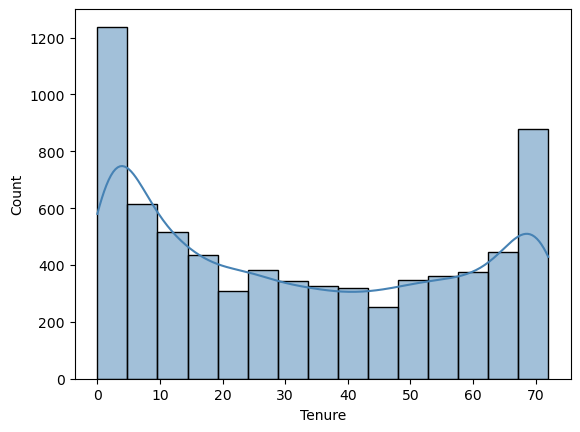

In [38]:
BIN_WIDTH = bin_width(df, 'Tenure')

sns.histplot(df['Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

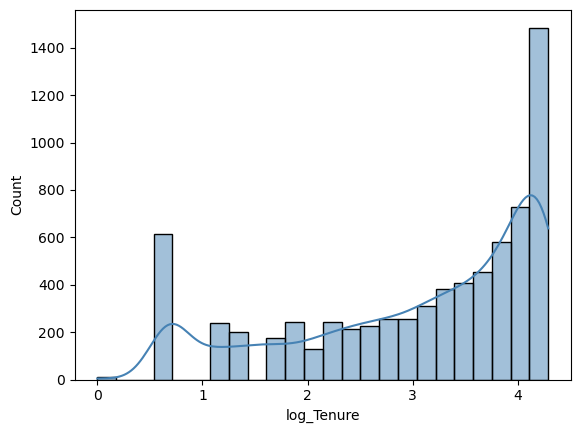

In [39]:
df['log_Tenure'] = np.log(df['Tenure'] + 1)
BIN_WIDTH = bin_width(df, 'log_Tenure')

sns.histplot(df['log_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

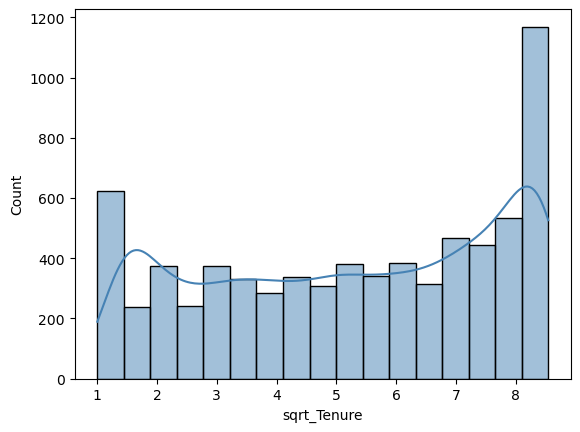

In [40]:
df['sqrt_Tenure'] = np.sqrt(df['Tenure'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_Tenure')

sns.histplot(df['sqrt_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

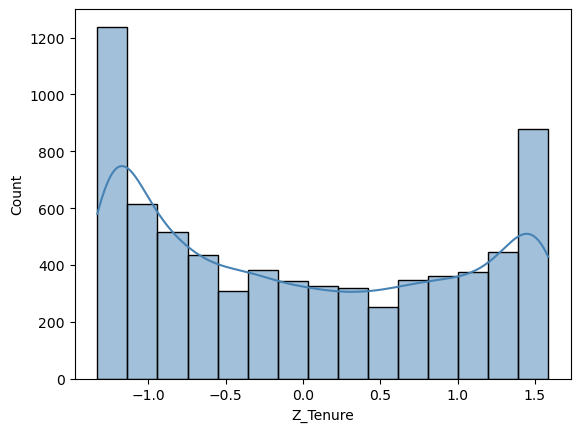

In [41]:
df['Z_Tenure'] = scaler_tenure.fit_transform(df[['Tenure']])
BIN_WIDTH = bin_width(df, 'Z_Tenure')

sns.histplot(df['Z_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

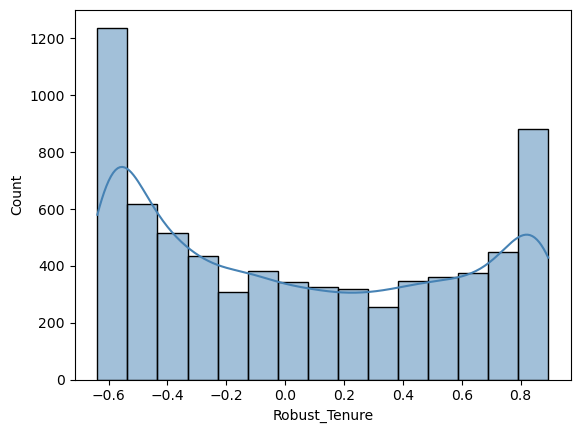

In [42]:
df['Robust_Tenure'] = robust_tenure.fit_transform(df[['Tenure']])
BIN_WIDTH = bin_width(df, 'Robust_Tenure')

sns.histplot(df['Robust_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

#### **ChargesMonthly**

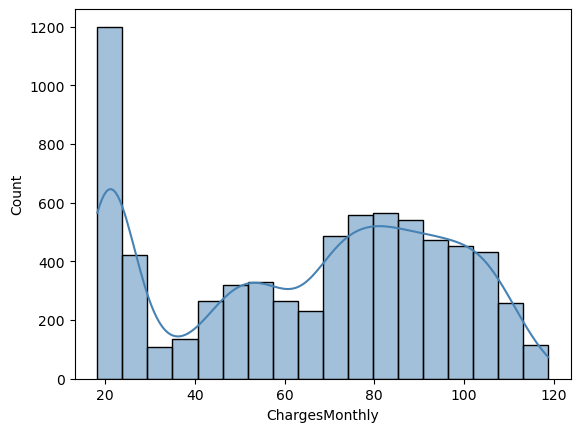

In [43]:
BIN_WIDTH = bin_width(df, 'ChargesMonthly')

sns.histplot(df['ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

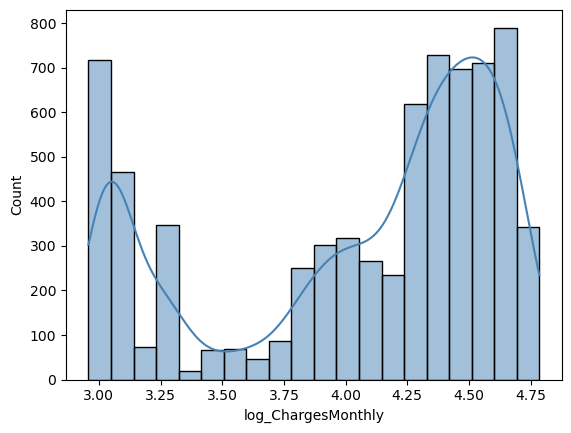

In [44]:
df['log_ChargesMonthly'] = np.log(df['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df, 'log_ChargesMonthly')

sns.histplot(df['log_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

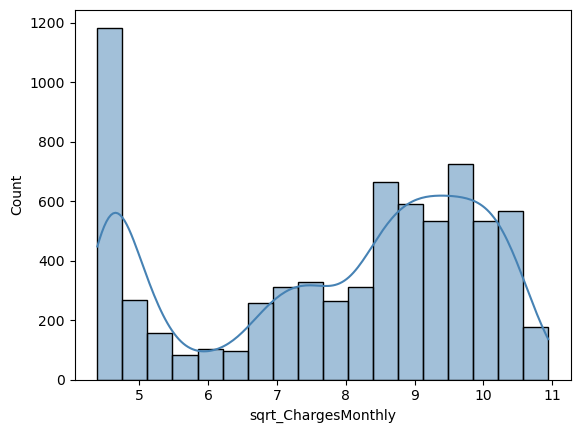

In [45]:
df['sqrt_ChargesMonthly'] = np.sqrt(df['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_ChargesMonthly')

sns.histplot(df['sqrt_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

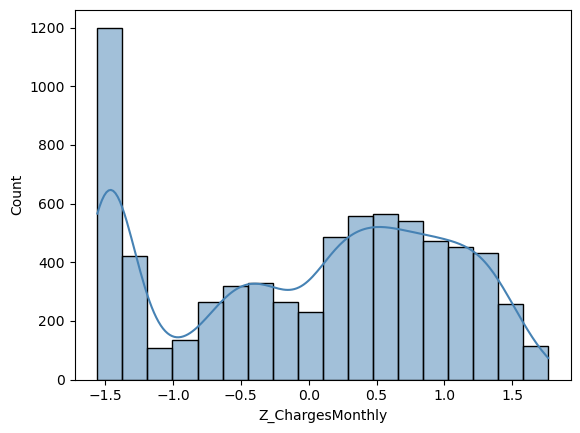

In [46]:
df['Z_ChargesMonthly'] = scaler_chargesmonthly.fit_transform(df[['ChargesMonthly']])
BIN_WIDTH = bin_width(df, 'Z_ChargesMonthly')

sns.histplot(df['Z_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

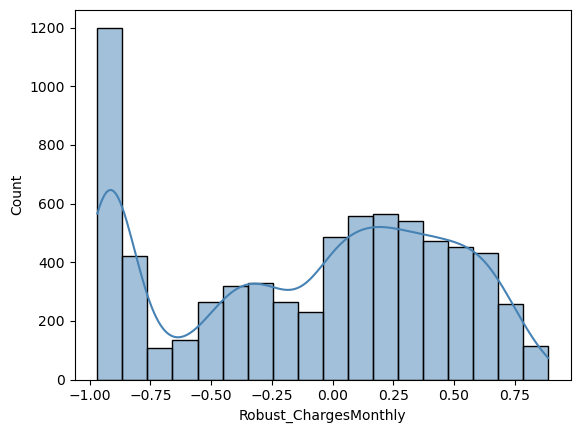

In [47]:
df['Robust_ChargesMonthly'] = robust_chargesmonthly.fit_transform(df[['ChargesMonthly']])
BIN_WIDTH = bin_width(df, 'Robust_ChargesMonthly')

sns.histplot(df['Robust_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

#### **ChargesTotal**

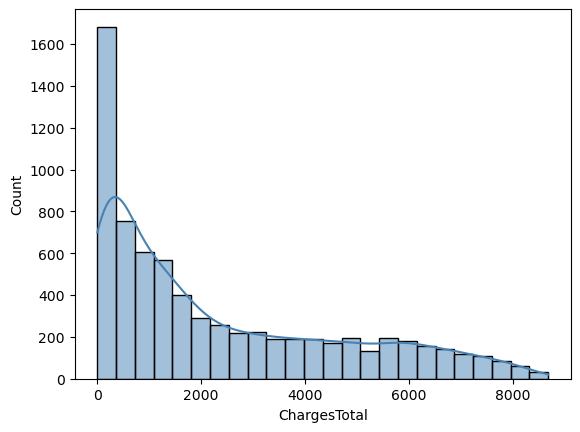

In [48]:
BIN_WIDTH = bin_width(df, 'ChargesTotal')

sns.histplot(df['ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

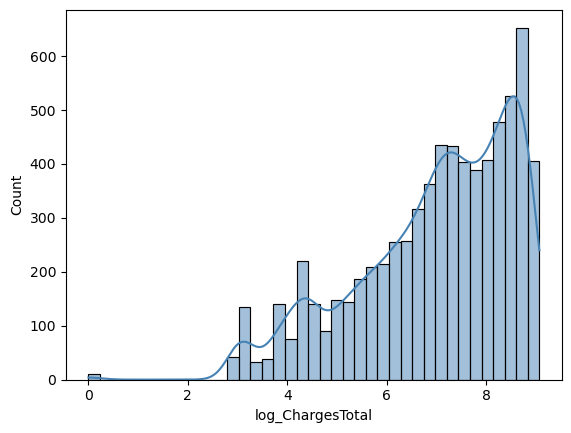

In [49]:
df['log_ChargesTotal'] = np.log(df['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df, 'log_ChargesTotal')

sns.histplot(df['log_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

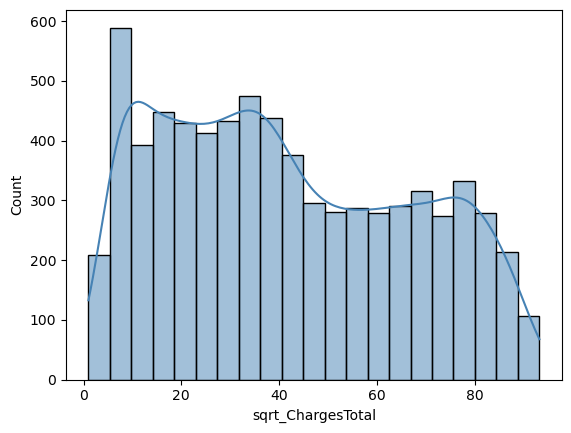

In [50]:
df['sqrt_ChargesTotal'] = np.sqrt(df['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df, 'sqrt_ChargesTotal')

sns.histplot(df['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

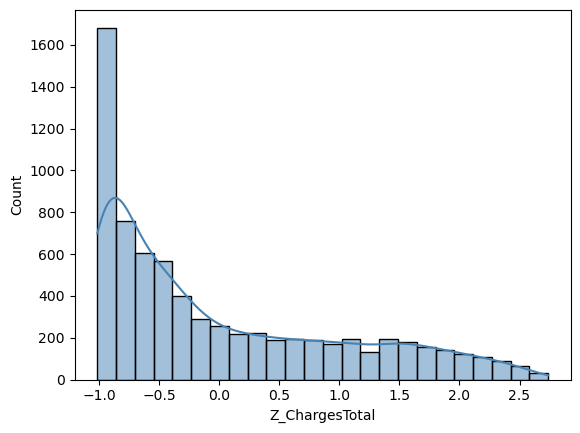

In [51]:
df['Z_ChargesTotal'] = scaler_chargestotal.fit_transform(df[['ChargesTotal']])
BIN_WIDTH = bin_width(df, 'Z_ChargesTotal')

sns.histplot(df['Z_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

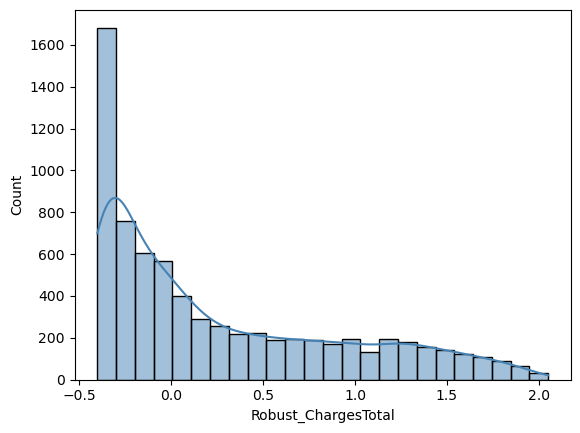

In [52]:
df['Robust_ChargesTotal'] = robust_chargestotal.fit_transform(df[['ChargesTotal']])
BIN_WIDTH = bin_width(df, 'Robust_ChargesTotal')

sns.histplot(df['Robust_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

### <font color='#8b5fc4'>**Observaciones: Normalización de datos**</font>

Se observa que ninguna de las transformaciones aplicadas logra corregir la asimetría positiva de la variable ChargesTotal. Esto es consistente con su naturaleza acumulativa, ya que este tipo de variables tiende a concentrar la mayoría de observaciones en valores bajos, presentando valores altos únicamente en un subconjunto específico de clientes.

Además, se han incluido los registros previamente identificados como outliers —clientes de alto valor que decidieron abandonar la empresa—, ya que resulta crucial identificar qué características comparten con los clientes de menor valor. Este análisis permitirá detectar áreas críticas de mejora para reducir la tasa de evasión (churn).

Por otro lado, las variables Tenure y ChargesMonthly presentan una distribución bimodal que se mantiene constante a lo largo de las distintas transformaciones aplicadas.

Dado lo anterior, se optará por conservar las variables cuantitativas en su forma original y evaluar si los modelos pueden procesarlas adecuadamente. En caso de que su rendimiento se vea afectado, se aplicará RobustScaler, una técnica que reduce la escala sin alterar la distribución original, ideal para algoritmos sensibles a las magnitudes de los datos.

In [53]:
df = df.drop(['log_Tenure', 'sqrt_Tenure', 'Z_Tenure', 'Robust_Tenure',
              'log_ChargesMonthly', 'sqrt_ChargesMonthly', 'Z_ChargesMonthly', 'Robust_ChargesMonthly',
              'log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal', 'Robust_ChargesTotal'], axis=1)

In [54]:
df.shape

(7152, 27)

## <font color='#ebac3a'>**Correlación entre variables**</font>

In [55]:
corr = df.corr()

In [56]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

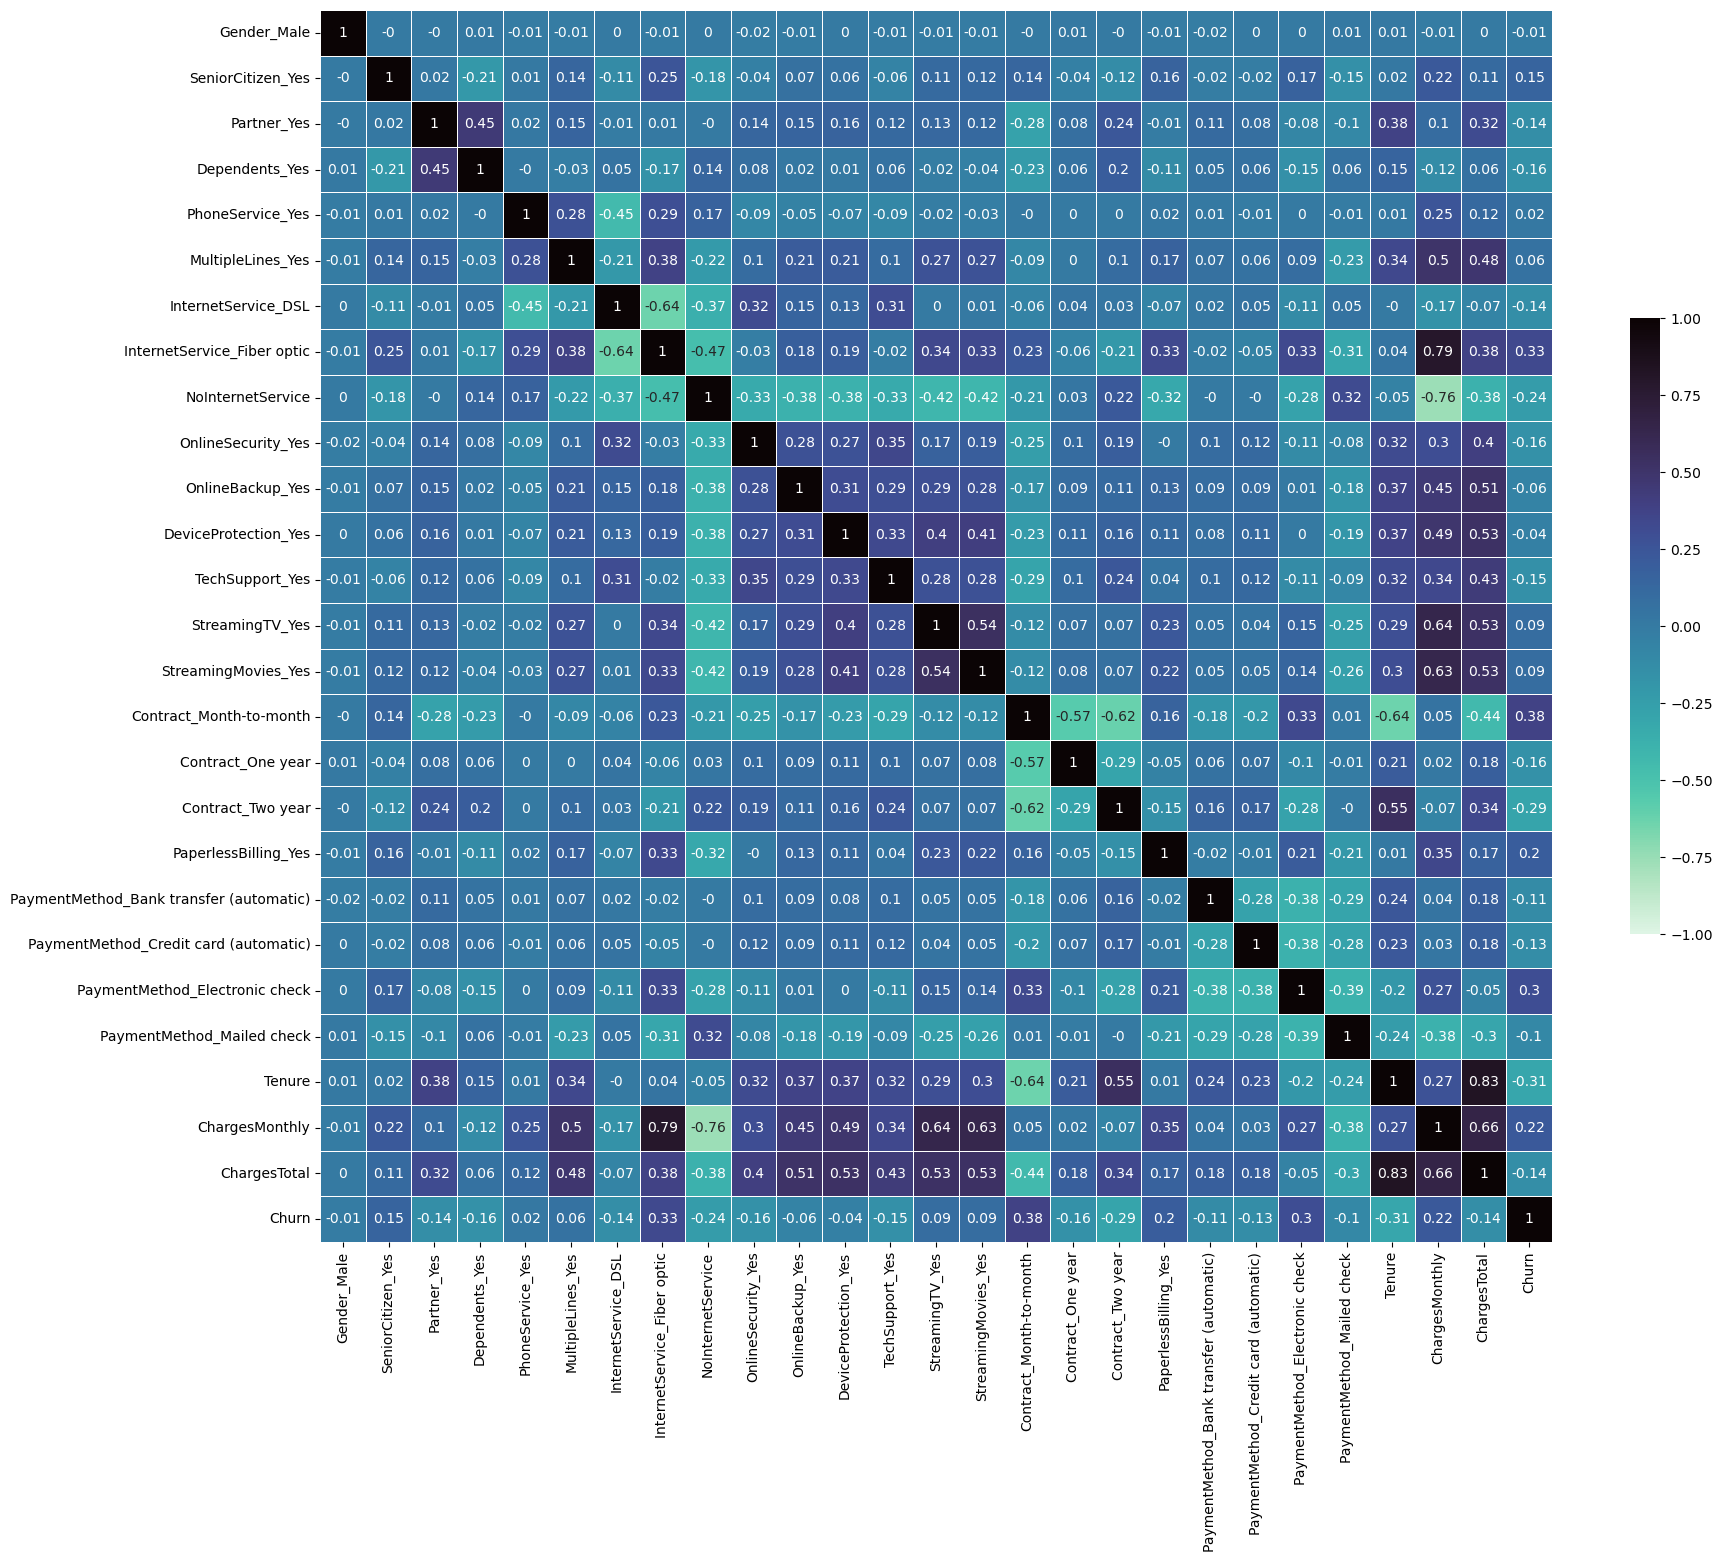

In [57]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

### ***Nota:***

Debido a que existe una cantidad considerable de variables, para una mejor visualización selecionaré aquellas que tiene una correlación absoluta con la Evasión mayor a 0.07

In [58]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo

In [59]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

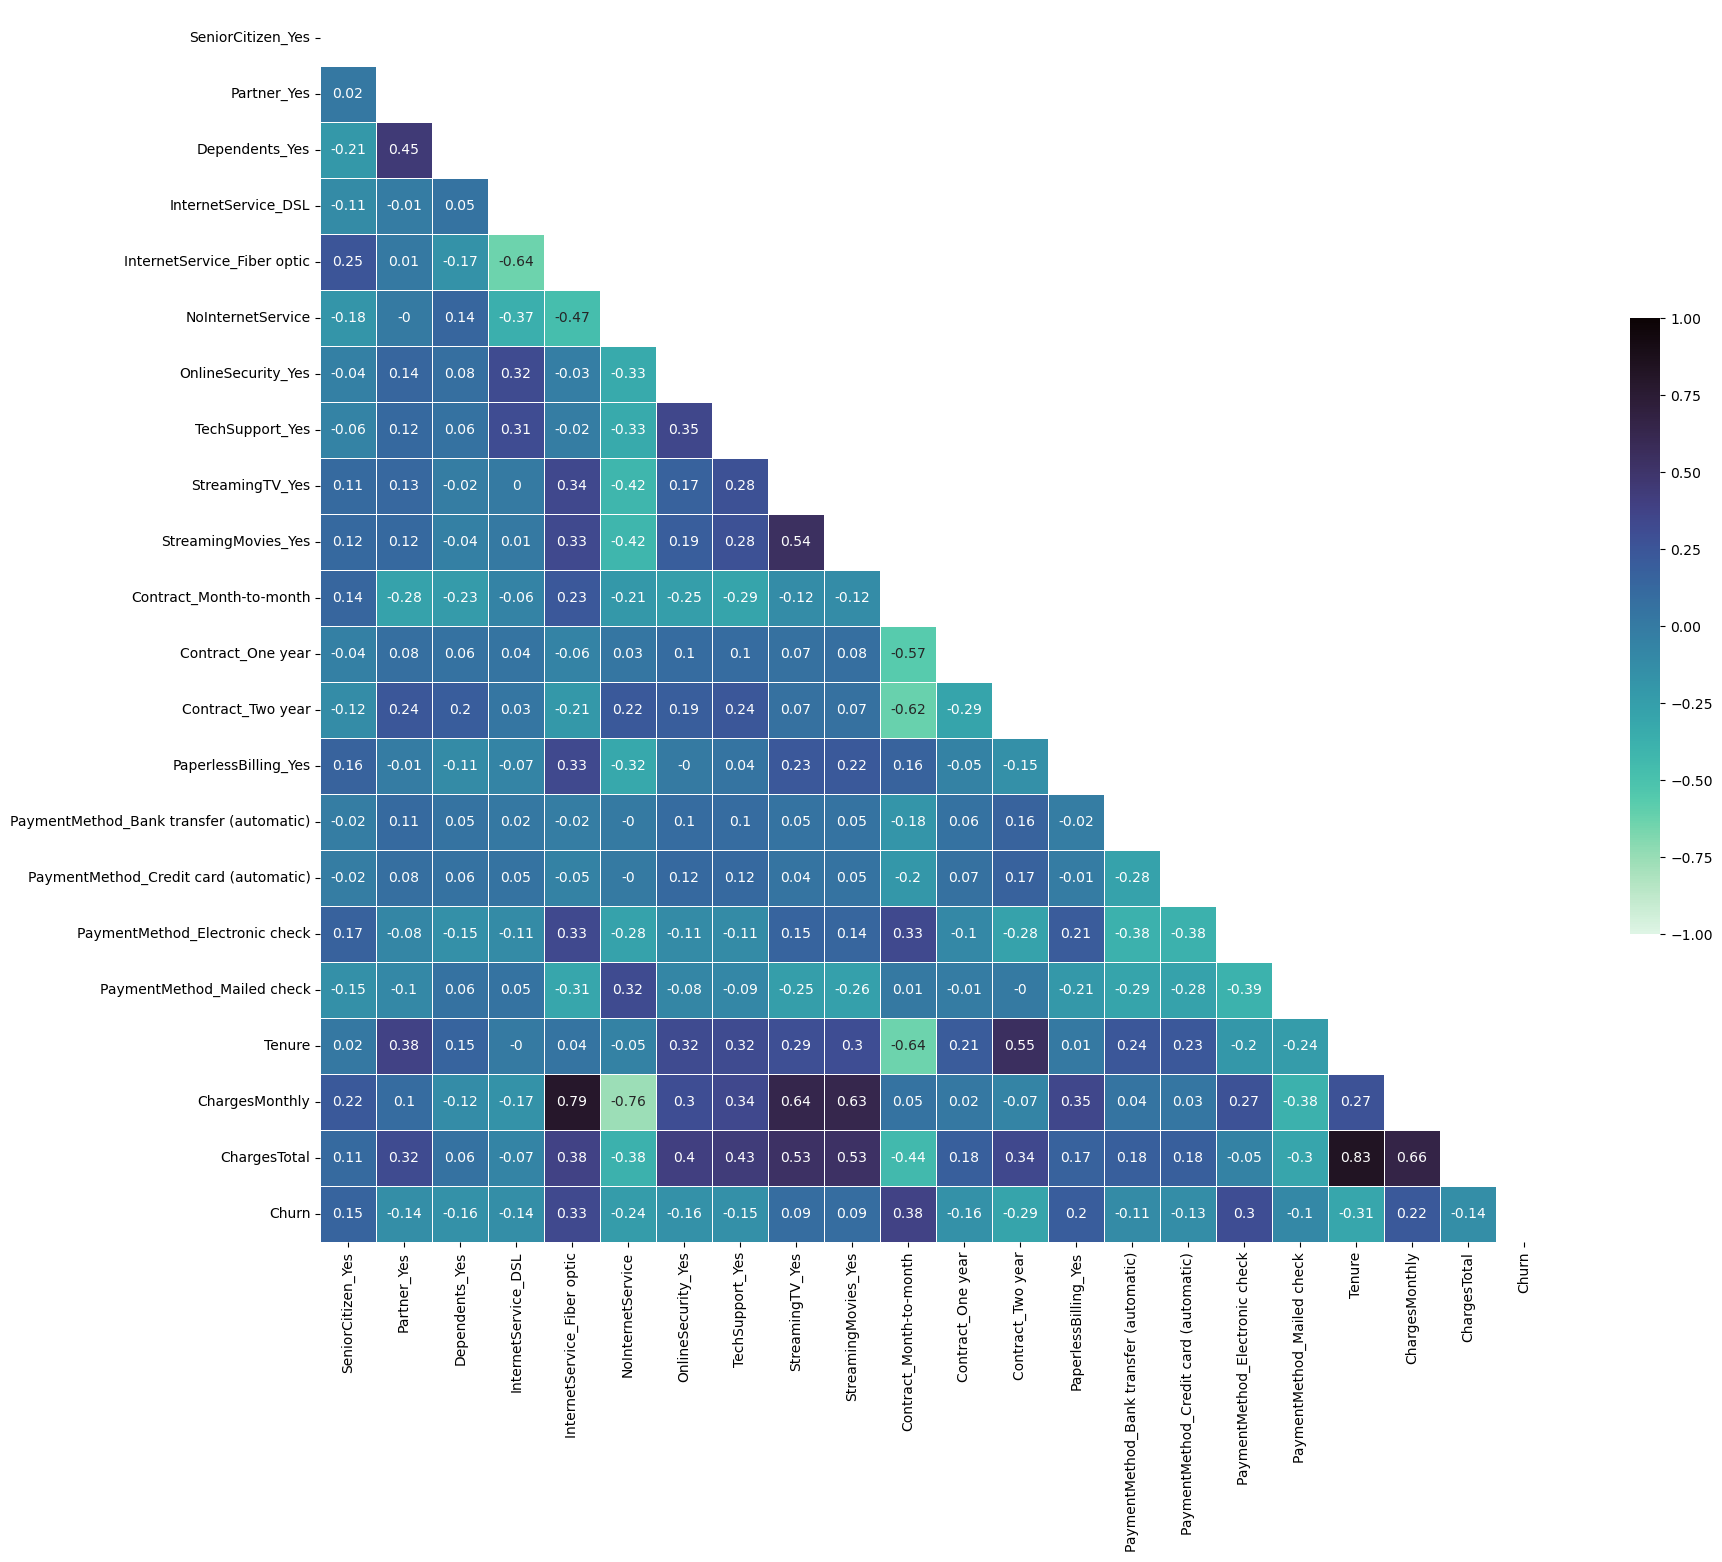

In [60]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
fig.savefig(IMG_PATH / 'corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Particularmente destaca una fuerte relación positiva entre `ChargesTotal` y `Tenure`. Esto probablemente se debe a la naturaleza acumulativa de `ChargesTotal`, por lo que, es posible que esta variable sea ya explicada entre `Tenure` y ChargesMonthly. Para verificar este fenómeno, se llevará a cabo un análisis de colinealidad, a través de **Variance Inflation Factor**.

## <font color='#ebac3a'>**Análisis de multicolinealidad**</font>

### <font color='#f07c3e'>**VIF 1**</font>

Variance Inflation Factor, en esencia, realiza una regresión lineal tomando cada variable explicativa como variable respuesta, y busca explicarla a través del resto de variables explicativas. Los valores aceptables suelen ser:

* 1 < VIF < 5 = **Aceptable**
* 5 < VIF < 10 = **La variable puede conservarse si se considera necesario**
* 10 < VIF = **Existe colinealidad fuerte entre dicha variable y alguna de las otras variables explicativas**

En los casos que exista colinealidad, dichas variables se descartan para no perjudicar al modelo.

Se utilizará la variable X_linear que fue codificada con `OneHotEncoder(drop='first')`, esto asegura que se descarte la primera categoría de cada feature al codificar las variables, evitando que se introduzca multicolinealidad manualmente al modelo.

Además, se escalarán las variables numéricas ya que dicho algoritmo, al realizar regresiones lineales, es sensible a la escala de los datos.

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler

In [62]:
vif_robust_scaler = RobustScaler()

In [63]:
df_vif = df_linear.copy()

In [64]:
x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_vif_num = df_vif[x_num]

X_vif_num = vif_robust_scaler.fit_transform(X_vif_num)

df_vif[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_vif_num

df_vif = df_vif.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [65]:
X_vif = df_vif.drop('Churn', axis=1)

In [66]:
features = X_vif.columns

In [67]:
df_vif_1 = pd.DataFrame()
df_vif_1['Feature'] = features
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [68]:
df_vif_1.sort_values('VIF', ascending=False)

Feature        VIF
22                    ChargesTotal_scaled  12.902310
21                  ChargesMonthly_scaled  11.696381
4                        PhoneService_Yes  10.048787
20                          Tenure_scaled   7.750051
6             InternetService_Fiber optic   6.817227
7                       NoInternetService   5.937551
15                      Contract_Two year   3.436684
12                        StreamingTV_Yes   3.055135
13                    StreamingMovies_Yes   3.029339
16                   PaperlessBilling_Yes   2.989310
18         PaymentMethod_Electronic check   2.967135
2                             Partner_Yes   2.846047
5                       MultipleLines_Yes   2.686302
19             PaymentMethod_Mailed check   2.394575
10                   DeviceProtection_Yes   2.322671
9                        OnlineBackup_Yes   2.159550
11                        TechSupport_Yes   2.102665
14                      Contract_One year   2.068524
0                             Gender_Male   2.025449
17  PaymentMethod_Credit card (automatic)   1.989295
3                          Dependents_Yes   1.968012
8                      OnlineSecurity_Yes   1.953893
1                       SeniorCitizen_Yes   1.377374

### <font color='#8b5fc4'>**Observaciones: VIF 1**</font>

Como se observó en el **Análisis de Correlación** de variables, `ChargesTotal` y `ChargesMonthly` son las variables que presentan mayor valor de **VIF**.

|Feature	            |VIF      |
|-----------------------|---------|
|ChargesTotal_scaled	|12.902310|
|ChargesMonthly_scaled  |11.696381|

Como se mencionó anteriormente, ChargesTotal es la acumulación de `ChargesMonthly` a lo largo de la cantidad de meses de `Tenure`. Por lo tanto, se descartará la primera para evaluar el resultado de **Variance Inflation Factor**.

### <font color='#f07c3e'>**VIF 2**</font>

In [69]:
X_vif = df_vif.copy()

In [70]:
X_vif = X_vif.drop(['ChargesTotal_scaled', 'Churn'], axis=1)

In [71]:
features = X_vif.columns
features

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled'],
      dtype='object')

In [72]:
df_vif_2 = pd.DataFrame()
df_vif_2['Feature'] = features
df_vif_2['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [73]:
df_vif_2.sort_values('VIF', ascending=False)

Feature        VIF
21                  ChargesMonthly_scaled  10.568394
4                        PhoneService_Yes  10.015450
6             InternetService_Fiber optic   6.736119
7                       NoInternetService   5.918196
15                      Contract_Two year   3.408953
12                        StreamingTV_Yes   3.017488
16                   PaperlessBilling_Yes   2.989275
13                    StreamingMovies_Yes   2.987107
18         PaymentMethod_Electronic check   2.964332
2                             Partner_Yes   2.845660
20                          Tenure_scaled   2.829294
5                       MultipleLines_Yes   2.668684
19             PaymentMethod_Mailed check   2.368017
10                   DeviceProtection_Yes   2.273198
9                        OnlineBackup_Yes   2.079832
14                      Contract_One year   2.068465
11                        TechSupport_Yes   2.064473
0                             Gender_Male   2.024696
17  PaymentMethod_Credit card (automatic)   1.988759
3                          Dependents_Yes   1.966942
8                      OnlineSecurity_Yes   1.913098
1                       SeniorCitizen_Yes   1.377318

Como se observa en la tabla anterior, al eliminar la variable con mayor VIF (`ChargesTotal_scaled`), el puntaje de VIF de `Tenure_scaled` descendió de **7.7500 a 2.8292**. Esto representa una evidencia empírica de que `ChargesTotal_scaled` estaba fuertemente explicada por las otras dos variables numéricas (`Tenure_scaled` y `ChargesMonthly_scaled`), lo que confirma una fuerte colinealidad entre ellas.

Sin embargo, el VIF de `ChargesMonthly` y `PhoneService_Yes` aún presentan un valor elevado, superando el umbral crítico aunque sea levemente.

Los **modelos lineales**, como `LogisticRegression` (a menos que se use **regularización Lasso**, que penaliza la complejidad del modelo), `LinearRegression`, o `SVM` con `kernel='linear'`, **son sensibles a la multicolinealidad**, ya que esta distorsiona la interpretación de los coeficientes y puede inflar su varianza.

Por el contrario, **modelos no lineales** como `RandomForest`, `XGBoost` o `KNN`, **son mucho más robustos** frente a este fenómeno, e incluso pueden beneficiarse de contar con variables redundantes, ya que su arquitectura puede determinar cuáles resultan más útiles para la clasificación sin sufrir distorsión en los parámetros.

Por esta razón, **se conservarán todas las variables** para los modelos no lineales, y se aplicarán los **tratamientos adecuados** (como la eliminación de variables con VIF elevado o la regularización) **únicamente en los modelos lineales**, con el objetivo de maximizar la interpretabilidad y estabilidad de los mismos.

## <font color='#ebac3a'>**Análisis Dirigido**</font>

### <font color='#f07c3e'>**Monto total de la Evasión (Churn)**</font>

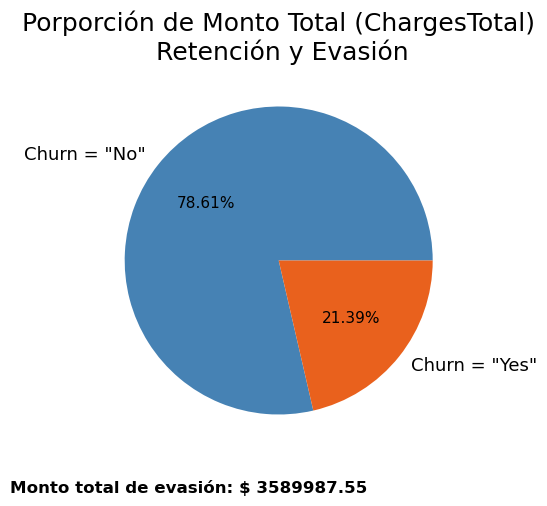

In [74]:
totales = datos.groupby('Churn')['ChargesTotal'].sum().reset_index()
churn_yes = totales[totales['Churn'] == 'Yes']

fig, ax = plt.subplots(figsize=(8,5))

wedges, texts, autotexts = ax.pie(data=totales, 
                                  x='ChargesTotal', 
                                  autopct='%1.2f%%', 
                                  labels=['Churn = "No"', 'Churn = "Yes"'], 
                                  colors=churn_colors,
                                  startangle=0
                                  )
for t in texts:
    t.set_fontsize(13)
for a in autotexts:
    a.set_fontsize(11)

plt.title('Porporción de Monto Total (ChargesTotal)\n Retención y Evasión', fontsize=18)
plt.figtext(0.4, 0.03, f'Monto total de evasión: $ {churn_yes["ChargesTotal"].values[0]}', ha='center', fontsize=12, fontweight='bold')

fig.savefig(IMG_PATH / 'monto_evasion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

### <font color='#f07c3e'>**Evasión (Churn) según Antigüedad (Tenure)**</font>

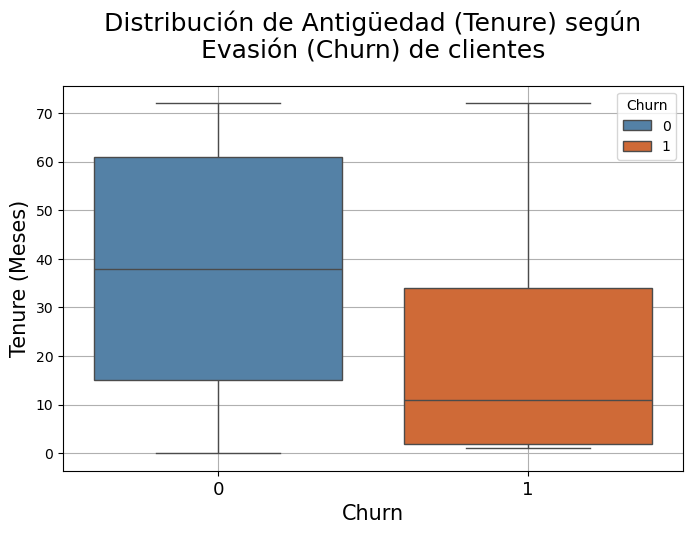

In [75]:
tenure_boxplot = boxplot_churn(df, ycol='Tenure', ylabel='Tenure (Meses)', title_translate='Antigüedad (Tenure)')

In [76]:
df[df['Churn'] == 1].describe()['Tenure']

count    1978.000000
mean       20.508595
std        21.721863
min         1.000000
25%         2.000000
50%        11.000000
75%        34.000000
max        72.000000
Name: Tenure, dtype: float64

### <font color='#8b5fc4'>**Observaciones: Evasión (Churn) según Antigüedad (Tenure)**</font>

Como se pudo observar en la etapa anterior del proyecto, es posible observar la frecuencia de abandono es mayor en las etapas tempranas de la relación del cliente con la empresa, con una **concentración del 50% de abandono** antes del primer año de contrato.

### <font color='#f07c3e'>**Evasión (Churn) según Gasto Total (ChargesTotal)**</font>

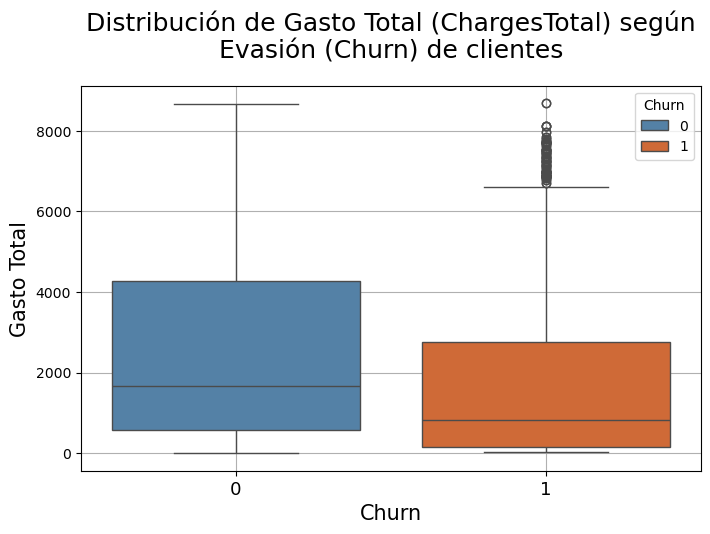

In [77]:
tenure_boxplot = boxplot_churn(df, ycol='ChargesTotal', ylabel='Gasto Total', title_translate='Gasto Total (ChargesTotal)')

### <font color='#8b5fc4'>**Observaciones: Evasión (Churn) según Gasto Total (ChargesTotal)**</font>

Debido a que ChargesTotal es una variable de naturaleza acumulativa, esta fuertemente relacionada con la antigüedad del cliente. Esto se puede observar en el análisis de correlación donde en índice de Pearson entre ambas variables es **0.94**. Esto puede generar redundancia en el modelo, por lo que, se experimentará primero considerando ambas variables, y luego se mantendrá Tenure y ChargesMonthly, ya que la combinación de estas dos variables explican ChargesTotal.

# <font color='#5a9bd4'>**4. Modelado de datos**</font>

## <font color='#ebac3a'>**Train Test Split**</font>

#### **Conjunto X**

In [78]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [79]:
X_cv, X_test, y_cv, y_test = tts(X, y, test_size=0.15, stratify=y, random_state=42)

In [80]:
X_train, X_val, y_train, y_val = tts(X_cv, y_cv, test_size=0.10, stratify=y_cv, random_state=42)

#### **Conjunto X_scale**

In [81]:
X_scale = df_scale.drop('Churn', axis=1)
y_scale = df['Churn']

In [82]:
X_scale_cv, X_scale_test, y_scale_cv, y_scale_test = tts(X_scale, y_scale, test_size=0.15, stratify=y_scale, random_state=42)

In [83]:
X_scale_train, X_scale_val, y_scale_train, y_scale_val = tts(X_scale_cv, y_scale_cv, test_size=0.10, stratify=y_scale_cv, random_state=42)

#### **Conjunto X_linear**

In [84]:
X_linear = df_linear.drop('Churn', axis=1)
y_linear = df['Churn']

In [85]:
X_linear_cv, X_linear_test, y_linear_cv, y_linear_test = tts(X_linear, y_linear, test_size=0.15, stratify=y_linear, random_state=42)

In [86]:
X_linear_train, X_linear_val, y_linear_train, y_linear_val = tts(X_linear_cv, y_linear_cv, test_size=0.10, stratify=y_linear_cv, random_state=42)

## <font color='#ebac3a'>**Escalado de variables numéricas**</font>

In [87]:
var_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']
var_num_scaled = ['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']

#### **Conjunto X_scale**

In [88]:
X_scale_cv

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   
...           ...                ...          ...             ...   
5448          0.0                1.0          0.0             0.0   
5489          1.0                0.0          1.0             1.0   
4194          0.0                1.0          1.0             0.0   
4305          1.0                1.0          0.0             0.0   
1061          0.0                0.0          1.0             1.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
1571               1.0                1.0                  0.0   
3669               1.0                0.0                  1.0   
6327               1.0                0.0                  0.0   
6329               1.0                1.0                  0.0   
6138               1.0                1.0                  0.0   
...                ...                ...                  ...   
5448               0.0                0.0                  1.0   
5489               1.0                1.0                  0.0   
4194               1.0                0.0                  0.0   
4305               0.0                0.0                  1.0   
1061               1.0                1.0                  1.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
1571                          1.0                0.0                 0.0  ...   
3669                          0.0                0.0                 0.0  ...   
6327                          0.0                1.0                 0.0  ...   
6329                          1.0                0.0                 0.0  ...   
6138                          1.0                0.0                 0.0  ...   
...                           ...                ...                 ...  ...   
5448                          0.0                0.0                 0.0  ...   
5489                          1.0                0.0                 1.0  ...   
4194                          1.0                0.0                 0.0  ...   
4305                          0.0                0.0                 0.0  ...   
1061                          0.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
1571                0.0                0.0                   1.0   
3669                0.0                0.0                   1.0   
6327                1.0                0.0                   0.0   
6329                0.0                0.0                   0.0   
6138                0.0                0.0                   1.0   
...                 ...                ...                   ...   
5448                0.0                1.0                   1.0   
5489                0.0                1.0                   0.0   
4194                0.0                0.0                   1.0   
4305                0.0                0.0                   1.0   
1061                0.0                1.0                   0.0   

      PaymentMethod_Bank transfer (automatic)  \
1571                                      0.0   
3669                                      0.0   
6327                                      0.0   
6329                                      0.0   
6138                                      0.0   
...                                       ...   
5448                                      1.0   
5489                                      1.0   
4194                                      0.0   
4305                                      0.0   
1061                                      1.0   

     

In [89]:
robust_scaler = RobustScaler()

# Fit solo en los datos de entrenamiento (X_cv)
robust_scaler.fit(X_scale_cv[var_num])

# Transformar todos los datasets usando el mismo scaler
X_scaled_cv = X_scale_cv.copy()
y_scaled_cv = y_scale_cv.copy()
X_scaled_train = X_scale_train.copy()
y_scaled_train = y_scale_train.copy()
X_scaled_val = X_scale_val.copy()
y_scaled_val = y_scale_val.copy()
X_scaled_test = X_scale_test.copy()
y_scaled_test = y_scale_test.copy()

X_scaled_cv[var_num_scaled] = robust_scaler.transform(X_scale_cv[var_num])
X_scaled_train[var_num_scaled] = robust_scaler.transform(X_scale_train[var_num])
X_scaled_val[var_num_scaled] = robust_scaler.transform(X_scale_val[var_num])
X_scaled_test[var_num_scaled] = robust_scaler.transform(X_scale_test[var_num])

X_scaled_cv.drop(var_num, axis=1, inplace=True)
X_scaled_train.drop(var_num, axis=1, inplace=True)
X_scaled_val.drop(var_num, axis=1, inplace=True)
X_scaled_test.drop(var_num, axis=1, inplace=True)

In [90]:
X_scaled_cv.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
1571               1.0                1.0                  0.0   
3669               1.0                0.0                  1.0   
6327               1.0                0.0                  0.0   
6329               1.0                1.0                  0.0   
6138               1.0                1.0                  0.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
1571                          1.0                0.0                 0.0  ...   
3669                          0.0                0.0                 0.0  ...   
6327                          0.0                1.0                 0.0  ...   
6329                          1.0                0.0                 0.0  ...   
6138                          1.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
1571                0.0                0.0                   1.0   
3669                0.0                0.0                   1.0   
6327                1.0                0.0                   0.0   
6329                0.0                0.0                   0.0   
6138                0.0                0.0                   1.0   

      PaymentMethod_Bank transfer (automatic)  \
1571                                      0.0   
3669                                      0.0   
6327                                      0.0   
6329                                      0.0   
6138                                      0.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1571                                    1.0                             0.0   
3669                                    0.0                             0.0   
6327                                    0.0                             0.0   
6329                                    1.0                             0.0   
6138                                    0.0                             1.0   

      PaymentMethod_Mailed check  Tenure_scaled  ChargesMonthly_scaled  \
1571                         0.0       0.319149               0.339138   
3669                         1.0      -0.617021              -0.383135   
6327                         1.0      -0.319149              -0.937672   
6329                         0.0       0.063830               0.326306   
6138                         0.0      -0.617021               0.549954   

      ChargesTotal_scaled  
1571             0.783087  
3669            -0.387834  
6327            -0.325447  
6329             0.414631  
6138            -0.373445  

[5 rows x 26 columns]

#### **Conjunto X_linear**

In [91]:
robust_scaler_linear = RobustScaler()

X_linear_cv[var_num_scaled] = robust_scaler_linear.fit_transform(X_linear_cv[var_num])
X_linear_train[var_num_scaled] = robust_scaler_linear.transform(X_linear_train[var_num])
X_linear_val[var_num_scaled] = robust_scaler_linear.transform(X_linear_val[var_num])
X_linear_test[var_num_scaled] = robust_scaler_linear.transform(X_linear_test[var_num])

X_linear_cv.drop(var_num, axis=1, inplace=True)
X_linear_train.drop(var_num, axis=1, inplace=True)
X_linear_val.drop(var_num, axis=1, inplace=True)
X_linear_test.drop(var_num, axis=1, inplace=True)

In [92]:
X_linear_cv.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
1571               1.0                1.0                          1.0   
3669               1.0                0.0                          0.0   
6327               1.0                0.0                          0.0   
6329               1.0                1.0                          1.0   
6138               1.0                1.0                          1.0   

      NoInternetService  OnlineSecurity_Yes  OnlineBackup_Yes  ...  \
1571                0.0                 0.0               0.0  ...   
3669                0.0                 0.0               0.0  ...   
6327                1.0                 0.0               0.0  ...   
6329                0.0                 0.0               1.0  ...   
6138                0.0                 0.0               0.0  ...   

      StreamingMovies_Yes  Contract_One year  Contract_Two year  \
1571                  1.0                0.0                0.0   
3669                  0.0                0.0                0.0   
6327                  0.0                1.0                0.0   
6329                  0.0                0.0                0.0   
6138                  1.0                0.0                0.0   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
1571                   1.0                                    1.0   
3669                   1.0                                    0.0   
6327                   0.0                                    0.0   
6329                   0.0                                    1.0   
6138                   1.0                                    0.0   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
1571                             0.0                         0.0   
3669                             0.0                         1.0   
6327                             0.0                         1.0   
6329                             0.0                         0.0   
6138                             1.0                         0.0   

      Tenure_scaled  ChargesMonthly_scaled  ChargesTotal_scaled  
1571       0.319149               0.339138             0.783087  
3669      -0.617021              -0.383135            -0.387834  
6327      -0.319149              -0.937672            -0.325447  
6329       0.063830               0.326306             0.414631  
6138      -0.617021               0.549954            -0.373445  

[5 rows x 23 columns]

## <font color='#ebac3a'>**Balance del dataset**</font>

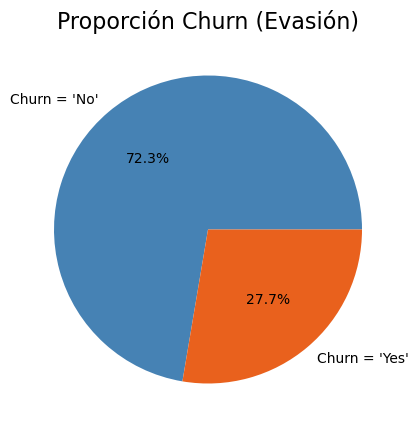

In [93]:
# Visualizar la proporción de registros en relación a la evasión (Churn)
churns = df.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig(IMG_PATH/'pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Como se observa en el gráfico, la distribución de clases está desbalanceada: aproximadamente el **75 % de los registros corresponden a clientes que no han abandonado la empresa (No Churn)**. Esta desproporción puede sesgar al modelo durante el entrenamiento, **dificultando su capacidad para aprender correctamente los patrones asociados al abandono de clientes (Churn)**. Por ello, será necesario aplicar una estrategia de **balanceo en los datos** de entrenamiento.

Es importante destacar que **el balanceo se realiza exclusivamente sobre los datos de entrenamiento**, para evitar el fenómeno conocido como ***Data Leakage***. Balancear también los conjuntos de validación o prueba modificaría artificialmente la distribución original de las clases, lo que podría llevar a obtener métricas de desempeño no confiables o sobreestimadas.

Dado que el objetivo es que el modelo aprenda patrones reales presentes en los datos históricos de la empresa, se optará por una estrategia conservadora: **undersampling de la clase mayoritaria**, utilizando la técnica `NearMiss`. Esta técnica selecciona los ejemplos más relevantes de la clase mayoritaria, conservando los casos más difíciles de clasificar, lo que puede contribuir a mejorar la capacidad del modelo para detectar churn.

Aunque existen técnicas como `SMOTE` que permiten generar nuevas observaciones sintéticas de la clase minoritaria mediante interpolación, estas observaciones no provienen de datos reales. Si bien están respaldadas matemáticamente, podrían inducir patrones artificiales que no se corresponden con la realidad del negocio. Por ello, se prefiere reservar `SMOTE` para situaciones controladas, como la creación de una base balanceada para evaluar modelos en producción, donde se busca analizar cómo se desempeñan frente a una distribución equilibrada.

In [94]:
columnas = df.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [95]:
undersampler = NearMiss(version=3)

#### **Conjunto X**

In [96]:
X_cv, y_cv = undersampler.fit_resample(X_cv,y_cv)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [97]:
y_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [98]:
y_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

#### **Conjunto X_scaled**

In [99]:
X_scaled_cv, y_scaled_cv = undersampler.fit_resample(X_scaled_cv,y_scaled_cv)
X_scaled_train, y_scaled_train = undersampler.fit_resample(X_scaled_train, y_scaled_train)

In [100]:
y_scaled_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [101]:
y_scaled_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

#### **Conjunto X_linear**

In [102]:
X_linear_cv, y_linear_cv = undersampler.fit_resample(X_linear_cv,y_linear_cv)
X_linear_train, y_linear_train = undersampler.fit_resample(X_linear_train, y_linear_train)

In [103]:
y_linear_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [104]:
y_linear_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

In [105]:
X_cv

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0             1.0                0.0          1.0             0.0   
1             1.0                0.0          1.0             0.0   
2             0.0                0.0          1.0             1.0   
3             1.0                0.0          1.0             1.0   
4             0.0                0.0          1.0             0.0   
...           ...                ...          ...             ...   
3357          1.0                0.0          1.0             0.0   
3358          1.0                1.0          0.0             0.0   
3359          1.0                0.0          0.0             0.0   
3360          1.0                1.0          1.0             1.0   
3361          0.0                0.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
0                  1.0                1.0                  0.0   
1                  1.0                1.0                  0.0   
2                  1.0                1.0                  0.0   
3                  1.0                1.0                  0.0   
4                  1.0                1.0                  0.0   
...                ...                ...                  ...   
3357               1.0                1.0                  0.0   
3358               1.0                0.0                  0.0   
3359               1.0                0.0                  0.0   
3360               1.0                1.0                  0.0   
3361               1.0                1.0                  0.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
0                             1.0                0.0                 1.0  ...   
1                             1.0                0.0                 1.0  ...   
2                             1.0                0.0                 1.0  ...   
3                             1.0                0.0                 1.0  ...   
4                             1.0                0.0                 1.0  ...   
...                           ...                ...                 ...  ...   
3357                          1.0                0.0                 0.0  ...   
3358                          1.0                0.0                 0.0  ...   
3359                          1.0                0.0                 0.0  ...   
3360                          1.0                0.0                 1.0  ...   
3361                          1.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                   0.0                1.0                   1.0   
1                   0.0                1.0                   1.0   
2                   0.0                1.0                   0.0   
3                   0.0                1.0                   1.0   
4                   0.0                1.0                   0.0   
...                 ...                ...                   ...   
3357                0.0                0.0                   1.0   
3358                0.0                0.0                   1.0   
3359                0.0                0.0                   1.0   
3360                1.0                0.0                   1.0   
3361                0.0                0.0                   1.0   

      PaymentMethod_Bank transfer (automatic)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         0.0   
...                                       ...   
3357                                      1.0   
3358                                      0.0   
3359                                      0.0   
3360                                      1.0   
3361                                      0.0   

     

## <font color='#ebac3a'>**Baseline model - Decision Tree Classifier**</font>

In [106]:
X_cv.shape

(3362, 26)

In [107]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [108]:
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=42)
baseline_cross_val_results = cross_validate(baseline_model, X_cv, y_cv, cv=skf, scoring='recall')

In [109]:
cv_score_interval(results=baseline_cross_val_results, 
                  nombre='Baseline Model',
                  score='Recall')

Recall promedio de Baseline Model: 0.677
Desviación estándar del Recall de Baseline Model: 0.0472
El Recall de Baseline Model estará entre [0.5826,0.7714] con un 95% de confianza


In [110]:
baseline_model.fit(X_cv, y_cv)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [111]:
baseline_pred = baseline_model.predict(X_test)

In [112]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       776
           1       0.49      0.64      0.55       297

    accuracy                           0.72      1073
   macro avg       0.67      0.69      0.67      1073
weighted avg       0.75      0.72      0.73      1073



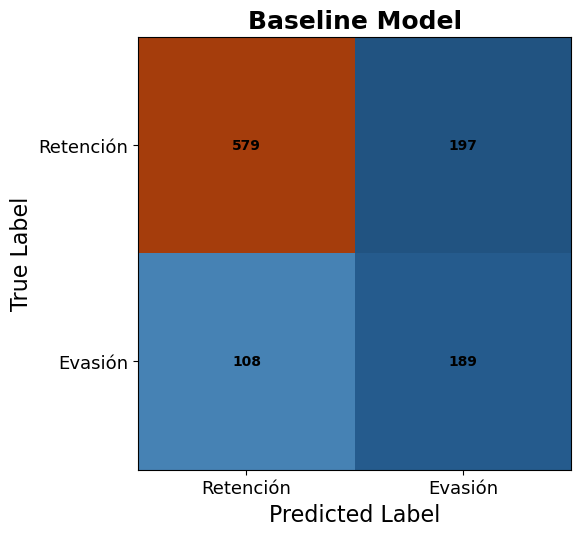

In [113]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

### <font color='#8b5fc4'>**Observaciones Baseline Model: DecisionTreeClassifier - Max Depth = 10**</font>

|              |precision  |  recall|  f1-score |   support|
|--------------|-----------|--------|-----------|----------|
|           0  |   0.84    |  0.75  |    0.79   |    776   |
|           1  |   0.49    |  0.64  |    0.55   |    297   |
|   macro avg  |    0.67   |   0.69 |    0.67   |   1073   |
|--------------|-----------|--------|-----------|----------|
|    accuracy  |           |        |    0.72   |   1073   |


#### **Clase 0 (clientes que no abandonan):**

* **Precisión 0.84:** cuando el modelo predice que un cliente no abandona, **acierta el 84%** de las veces.
* **Recall 0.75:** detecta **correctamente al 75%** de los que realmente **no abandonan**.
* **F1-score 0.79:** buen equilibrio entre precisión y recall.
* **Support: 776** clientes realmente no abandonaron (mayoría).

#### **Clase 1 (clientes que sí abandonan):**

* **Precisión 0.49:** cuando el modelo predice que un cliente abandonará, acierta solo el 49% de las veces (muchos falsos positivos).
* **Recall 0.64:** logra capturar el 64% de los abandonos reale, lo cual es una métrica relativamente aceptable para el modelo base.
* **F1-score 0.55:** balance moderado entre precisión baja y recall decente.
* **Support: 297** clientes realmente abandonaron.


#### **Accuracy: 0.72**

El modelo acierta en el 72% de los casos.
Pero, debido a que las clases estan desbalanceadas, esta métrica puede estar influenciada por la clase mayoritaria (clase 0), es por eso que resulta relevante observar otras métricas para obtener una evaluación confiable del modelo.

In [114]:
baseline_results = metricas_evaluacion(modelo=baseline_model, 
                                       x_test= X_test,
                                       y_test=y_test,
                                       nombre='Baseline Model', 
                                       conjunto='X')

El **modelo base** fue entrenado sin ajuste de hiperparámetros ni técnicas de preprocesamiento avanzadas, con el objetivo de servir como punto de comparación para modelos posteriores.

| Modelo         | Accuracy  |Precision | Recall   | F1-score | AUC    |
|----------------|-----------|----------|----------|----------|--------|
| Baseline Model |  0.7158	 | 0.4896   | 0.6364   | 0.5534   | 0.7418 |

* **Exactitud (Accuracy)** del modelo: **0.7158**
  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

* **Recall (Sensibilidad):** el modelo es capaz de identificar correctamente al **0.6364** de los clientes que efectivamente abandonan:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

* **Precisión (Precision):** el **0.4896** de las veces que el modelo predice que un cliente abandonará, está en lo correcto:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

* **F1-score:** dado que la precisión y la sensibilidad tienen el mismo valor, el F1-score también es **0.5534**:

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

* **AUC (Área bajo la curva ROC)**: el valor obtenido de **0.7418** indica que el modelo tiene una capacidad aceptable para discriminar entre clientes que abandonan y los que no, evaluando su rendimiento a lo largo de todos los umbrales posibles.
Esto significa que si se selecciona aleatoriamente un cliente que abandonó y uno que no, el modelo tiene aproximadamente un 74,18% de probabilidad de asignar una mayor probabilidad de abandono al cliente que efectivamente se fue.

---

**Objetivo**: A partir de este modelo base, se buscará **mejorar principalmente la sensibilidad (Recall)** —clave para detectar clientes en riesgo de abandono—, sin sacrificar excesivamente la precisión, la cual es importante mejorar ya que demasiados errores de Precisión pueden llevar a campañas de retención ineficientes en costos, lo cual se traduce intervenciones innecesarias sobre clientes que continuarían utilizando el servicio.

### <font color='#f07c3e'>**ROC Curve**</font>

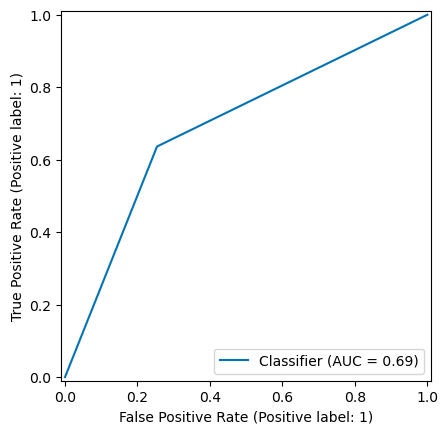

In [115]:
RocCurveDisplay.from_predictions(y_test, baseline_pred);

El **AUC-ROC** se calcula variando el **umbral de decisión sobre la probabilidad de la clase positiva**.

- Al usar `predict_proba(x_test)[:, 1]`, el AUC se evalúa considerando **todos los posibles umbrales (de 0 a 1)**, lo que permite medir adecuadamente el área bajo la curva ROC.
- En cambio, al usar `predict(x_test)`, se evalúa el rendimiento solo en un **único punto** (umbral fijo = 0.5), por lo tanto el cálculo del AUC **pierde resolución y subestima la verdadera capacidad de discriminación del modelo**.

Por eso, en el gráfico se observa un **AUC = 0.69**, mientras que al usar probabilidades se obtiene un valor de **0.7418**. Esta diferencia de casi **5%** sugiere que el modelo podría alcanzar **una mejor performance si se ajusta el umbral de decisión**, en lugar de utilizar el valor por defecto de 0.5.

### <font color='#f07c3e'>**Baseline Model: Umbral de decisión**</font>

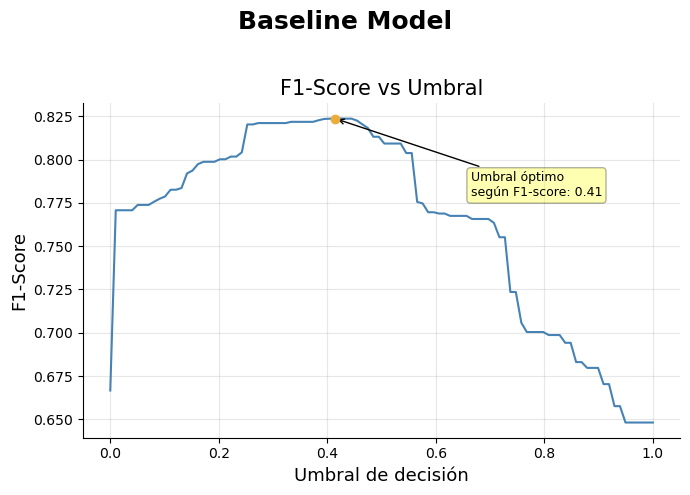

In [116]:
umbral_baseline = plot_umbrales(modelo=baseline_model, 
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='Baseline Model')

### <font color='#8b5fc4'>**Observaciones: Baseline Model - Umbral de decisión**</font>

A partir del análisis del **F1-score** —métrica que balancea *precisión* y *recall*—, se determinó que el mejor desempeño del modelo se alcanza con un umbral de decisión de **0.4**.

Esto significa que todas aquellas observaciones cuya probabilidad de abandono sea **mayor o igual a 0.4** serán clasificadas como positivas (`Churn = 1`).

Este ajuste en el umbral permite mejorar la capacidad del modelo para separar correctamente las clases, y será clave para conservar la versión que logre la mejor discriminación entre clientes que abandonan y los que no.
Se utiliza F1-score, ya que las métricas de *precisión* y *recall* por separado, presentan umbrales extremos (0 y 1), lo cual no aporta información útil para la clasificación.  
Esto reforzó la elección del **F1-score** como métrica principal, ya que proporciona un equilibrio más realista entre ambas medidas y permite identificar un umbral intermedio verdaderamente informativo.

### <font color='#f07c3e'>**Baseline Model: Precision vs Recall Curve**</font>

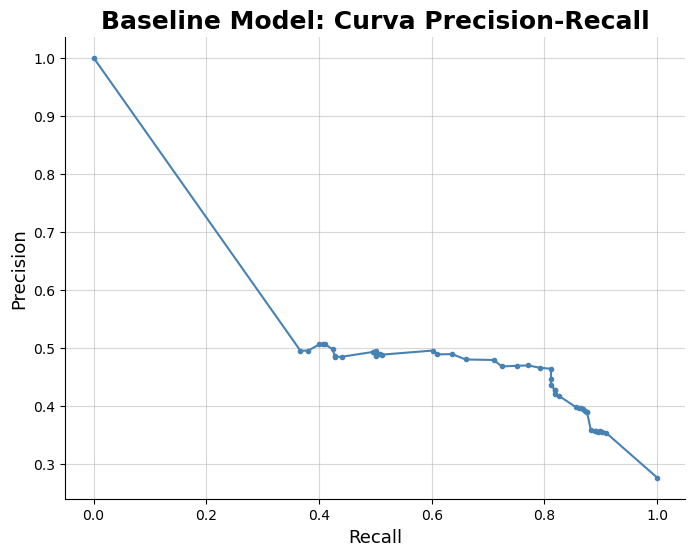

In [117]:
plot_precision_recall_curve(modelo=baseline_model,
                            x=X_test,
                            y=y_test,
                            nombre='Baseline Model')

### <font color='#8b5fc4'>**Observaciones: Baseline Model - Precision vs Recall Curve**</font>

A partir del gráfico generado se observa el trade-off entre **Precision** y **Recall** para distintos umbrales de decisión.

Por ejemplo, si se desea alcanzar un **Recall cercano a 0.80**, se debe aceptar una **caída en la Precision hasta aproximadamente 0.47**.

Dado que el objetivo principal es priorizar la **Sensibilidad *(Recall)*** sin sacrificar en exceso la **Precisión *(Precision)***, será necesario encontrar un modelo que, mediante una combinación adecuada de hiperparámetros y umbral de decisión, permita clasificar correctamente la mayor cantidad posible de verdaderos abandonos, minimizando al mismo tiempo la cantidad de falsos positivos.

In [118]:
baseline_results_umbral = metricas_evaluacion(modelo=baseline_model, 
                                               x_test= X_test,
                                               y_test=y_test,
                                               nombre='Baseline Model', 
                                               conjunto='X',
                                               umbral=0.41)

pd.DataFrame([baseline_results_umbral])

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   

   Umbral  
0    0.41

In [119]:
# Crear una lista para almacenar los resultados del mejor modelo de cada familia y poder realizar comparaciones.
best_models = []

In [120]:
best_models.append(baseline_results_umbral)
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   

   Umbral  
0    0.41

## <font color='#ebac3a'>**Random Forest Classifier**</font>

In [121]:
# Lista para registrar los resultados de los modelos dentro de la familia Random Forest
rf_results_tracking = []

### <font color='#f07c3e'>**RandomForest 1 - MaxDepth = 10 - Conjunto X**</font>

In [122]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42)

rf_1_cv_results = cross_validate(rf_1, X_cv, y_cv, cv=skf, scoring='recall')

In [123]:
cv_score_interval(results=rf_1_cv_results,
                  nombre='RandomForest 1',
                  score='Recall')

Recall promedio de RandomForest 1: 0.7115
Desviación estándar del Recall de RandomForest 1: 0.0148
El Recall de RandomForest 1 estará entre [0.6819,0.7411] con un 95% de confianza


In [124]:
rf_1.fit(X_cv, y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [125]:
rf_1_results = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X')

rf_results_tracking.append(rf_1_results)
pd.DataFrame(rf_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7745     0.5729  0.7273    0.6409  0.8295   

   Umbral  
0     0.5

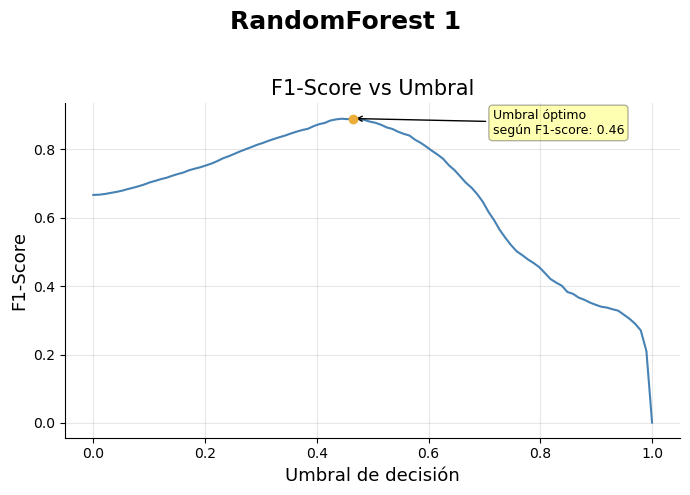

In [126]:
umbral_rf_1 = plot_umbrales(modelo=rf_1, 
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='RandomForest 1')

In [127]:
rf_1_results_umbral = metricas_evaluacion(modelo=rf_1,
                                           x_test=X_test,
                                           y_test=y_test,
                                           nombre='RandomForest 1',
                                           conjunto='X',
                                           umbral=0.46,)

rf_results_tracking.append(rf_1_results_umbral)

In [128]:
pd.DataFrame(rf_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7745     0.5729  0.7273    0.6409  0.8295   
1  RandomForest 1       X    0.7596     0.5465  0.7710    0.6397  0.8295   

   Umbral  
0    0.50  
1    0.46

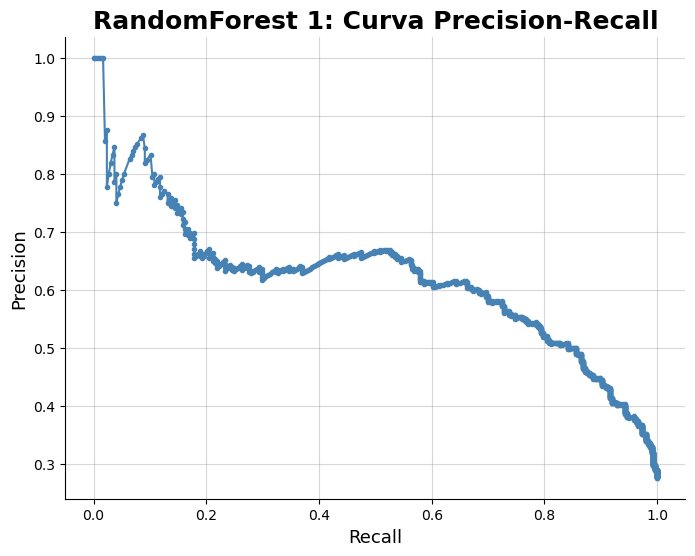

In [129]:
plot_precision_recall_curve(modelo=rf_1,
                            x=X_test,
                            y=y_test,
                            nombre='RandomForest 1')

### <font color='#8b5fc4'>**Observaciones: RandomForest 1 - MaxDepth = 10 - Conjunto X**</font>

Este modelo consigue superar significativamente a `BaselineModel`:

| Modelo           | Conjunto | Accuracy | Precision | Recall | F1-Score | AUC    | Umbral |
|------------------|----------|----------|-----------|--------|----------|--------|--------|
| Baseline Model   | X        | 0.7158   | 0.4896    | 0.6364 | 0.5534   | 0.7418 | 0.50   |
| RandomForest 1   | X        | 0.7745   | 0.5729    | 0.7273 | 0.6409   | 0.8295 | 0.50   |

Inicialmente el modelo `RandomForest 1`, con el umbral por defecto en 0.5, consigue los siguientes aumentos en las métricas:

- **Accuracy**: 0.7158 → 0.7745 = +0.0587 **(+5.87%)**
- **Precision**: 0.4896 → 0.5729 = +0.0833 **(+8.33%)**
- **Recall**: 0.6364 → 0.7273 = +0.0909 **(+9.09%)**
- **F1-Score**: 0.5534 → 0.6409 = +0.0875 **(+8.75%)**

Luego, al ajustar el **umbral según el valor óptimo determinado por la métrica F1-score (0.46)**, se incrementa significativamente el Recall, con un sacrificio leve en Precision:

| Modelo           | Conjunto | Accuracy | Precision | Recall | F1-Score | AUC    | Umbral |
|------------------|----------|----------|-----------|--------|----------|--------|--------|
| RandomForest 1   | X        | 0.7596   | 0.5465    | 0.7710 | 0.6397   | 0.8295 | 0.46   |

Con esta configuración se logra:

* Un aumento adicional del **Recall** de **+4.37%**
* Una pérdida de solo **2.64%** en **Precision**


### <font color='#f07c3e'>**RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled**</font>

Si bien el algoritmo Random Forest es robusto frente a la escala de variables, se ejecutará `Cross Validate` sobre el conjunto `X_scaled`, para ver si el modelo consigue aprender mejor el patrón presente en los datos al tener las variables numéricas transformadas con `RobustScaler`

In [130]:
rf_2 = RandomForestClassifier(max_depth=10, random_state=42)

rf_2_cv_results = cross_validate(rf_2, X_scaled_cv, y_scaled_cv, cv=skf, scoring='recall')

In [131]:
cv_score_interval(results=rf_2_cv_results,
                  nombre='RandomForest 2',
                  score='Recall')

Recall promedio de RandomForest 2: 0.6163
Desviación estándar del Recall de RandomForest 2: 0.0237
El Recall de RandomForest 2 estará entre [0.5689,0.6637] con un 95% de confianza


In [132]:
rf_2.fit(X_scaled_cv, y_scaled_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [133]:
rf_2_results = metricas_evaluacion(modelo=rf_2,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='RandomForest 2',
                                   conjunto='X_scaled')

rf_results_tracking.append(rf_2_results)
pd.DataFrame(rf_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1         X    0.7745     0.5729  0.7273    0.6409  0.8295   
1  RandomForest 1         X    0.7596     0.5465  0.7710    0.6397  0.8295   
2  RandomForest 2  X_scaled    0.7829     0.6081  0.6061    0.6071  0.8239   

   Umbral  
0    0.50  
1    0.46  
2    0.50

### <font color='#8b5fc4'>**Observaciones: RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled**</font>

Solo con analizar el resultado de `Cross Validate`, es posible observar que la métricas prioritaria (**Recall**) del modelo cae severamente al utilizar el conjunto `X_scaled`, aunque muestra una mayor estabilidad en **Precisión**. 

Sin embargo, dado que lo que se busca maximizar es la **Sensibilidad** del modelo, una diferencia de casi 17% es excesivamente alta. Por lo que este modelo no se postula como candidato a entorno productivo.

### <font color='#f07c3e'>**RandomForest 3 - MaxDepth = 10 - Conjunto X - Corr_selected Features**</font>

Se llevará a cabo un expermiento, entrenando un Random Forest utilizando las variables seleccionadas con mayor correlatividad en cuanto a la variable respuesta (`Churn`).

In [134]:
rf_3 = RandomForestClassifier(max_depth=10, random_state=42)

In [135]:
rf_3_columns = corr_selected.columns
rf_3_columns = rf_3_columns[:-1]
rf_3_columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [136]:
rf_3_cv_results = cross_validate(rf_3, X_cv[rf_3_columns], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_3_cv_results,
                  nombre='RandomForest 3',
                  score='Recall')

Recall promedio de RandomForest 3: 0.7026
Desviación estándar del Recall de RandomForest 3: 0.0187
El Recall de RandomForest 3 estará entre [0.6652,0.7400] con un 95% de confianza


In [137]:
rf_3.fit(X_cv[rf_3_columns], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [138]:
rf_3_results = metricas_evaluacion(modelo=rf_3,
                                   x_test=X_test[rf_3_columns],
                                   y_test=y_test,
                                   nombre='RandomForest 3',
                                   conjunto='X[corr_features]')

rf_results_tracking.append(rf_3_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50

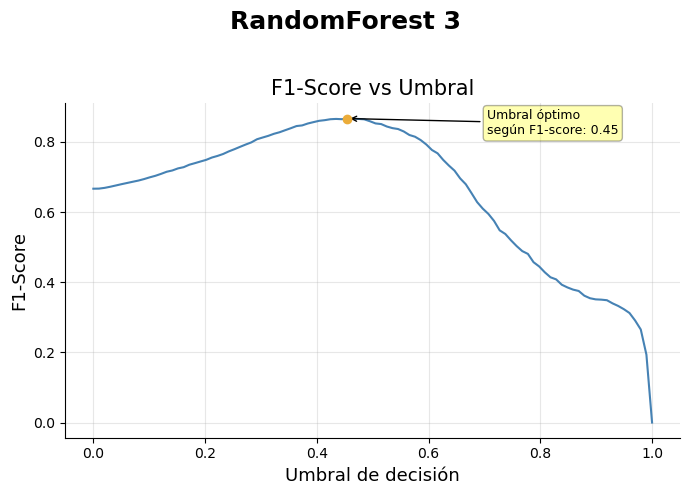

In [139]:
umbral_rf_3 = plot_umbrales(modelo=rf_3, 
                                score='F1-Score',
                                x=X_cv[rf_3_columns],
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='RandomForest 3')

In [140]:
rf_3_results_umbral = metricas_evaluacion(modelo=rf_3,
                                           x_test=X_test[rf_3_columns],
                                           y_test=y_test,
                                           nombre='RandomForest 3',
                                           conjunto='X[corr_features]',
                                           umbral=0.45)

rf_results_tracking.append(rf_3_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45

### <font color='#8b5fc4'>**Observaciones: RandomForest 3 - MaxDepth = 10 - Conjunto X - Corr_selected Features**</font>

El modelo entrenado con las variables seleccionadas de manera arbitraria al tener un valor absoluto de correlación mayor a 0.7 respecto a la variable de respuesta, consigue superar en la métrica prioritaria `RandomForest 1`.

Sin embargo, la diferencia en **Recall**, es de 0.68%, mientras que la caída en precisión es de 2.03%, por lo que esta leve mejora no justifica el sacrificio en **Precisión**.

Aún así, debido a que una reducción arbitraria en la dimensionalidad mostró que el modelo podría beneficiarse de trabajar con menos variables, se realizará una experimento para determinar la cantidad óptima de variables a partir de las importancias determinadas por `RandomForest 1`

### <font color='#f07c3e'>**Feature Selection**</font>

In [141]:
features = X_cv.columns
rf_1_importances = rf_1.feature_importances_
rf_1_importances = pd.DataFrame({'Feature': features, 'Importancia': rf_1_importances})
rf_1_importances = rf_1_importances.sort_values('Importancia', ascending=False)
rf_1_importances

Feature  Importancia
23                                   Tenure     0.210398
25                             ChargesTotal     0.186427
24                           ChargesMonthly     0.127551
15                  Contract_Month-to-month     0.064609
12                          TechSupport_Yes     0.039548
21           PaymentMethod_Electronic check     0.037476
9                        OnlineSecurity_Yes     0.025942
17                        Contract_Two year     0.025216
18                     PaperlessBilling_Yes     0.024454
7               InternetService_Fiber optic     0.022676
0                               Gender_Male     0.020555
16                        Contract_One year     0.018603
14                      StreamingMovies_Yes     0.018309
5                         MultipleLines_Yes     0.018255
10                         OnlineBackup_Yes     0.017365
3                            Dependents_Yes     0.017232
2                               Partner_Yes     0.017093
11                     DeviceProtection_Yes     0.016673
13                          StreamingTV_Yes     0.016527
1                         SeniorCitizen_Yes     0.015249
6                       InternetService_DSL     0.014599
22               PaymentMethod_Mailed check     0.012451
20    PaymentMethod_Credit card (automatic)     0.010784
19  PaymentMethod_Bank transfer (automatic)     0.010067
4                          PhoneService_Yes     0.007514
8                         NoInternetService     0.004426

In [142]:
len(rf_1_importances)

26

In [143]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(rf_1_importances), 5)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=42)
    selected_features = rf_1_importances['Feature'].values[:i]
    X_train_sel = X_cv[selected_features]
    X_test_sel = X_test[selected_features]
    model_features.fit(X_train_sel, y_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_test, f'Features: {i}', 'X')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0   Features: 1       X    0.6664     0.4079  0.4545    0.4299  0.6595     0.5
1   Features: 5       X    0.7353     0.5175  0.6465    0.5749  0.7950     0.5
2  Features: 10       X    0.7707     0.5673  0.7239    0.6361  0.8245     0.5
3  Features: 15       X    0.7791     0.5794  0.7374    0.6489  0.8228     0.5
4  Features: 20       X    0.7679     0.5628  0.7239    0.6333  0.8300     0.5
5  Features: 25       X    0.7614     0.5535  0.7138    0.6235  0.8318     0.5

### <font color='#8b5fc4'>**Observaciones: Feature Selection**</font>

El modelo que consigue mejor **Recall** es aquel entrenado con las 15 variables más importantes según `RandomForest 1`:

* `Tenure`
* `ChargesTotal`
* `ChargesMonthly`
* `Contract_Month-to-month`
* `TechSupport_Yes`
* `PaymentMethod_Electronic check`
* `OnlineSecurity_Yes`
* `Contract_Two year`
* `PaperlessBilling_Yes`
* `InternetService_Fiber optic`
* `Gender_Male`
* `Contract_One year`
* `StreamingMovies_Yes`
* `MultipleLines_Yes`
* `OnlineBackup_Yes`

Por lo que, se entrenará un modelo que permita controlar el umbral de decisión con la intención de superar las mejores métricas obtenidas hasta el momento.

### <font color='#f07c3e'>**RandomForest 4 - Max depth = 10 - Feature Selection**</font>

In [144]:
selected_cols = rf_1_importances['Feature'][:15].values
selected_cols

array(['Tenure', 'ChargesTotal', 'ChargesMonthly',
       'Contract_Month-to-month', 'TechSupport_Yes',
       'PaymentMethod_Electronic check', 'OnlineSecurity_Yes',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'InternetService_Fiber optic', 'Gender_Male', 'Contract_One year',
       'StreamingMovies_Yes', 'MultipleLines_Yes', 'OnlineBackup_Yes'],
      dtype=object)

In [145]:
rf_4 = RandomForestClassifier(max_depth=10, random_state=42)

rf_4_cv_results = cross_validate(rf_4, X_cv[selected_cols], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_4_cv_results,
                  nombre='RandomForest 4',
                  score='Recall')

Recall promedio de RandomForest 4: 0.6966
Desviación estándar del Recall de RandomForest 4: 0.0141
El Recall de RandomForest 4 estará entre [0.6684,0.7248] con un 95% de confianza


In [146]:
rf_4.fit(X_cv[selected_cols], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

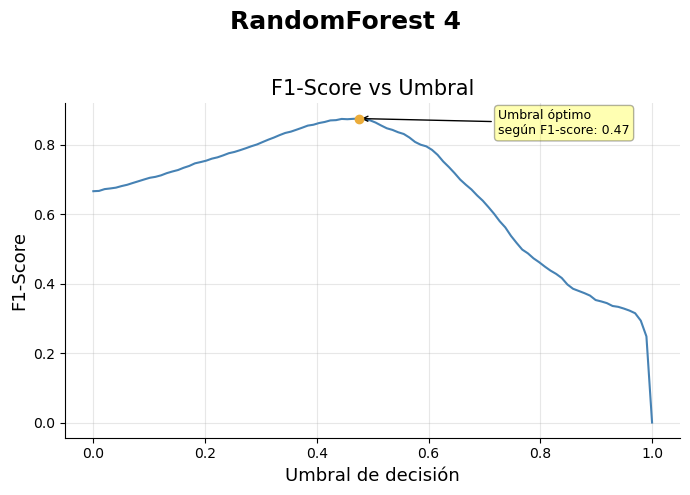

In [147]:
umbral_rf_4 = plot_umbrales(modelo=rf_4, 
                                score='F1-Score',
                                x=X_cv[selected_cols],
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='RandomForest 4')

In [148]:
rf_4_results = metricas_evaluacion(modelo=rf_4,
                                   x_test=X_test[selected_cols],
                                   y_test=y_test,
                                   nombre='RandomForest 4',
                                   conjunto='X[selected_cols]',
                                   umbral=0.47)

rf_results_tracking.append(rf_4_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47

### <font color='#8b5fc4'>**Observaciones: RandomForest 4 - Max depth = 10 - Feature Selection**</font>

El modelo entrenado con las variables que se determinaron óptimas para el mismo, no consigue superar al primer modelo entrenado, incluso modificando el umbral de decisión determinado por **F1-score**.

Esto puede ser un indicador que los modelos basados en árboles se benefician de una mayor cantidad de información para tomar decisiones a la hora de separar las clases.

### <font color='#f07c3e'>**RandomForest 5 - GridSearchCV**</font>

Se ejecutará un GridSearchCV para determinar los hiperparámetros que mejor se ajusten al conjunto de datos disponible

In [149]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150, 200, 250]
}

rf_5 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_5.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='recall')

In [150]:
rf_5.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [151]:
#rf_5 = RandomForestClassifier(random_state=42, max_depth=10,
#                              min_samples_leaf=1, min_samples_split=3,
#                              n_estimators=250)

#rf_5.fit(X_cv, y_cv)

In [152]:
#rf_5_results = metricas_evaluacion(modelo=rf_5,
#                                   x_test=X_test,
#                                   y_test=y_test,
#                                   nombre='RandomForest 5',
#                                   conjunto='X')

#rf_results_tracking.append(rf_5_results)
#pd.DataFrame(rf_results_tracking)

In [153]:
#umbral_rf_5 = plot_umbrales(modelo=rf_5, 
#                                score='F1-Score',
#                                x=X_cv,
#                                y=y_cv,
#                                caja_x=0.25, 
#                                caja_y=0.045, 
#                                nombre='RandomForest 5')

In [154]:
#rf_5_results_umbral = metricas_evaluacion(modelo=rf_5.best_estimator_,
#                                   x_test=X_test,
#                                   y_test=y_test,
#                                   nombre='RandomForest 5',
#                                   conjunto='X',
#                                   umbral=0.44)

#rf_results_tracking.append(rf_5_results_umbral)
#pd.DataFrame(rf_results_tracking)

In [155]:
rf_5_results = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X')

rf_results_tracking.append(rf_5_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50

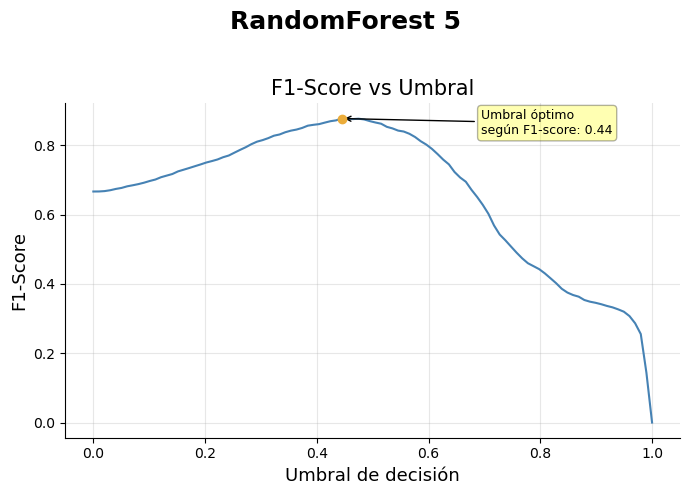

In [156]:
umbral_rf_5 = plot_umbrales(modelo=rf_5.best_estimator_, 
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='RandomForest 5')

In [157]:
rf_5_results_umbral = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.44)

rf_results_tracking.append(rf_5_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44

### <font color='#8b5fc4'>**Observaciones: RandomForest 5 - GridSearchCV**</font>

Los hiperparámetros determinados por GridSearchCV para el modelo RandomForest que mejor se ajustan al conjunto de datos son:

* `max_depth=10`
* `min_samples_split=3`
* `min_samples_leaf=1`
* `n_estimators=250`

Con estas configuraciones, y ajustando el umbral de decisión a 0.44, el modelo `RandomForest 5` consigue superar a `RandomForest 1`.

### <font color='#f07c3e'>**RandomForest 6 - GridSearchCV - Más estimadores**</font>

Por último, debido a que el hiperparámetro `n_estimators` utilizado fue el máximo provisto en el `param_grid`. Se hará un ultimo experimento para explorar si el modelo podría beneficiarse de utilizar mayor cantidad de estimadores.

In [158]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [200, 250, 300, 500]
}

rf_6 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_6.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [200, 250, 300, 500]},
             scoring='recall')

In [159]:
rf_6.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [160]:
#rf_6 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=1,
#                                min_samples_split=2, n_estimators=500)

#rf_6.fit(X_cv, y_cv)

In [161]:
#rf_6_results = metricas_evaluacion(modelo=rf_6,
#                                   x_test=X_test,
#                                   y_test=y_test,
#                                   nombre='RandomForest 6',
#                                   conjunto='X')

#rf_results_tracking.append(rf_6_results)
#pd.DataFrame(rf_results_tracking)

In [162]:
#umbral_rf_6 = plot_umbrales(modelo=rf_6, 
#                                score='F1-Score',
#                                x=X_cv,
#                                y=y_cv,
#                                caja_x=0.25, 
#                                caja_y=0.045, 
#                                nombre='RandomForest 6')

In [163]:
#rf_6_results_umbral = metricas_evaluacion(modelo=rf_6,
#                                   x_test=X_test,
#                                   y_test=y_test,
#                                   nombre='RandomForest 6',
#                                   conjunto='X',
#                                   umbral=0.47)

#rf_results_tracking.append(rf_6_results_umbral)
#pd.DataFrame(rf_results_tracking)

In [164]:
rf_6_results = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X')

rf_results_tracking.append(rf_6_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   
8  RandomForest 6                 X    0.7689     0.5646  0.7205    0.6331   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44  
8  0.8319    0.50

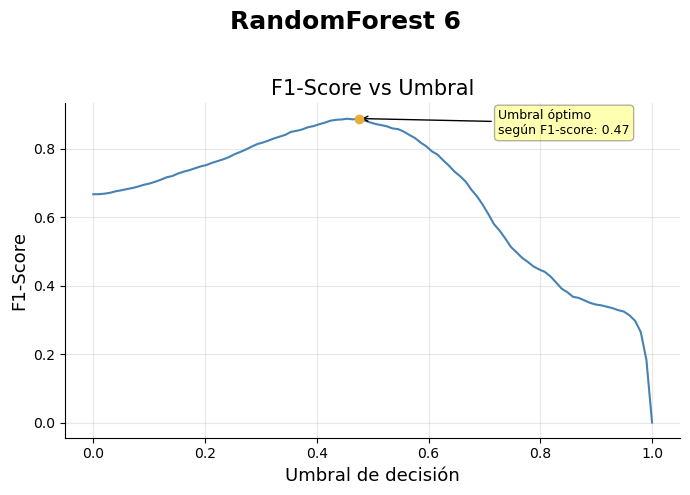

In [165]:
umbral_rf_6 = plot_umbrales(modelo=rf_6.best_estimator_, 
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25, 
                                caja_y=0.045, 
                                nombre='RandomForest 6')

In [166]:
rf_6_results_umbral = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X',
                                   umbral=0.47)

rf_results_tracking.append(rf_6_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7829     0.6081  0.6061    0.6071   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   
8  RandomForest 6                 X    0.7689     0.5646  0.7205    0.6331   
9  RandomForest 6                 X    0.7614     0.5494  0.7677    0.6404   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8239    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44  
8  0.8319    0.50  
9  0.8319    0.47

### <font color='#8b5fc4'>**Observaciones: RandomForest 6: GridSearchCV - Más estimadores**</font>

Aún utilizando el doble de `n_estimators` y ajustando su umbral de decisión a su punto óptimo *(determinado por la métrica F1-score)* en **0.47**, este modelo no consigue superar a los líderes dentro de la familia Random Forest Classifier.

### <font color='#f07c3e'>**Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión**</font>

Si bien `RandomForest 5` consigue superar a `RandomForest 1` en la métrica prioritaria, el umbral definido para este último fue 0.46:

| Modelo        | Conjunto | Accuracy  | Precision| Recall   | F1-score | AUC       | Umbral|
|---------------|----------|-----------|----------|----------|----------|-----------|-------|
|RandomForest 1	| X	       | 0.7596	   | 0.5465	  | 0.7710	 | 0.6397	| 0.8295	| 0.46  |
|RandomForest 5	| X	       | 0.7409	   | 0.5208	  | 0.8013	 | 0.6313	| 0.8326	| 0.44  |

Por lo que, para comprar ambos modelos de manera "justa". Se establecerá el umbral de `RandomForest 1` en 0.44 para ver las variaciones en sus métricas.

In [167]:
best_rfs = []
rf_1_results_umbral2 = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X',
                                   umbral=0.44)

rf_5_results_umbral2 = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.46)

best_rfs.append(rf_1_results_umbral)
best_rfs.append(rf_5_results_umbral2)
best_rfs.append(rf_1_results_umbral2)
best_rfs.append(rf_5_results_umbral)

pd.DataFrame(best_rfs)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7596     0.5465  0.7710    0.6397  0.8295   
1  RandomForest 5       X    0.7558     0.5404  0.7879    0.6411  0.8326   
2  RandomForest 1       X    0.7418     0.5220  0.7980    0.6312  0.8295   
3  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.46  
1    0.46  
2    0.44  
3    0.44

### <font color='#8b5fc4'>**Observaciones: Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión**</font>

Aún reduciendo el umbral de decisión de `RandomForest 1` a **0.44**, este no consigue superar el **Recall** de `RandomForest 5`.

Esto demuestra que los hiperparámetros obtenidos por `GridSearchCV` consiguen mejorar la performance del modelo al separar las clases del conjunto de datos.

## <font color='#ebac3a'>**Conclusiones Random Forest Classifier**</font>

Luego de entrenar 6 modelos distintos, el que demostró **mejor desempeño general** fue `RandomForest 5`, el cual **se optimizó mediante `GridSearchCV` para determinar los hiperparámetros que calibraran el modelo al conjunto de datos**, utilizando todas las variables sin filtrado previo. Y utilizando un umbral de decisión de 0.44, determinado por la métrica **F1-score** 

Sus métricas de evaluación frente al modelo base (`BaselineModel`):

|Modelo         | Conjunto | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------|----------|-----------|-----------|-----------|-----------|----------|---------|
|Baseline Model	| X	       | 0.7158	   | 0.4896	   | 0.6364	   | 0.5534	   | 0.7418	  | 0.5     |
|RandomForest 5	| X	       | 0.7409	   | 0.5208	   | 0.8013	   | 0.6313	   | 0.8326	  | 0.44    |

El algoritmo de **Random Forest Classifier** fue capaz de superar en todas sus métricas al modelo base (`Decision Tree Classifier`).

* **Accuracy**: 0.7158 -> 0.7409 = +0.0251 (**+2.51%**)
* **Precision**: 0.4896 -> 0.5208 = +0.0312 (**+3.12%**)
* **Recall**: 0.6364 -> 0.8013 = +0.1649 (**+16.49%**)
* **F1-score**: 0.5534 -> 0.6313 = +0.0778 (**+7.78%**)
* **AUC**: 0.7418 -> 0.8326 = +0.0907 (**+9.07%**)

La mejora más significativa se observa en **Recall**, lo cual respalda los objetivos del proyecto, ya que se prioriza la **correcta identificación de potenciales abandonos**.
Esto refuerza la elección del modelo y demuestra su capacidad para **manejar variables en distintas escalas** y entregar un rendimiento robusto en tareas de clasificación desbalanceada.

Por lo tanto, se conservará `RandomForest 5` como el mejor modelo de esta familia.

In [168]:
best_models.append(rf_5_results_umbral)

In [169]:
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.41  
1    0.44

In [170]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'wb') as f:
    pickle.dump(rf_5.best_estimator_, f)

## <font color='#ebac3a'>**Logistic Regresion**</font>

A diferencia del modelo RandomForest, la Regresión Logística es sensible a outliers y a la escala de los datos. Además, a menos que se utilice la regularización Lasso que penaliza la complejidad del modelo, este, también es sensible a la multicolinealidad.

Por esta razón, se iniciará entrenando una **Regresión Logística** básica, utilizando los datos de entrenamiento `X_linear`, el cual fue codificado con `OneHotEncoder(drop='first')` y con las variables numéricas escaladas.

Además, para la regularización Lasso, se utilizará el conjunto `X_scaled`, el cual cuenta con variables categoricas codificadas utilizando `OneHotEncoder(drop='if_binary')` pero con las variables numéricas escaladas.

In [171]:
lr_results_tracking = []

### <font color='#f07c3e'>**LogisticRegression 1**</font>

In [172]:
lr_1 = LogisticRegression(random_state=42)

lr_1_cv_results = cross_validate(lr_1, X_linear_cv, y_linear_cv, cv=skf, scoring='recall')

In [173]:
cv_score_interval(results=lr_1_cv_results,
                  nombre='LogisticRegression 1',
                  score='Recall')

Recall promedio de LogisticRegression 1: 0.621
Desviación estándar del Recall de LogisticRegression 1: 0.0306
El Recall de LogisticRegression 1 estará entre [0.5598,0.6822] con un 95% de confianza


In [174]:
lr_1.fit(X_linear_cv, y_linear_cv)

LogisticRegression(random_state=42)

In [175]:
lr_1_results = metricas_evaluacion(modelo=lr_1,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 1',
                                   conjunto='X_linear')

lr_results_tracking.append(lr_1_results)
pd.DataFrame(lr_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score  \
0  LogisticRegression 1  X_linear    0.7493     0.5438  0.5859     0.564   

      AUC  Umbral  
0  0.8052     0.5

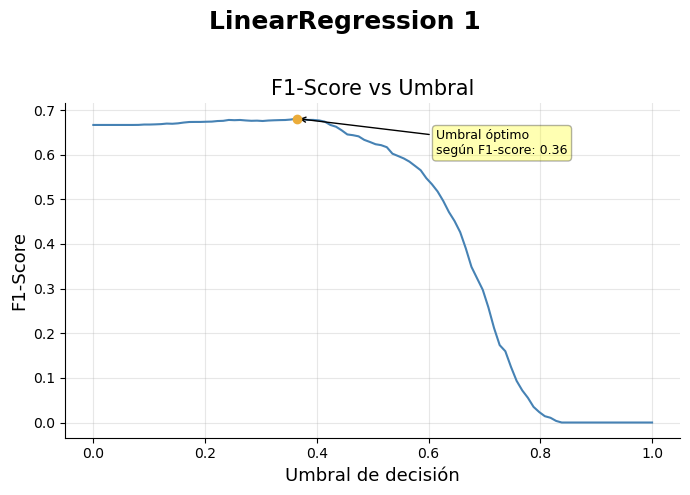

In [176]:
umbral_lr_1 = plot_umbrales(modelo=lr_1,
                            score='F1-Score',
                            x=X_linear_cv,
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 1')                            

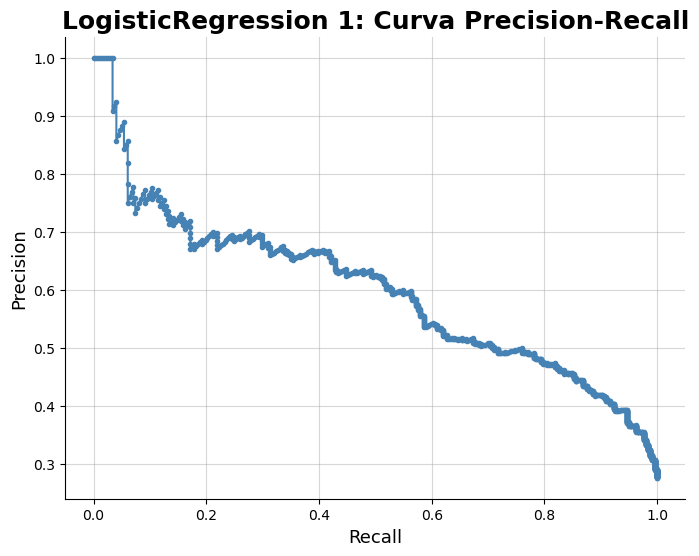

In [177]:
plot_precision_recall_curve(modelo=lr_1,
                            x=X_linear_test,
                            y=y_linear_test,
                            nombre='LogisticRegression 1')

#### <font color='#8b5fc4'>**Observaciones: LogisticRegression 1 - Curva Precision-Recall**</font>

Como puede observarse en la **Curva Precisión-Recall**, el modelo `LogisticRegression 1` para alcanzar 0.8 en **Recall** deberá sacrificar su precisión hasta aproximadamente 0.48.

El umbral de decisión determinado por la métrica **F1-Score**, se corresponde a 0.36. Es decir que aquellos clientes que tengan una **probabilidad de abandono de 36%**, serán clasificados como `Churn=1`.

A simple vista este valor parece ser demasiado bajo, sin embargo, se explorarán las metricas obtenidas según el umbral determinado por la metrica mencionada anteriormente.

In [178]:
lr_1_results_umbral = metricas_evaluacion(modelo=lr_1,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 1',
                                   conjunto='X_linear',
                                   umbral=0.36)

lr_results_tracking.append(lr_1_results_umbral)
pd.DataFrame(lr_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score  \
0  LogisticRegression 1  X_linear    0.7493     0.5438  0.5859    0.5640   
1  LogisticRegression 1  X_linear    0.6300     0.4204  0.8889    0.5708   

      AUC  Umbral  
0  0.8052    0.50  
1  0.8052    0.36

In [179]:
pd.DataFrame({'Features': X_linear_cv.columns.values, 'Coeficiente': lr_1.coef_[0]}).sort_values('Coeficiente', ascending=False)

Features  Coeficiente
6             InternetService_Fiber optic     0.619243
22                    ChargesTotal_scaled     0.478952
18         PaymentMethod_Electronic check     0.319952
1                       SeniorCitizen_Yes     0.252729
5                       MultipleLines_Yes     0.235721
12                        StreamingTV_Yes     0.217006
16                   PaperlessBilling_Yes     0.209111
13                    StreamingMovies_Yes     0.191947
15                      Contract_Two year     0.153948
19             PaymentMethod_Mailed check     0.119226
17  PaymentMethod_Credit card (automatic)     0.064983
0                             Gender_Male     0.026669
9                        OnlineBackup_Yes     0.011727
7                       NoInternetService     0.004718
10                   DeviceProtection_Yes    -0.005887
2                             Partner_Yes    -0.014860
14                      Contract_One year    -0.026619
3                          Dependents_Yes    -0.063051
21                  ChargesMonthly_scaled    -0.070547
8                      OnlineSecurity_Yes    -0.088903
11                        TechSupport_Yes    -0.190192
4                        PhoneService_Yes    -0.343217
20                          Tenure_scaled    -1.738217

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 1 - Conjunto X_linear**</font>

Este modelo inicial dentro de la familia de **Logistic Regression** consigue un **Recall** muy elevado al utilizar un umbral de decisión de 0.36.
A diferencia del umbral por defecto (0.5), la métrica prioritaria consigue un **amuento de casi 30%**, con un sacrificio en Precision de aproximadamente **12%**.

Si bien el trade-off se justifica, incurrir en demasiados **falsos positivos** puede llevar a la empresa a campañas de retención ineficientes en costos.
Sin embargo, como modelo base dentro de la familia, sus métricas son más que aceptables, por lo que, partiendo de esta base, se realizarán diversos experimentos que permitan al menos mantener el **Recall** obtenido y mejorar la **Precisión** del modelo.

### <font color='#f07c3e'>**LogisticRegression 2 - Feature Selection**</font>

In [180]:
lr_1_coef = pd.DataFrame({'Feature': X_linear_cv.columns.values, 'Coeficiente': np.abs(lr_1.coef_[0])}).sort_values('Coeficiente', ascending=False)
len(lr_1_coef)

23

In [181]:
lr_1_coef

Feature  Coeficiente
20                          Tenure_scaled     1.738217
6             InternetService_Fiber optic     0.619243
22                    ChargesTotal_scaled     0.478952
4                        PhoneService_Yes     0.343217
18         PaymentMethod_Electronic check     0.319952
1                       SeniorCitizen_Yes     0.252729
5                       MultipleLines_Yes     0.235721
12                        StreamingTV_Yes     0.217006
16                   PaperlessBilling_Yes     0.209111
13                    StreamingMovies_Yes     0.191947
11                        TechSupport_Yes     0.190192
15                      Contract_Two year     0.153948
19             PaymentMethod_Mailed check     0.119226
8                      OnlineSecurity_Yes     0.088903
21                  ChargesMonthly_scaled     0.070547
17  PaymentMethod_Credit card (automatic)     0.064983
3                          Dependents_Yes     0.063051
0                             Gender_Male     0.026669
14                      Contract_One year     0.026619
2                             Partner_Yes     0.014860
9                        OnlineBackup_Yes     0.011727
10                   DeviceProtection_Yes     0.005887
7                       NoInternetService     0.004718

In [182]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(lr_1_coef), 3)]

for i in ct_features:
    model_features = LogisticRegression(random_state=42)
    selected_features = lr_1_coef['Feature'].values[:i]
    X_train_sel = X_linear_cv[selected_features]
    X_test_sel = X_linear_test[selected_features]
    model_features.fit(X_train_sel, y_linear_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_linear_test, f'Features: {i}', 'X_linear')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0   Features: 1  X_linear    0.6412     0.4079  0.6566    0.5032  0.6880   
1   Features: 3  X_linear    0.7437     0.5335  0.5892    0.5600  0.7853   
2   Features: 6  X_linear    0.7577     0.5587  0.5926    0.5752  0.8045   
3   Features: 9  X_linear    0.7577     0.5595  0.5859    0.5724  0.8051   
4  Features: 12  X_linear    0.7521     0.5489  0.5859    0.5668  0.8007   
5  Features: 15  X_linear    0.7484     0.5418  0.5892    0.5645  0.8036   
6  Features: 18  X_linear    0.7484     0.5421  0.5859    0.5631  0.8046   
7  Features: 21  X_linear    0.7512     0.5472  0.5859    0.5659  0.8057   

   Umbral  
0     0.5  
1     0.5  
2     0.5  
3     0.5  
4     0.5  
5     0.5  
6     0.5  
7     0.5

In [183]:
selected_features = lr_1_coef['Feature'][:6]

In [184]:
lr_2 = LogisticRegression(random_state=42)

lr_2_cv_results = cross_validate(lr_2,
                                 X_linear_cv[selected_features],
                                 y_linear_cv,
                                 scoring='recall',
                                 cv=skf)

In [185]:
cv_score_interval(results=lr_2_cv_results,
                  nombre='LogisticRegression 2',
                  score='Recall')

Recall promedio de LogisticRegression 2: 0.6353
Desviación estándar del Recall de LogisticRegression 2: 0.0294
El Recall de LogisticRegression 2 estará entre [0.5765,0.6941] con un 95% de confianza


In [186]:
lr_2.fit(X_linear_cv[selected_features], y_linear_cv)

LogisticRegression(random_state=42)

In [187]:
lr_2_results = metricas_evaluacion(modelo=lr_2,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 2',
                                   conjunto='X_linear[selected_features]')

lr_results_tracking.append(lr_2_results)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50

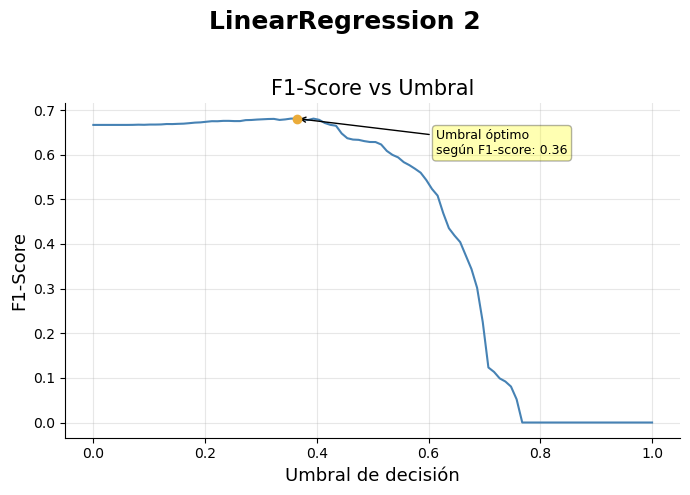

In [188]:
umbral_lr_2 = plot_umbrales(modelo=lr_2,
                            score='F1-Score',
                            x=X_linear_cv[selected_features],
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 2')

In [189]:
lr_2_results_umbral = metricas_evaluacion(modelo=lr_2,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 2',
                                   conjunto='X_linear[selected_features]',
                                   umbral=0.36)

lr_results_tracking.append(lr_2_results_umbral)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 2: Feature Selection**</font>

La selección manual de features a partir de los coeficientes obtenidos por `LogisticRegression 1` aportan una leve mejora en **Recall** de **1.01%**, con un trade-off de **0.19%** en Precisión. Utilizando el mismo **umbral de decisión en 0.36**.

Si bien esto es una mejora en la métrica prioritaria, lo que se busca mejorar es la precisión de este primer modelo mantieniendo el **Recall** obtenido. Por lo que se seguirán explorando opciones que mejoren el desempeño.

### <font color='#f07c3e'>**LogisticRegression 3: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

In [190]:
lr_3 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_3_cv_results = cross_validate(lr_3,
                                X_scaled_cv, 
                                y_scaled_cv, 
                                scoring='recall', 
                                cv=skf)

In [191]:
cv_score_interval(results=lr_3_cv_results,
                  nombre='LogisticRegression 3',
                  score='Recall')

Recall promedio de LogisticRegression 3: 0.6133
Desviación estándar del Recall de LogisticRegression 3: 0.0285
El Recall de LogisticRegression 3 estará entre [0.5563,0.6703] con un 95% de confianza


In [192]:
lr_3.fit(X_scaled_cv, y_scaled_cv)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [193]:
lr_3_results = metricas_evaluacion(modelo=lr_3,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='LogisticRegression 3',
                                   conjunto='X_scaled')

lr_results_tracking.append(lr_3_results)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50

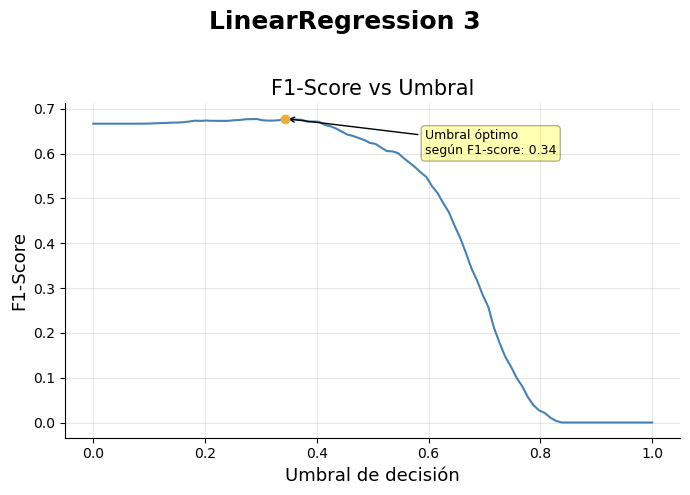

In [194]:
umbral_lr_3 = plot_umbrales(modelo=lr_3,
                            score='F1-Score',
                            x=X_scaled_cv,
                            y=y_scaled_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 3')

In [195]:
lr_3_results_umbral = metricas_evaluacion(modelo=lr_3,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='LogisticRegression 3',
                                   conjunto='X_scaled',
                                   umbral=0.34)

lr_results_tracking.append(lr_3_results_umbral)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34

In [196]:
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.41  
1    0.44

In [197]:
X_scaled_cv.columns.values

array(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled'],
      dtype=object)

In [198]:
lr_3.coef_

array([[ 0.0067699 ,  0.26597659,  0.01482351, -0.07077692, -0.56404957,
         0.25979446, -0.34429957,  0.06907696, -0.17232979, -0.1050866 ,
         0.        , -0.00995619, -0.22956286,  0.11536842,  0.07962814,
        -0.10386658,  0.        ,  0.13712116,  0.14857658, -0.00989692,
        -0.02314988,  0.25026495,  0.        , -1.58831934,  0.43407341,
         0.26822763]])

In [199]:
pd.DataFrame({'Features': X_scaled_cv.columns.values, 'Coeficiente': lr_3.coef_[0]}).sort_values('Coeficiente', ascending=False)

Features  Coeficiente
24                    ChargesMonthly_scaled     0.434073
25                      ChargesTotal_scaled     0.268228
1                         SeniorCitizen_Yes     0.265977
5                         MultipleLines_Yes     0.259794
21           PaymentMethod_Electronic check     0.250265
18                     PaperlessBilling_Yes     0.148577
17                        Contract_Two year     0.137121
13                          StreamingTV_Yes     0.115368
14                      StreamingMovies_Yes     0.079628
7               InternetService_Fiber optic     0.069077
2                               Partner_Yes     0.014824
0                               Gender_Male     0.006770
10                         OnlineBackup_Yes     0.000000
16                        Contract_One year     0.000000
22               PaymentMethod_Mailed check     0.000000
19  PaymentMethod_Bank transfer (automatic)    -0.009897
11                     DeviceProtection_Yes    -0.009956
20    PaymentMethod_Credit card (automatic)    -0.023150
3                            Dependents_Yes    -0.070777
15                  Contract_Month-to-month    -0.103867
9                        OnlineSecurity_Yes    -0.105087
8                         NoInternetService    -0.172330
12                          TechSupport_Yes    -0.229563
6                       InternetService_DSL    -0.344300
4                          PhoneService_Yes    -0.564050
23                            Tenure_scaled    -1.588319

In [200]:
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 3: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

Al comparar el modelo inicial de esta familia con el modelo entrenado utilizando penalización Lasso (`LogisticRegression 2`), se observa que consigue mejorar el **Recall** con su correspondiente trade-off en **Precisión**. Utilizando un **umbral de decisión de 0.34**.

La regularización L1 **automatizó la selección de variables**, reduciendo a cero los coeficientes de aquellas consideradas poco relevantes por el modelo:

- `OnlineBackup_Yes`
- `Contract_One year`
- `PaymentMethod_Mailed check`

Su desempeño global es levemente inferior, mostrando un **F1-score 1.38% más bajo** en comparación a `LogisticRegression 1`.

La métrica prioritaria (**Recall**) obtiene una mejora de **+2.36%**, pero tanto **Precision como F1-score** fueron inferiores en el modelo con penalización L1.

* **Precision: -1.95%**
* **F1-score: -1.38%**

Este modelo puede postularse como buen candidato de la familia ya que el **Recall** obtenido es elevado.

### <font color='#f07c3e'>**LogisticRegression 4 - GridSearchCV - Conjunto X_linear**</font>

In [201]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],            
    'max_iter': [100, 200, 500]
}

lr_4 = GridSearchCV(LogisticRegression(random_state=42),
                    param_grid=param_grid, 
                    scoring='recall',
                    cv=skf)

lr_4.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500], 'solver': ['lbfgs']},
             scoring='recall')

In [202]:
lr_4.best_params_

{'C': 0.001, 'max_iter': 100, 'solver': 'lbfgs'}

In [203]:
#lr_4 = LogisticRegression(random_state=42, C=0.001, max_iter=100, solver='lbfgs')

#lr_4.fit(X_linear_cv, y_linear_cv)

In [204]:
#lr_4_results = metricas_evaluacion(modelo=lr_4,
#                                   x_test=X_linear_test,
#                                   y_test=y_linear_test,
#                                   nombre='LogisticRegression 4',
#                                   conjunto='X_linear')

#lr_results_tracking.append(lr_4_results)
#pd.DataFrame(lr_results_tracking)

In [205]:
#umbral_lr_4 = plot_umbrales(modelo=lr_4,
#                            score='F1-Score',
#                            x=X_linear_cv,
#                            y=y_linear_cv,
#                            caja_x=0.25,
#                            caja_y=0.08,
#                            nombre='LinearRegression 4')

In [206]:
#lr_4_results_umbral = metricas_evaluacion(modelo=lr_4,
#                                   x_test=X_linear_test,
#                                   y_test=y_linear_test,
#                                   nombre='LogisticRegression 4',
#                                   conjunto='X_linear',
#                                   umbral=0.43)

#lr_results_tracking.append(lr_4_results_umbral)
#pd.DataFrame(lr_results_tracking)

In [207]:
lr_4_results = metricas_evaluacion(modelo=lr_4.best_estimator_,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 4',
                                   conjunto='X_linear')

lr_results_tracking.append(lr_4_results)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   
6  LogisticRegression 4                     X_linear    0.7651     0.5710   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34  
6  0.6094    0.5896  0.8089    0.50

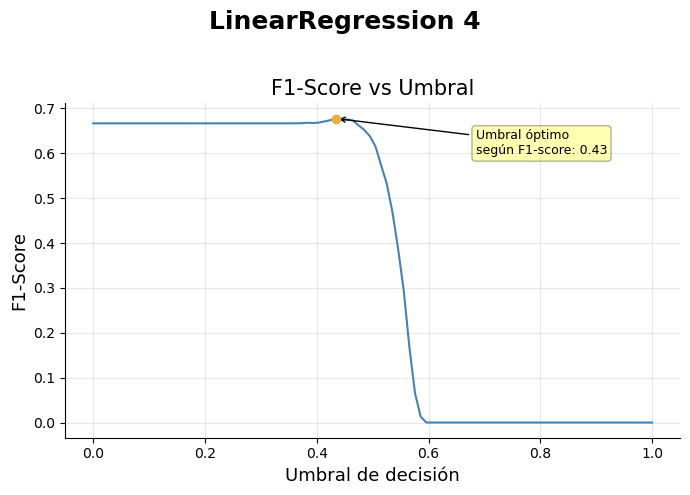

In [208]:
umbral_lr_4 = plot_umbrales(modelo=lr_4.best_estimator_,
                            score='F1-Score',
                            x=X_linear_cv,
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 4')

In [209]:
lr_4_results_umbral = metricas_evaluacion(modelo=lr_4,
                                   x_test=X_linear_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 4',
                                   conjunto='X_linear',
                                   umbral=0.43)

lr_results_tracking.append(lr_4_results_umbral)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   
6  LogisticRegression 4                     X_linear    0.7651     0.5710   
7  LogisticRegression 4                     X_linear    0.4539     0.3318   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34  
6  0.6094    0.5896  0.8089    0.50  
7  0.9596    0.4931  0.8089    0.43

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 4 - GridSearchCV - Conjunto X_linear**</font>

El ajuste de hiperparámetros sobre LogisticRegression 1, consigue un recall elevado al utilizar un umbral de decisión de 0.43, sin embargo, el trade-off con **Precisión** es demasiado elevado, dejando 33% de casos donde el modelo predice correctamente clientes que no tienden a abandonar el servicio.

Esto implica que 2 de cada 3 clientes que no tienen probabilidades de abandonar, serán intervenidos en campañas de retención, lo que podría elevar desmesuradamente los costos de dichas campañas.

Por lo que, debido a su **Precisión**, este modelo se descarta como representante de su familia.

### <font color='#f07c3e'>**LogisticRegression 5 - GridSearchCV - Selected Features - Conjunto X_linear**</font>

In [210]:
lr_4_coef = pd.DataFrame({'Feature': X_linear_cv.columns.values, 'Coeficiente': np.abs(lr_4.best_estimator_.coef_[0])}).sort_values('Coeficiente', ascending=False)
len(lr_4_coef)

23

In [211]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(lr_4_coef), 3)]

for i in ct_features:
    model_features = LogisticRegression(random_state=42)
    selected_features = lr_4_coef['Feature'].values[:i]
    X_train_sel = X_linear_cv[selected_features]
    X_test_sel = X_linear_test[selected_features]
    model_features.fit(X_train_sel, y_linear_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_linear_test, f'Features: {i}', 'X_linear')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0   Features: 1  X_linear    0.6412     0.4079  0.6566    0.5032  0.6880   
1   Features: 3  X_linear    0.7437     0.5335  0.5892    0.5600  0.7853   
2   Features: 6  X_linear    0.7465     0.5389  0.5825    0.5599  0.8028   
3   Features: 9  X_linear    0.7568     0.5559  0.6027    0.5784  0.8105   
4  Features: 12  X_linear    0.7661     0.5701  0.6296    0.5984  0.8135   
5  Features: 15  X_linear    0.7596     0.5623  0.5926    0.5770  0.8084   
6  Features: 18  X_linear    0.7502     0.5452  0.5892    0.5663  0.7986   
7  Features: 21  X_linear    0.7521     0.5486  0.5892    0.5682  0.8051   

   Umbral  
0     0.5  
1     0.5  
2     0.5  
3     0.5  
4     0.5  
5     0.5  
6     0.5  
7     0.5

In [212]:
selected_features = lr_4_coef['Feature'][:12].values
selected_features

array(['Tenure_scaled', 'InternetService_Fiber optic',
       'ChargesTotal_scaled', 'PaymentMethod_Electronic check',
       'ChargesMonthly_scaled', 'PaperlessBilling_Yes',
       'OnlineSecurity_Yes', 'TechSupport_Yes', 'Contract_One year',
       'SeniorCitizen_Yes', 'Dependents_Yes', 'Partner_Yes'], dtype=object)

In [213]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],            
    'max_iter': [100, 200, 500]
}

lr_5 = GridSearchCV(LogisticRegression(random_state=42),
                    param_grid=param_grid, 
                    scoring='recall',
                    cv=skf)

lr_5.fit(X_linear_cv[selected_features], y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500], 'solver': ['lbfgs']},
             scoring='recall')

In [214]:
lr_5.best_params_

{'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}

In [215]:
#lr_5 = LogisticRegression(random_state=42, C=100, max_iter=100, solver='lbfgs'

#lr_5.fit(X_linear_cv[selected_features], y_linear_cv)

In [216]:
#lr_5_results = metricas_evaluacion(modelo=lr_5,
#                                   x_test=X_linear_test[selected_features],
#                                  y_test=y_linear_test,
#                                   nombre='LogisticRegression 5',
#                                   conjunto='X_linear[selected_features]')

#lr_results_tracking.append(lr_5_results)
#pd.DataFrame(lr_results_tracking)

In [217]:
#umbral_lr_5 = plot_umbrales(modelo=lr_5,
#                            score='F1-Score',
#                            x=X_linear_cv[selected_features],
#                            y=y_linear_cv,
#                            caja_x=0.25,
#                            caja_y=0.08,
#                            nombre='LinearRegression 5')

In [218]:
#lr_5_results_umbral = metricas_evaluacion(modelo=lr_5,
#                                           x_test=X_linear_test[selected_features],
#                                           y_test=y_linear_test,
#                                           nombre='LogisticRegression 5',
#                                           conjunto='X_linear[selected_features]',
#                                           umbral=0.34)

#lr_results_tracking.append(lr_5_results_umbral)
#pd.DataFrame(lr_results_tracking)

In [219]:
lr_5_results = metricas_evaluacion(modelo=lr_5.best_estimator_,
                                   x_test=X_linear_test[selected_features],
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 5',
                                   conjunto='X_linear[selected_features]')

lr_results_tracking.append(lr_5_results)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   
6  LogisticRegression 4                     X_linear    0.7651     0.5710   
7  LogisticRegression 4                     X_linear    0.4539     0.3318   
8  LogisticRegression 5  X_linear[selected_features]    0.7633     0.5657   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34  
6  0.6094    0.5896  0.8089    0.50  
7  0.9596    0.4931  0.8089    0.43  
8  0.6229    0.5929  0.8137    0.50

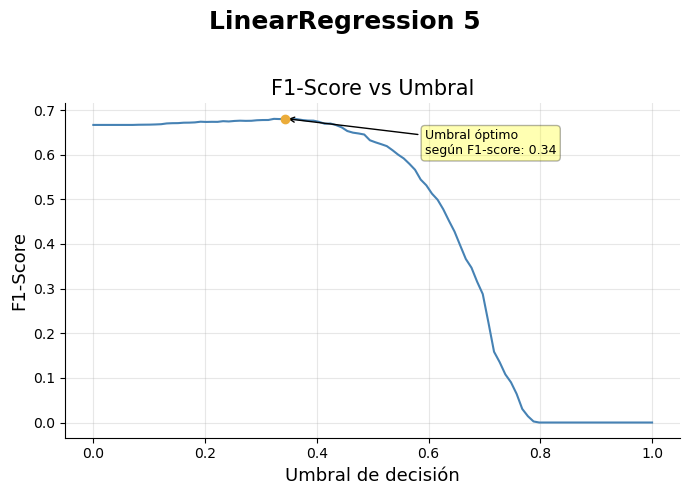

In [220]:
umbral_lr_5 = plot_umbrales(modelo=lr_5.best_estimator_,
                            score='F1-Score',
                            x=X_linear_cv[selected_features],
                            y=y_linear_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 5')

In [221]:
lr_5_results_umbral = metricas_evaluacion(modelo=lr_5.best_estimator_,
                                           x_test=X_linear_test[selected_features],
                                           y_test=y_linear_test,
                                           nombre='LogisticRegression 5',
                                           conjunto='X_linear[selected_features]',
                                           umbral=0.34)

lr_results_tracking.append(lr_5_results_umbral)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0  LogisticRegression 1                     X_linear    0.7493     0.5438   
1  LogisticRegression 1                     X_linear    0.6300     0.4204   
2  LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3  LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4  LogisticRegression 3                     X_scaled    0.7465     0.5385   
5  LogisticRegression 3                     X_scaled    0.5983     0.4009   
6  LogisticRegression 4                     X_linear    0.7651     0.5710   
7  LogisticRegression 4                     X_linear    0.4539     0.3318   
8  LogisticRegression 5  X_linear[selected_features]    0.7633     0.5657   
9  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   

   Recall  F1-score     AUC  Umbral  
0  0.5859    0.5640  0.8052    0.50  
1  0.8889    0.5708  0.8052    0.36  
2  0.5926    0.5752  0.8045    0.50  
3  0.8990    0.5711  0.8045    0.36  
4  0.5892    0.5627  0.7974    0.50  
5  0.9125    0.5570  0.7974    0.34  
6  0.6094    0.5896  0.8089    0.50  
7  0.9596    0.4931  0.8089    0.43  
8  0.6229    0.5929  0.8137    0.50  
9  0.9226    0.5738  0.8137    0.34

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 5 - GridSearchCV - Selected Features - Conjunto X_linear**</font>

Se seleccionaron las 12 variables con mayor impacto *(mayores coeficientes absolutos)* determinadas por `LogisticRegression 4` para simplificar el modelo:

* `Tenure`
* `InternetService_Fiber optic`
* `ChargesTotal`
* `PaymentMethod_Electronic check` 
* `ChargesMonthly`
* `PaperlessBilling_Yes` 
* `OnlineSecurity_Yes`
* `TechSupport_Yes`
* `Contract_One year`
* `SeniorCitizen_Yes`
* `Dependents_Yes`
* `Partner_Yes`

Esto, permitió que el modelo `LinearRegression 5` métricas superiores a las presentadas por el modelo que se consideró anteriormente como candidato a representate de la familia `LogisticRegression 3` ambos utilizando el mismo umbral:

|Modelo               | Conjunto                    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-----------------------------|-----------|-----------|-----------|-----------|----------|---------|
|LogisticRegression 1 |	X_linear	                | 0.6300	| 0.4204	| 0.8889	| 0.5708	| 0.8052   | 0.36    |
|LogisticRegression 3 |	X_scaled                    | 0.5983	| 0.4009	| 0.9125	| 0.5570	| 0.7974   | 0.34    |
|LogisticRegression 5 |	X_linear[selected_features]	| 0.6207	| 0.4164	| 0.9226	| 0.5738	| 0.8137   | 0.34    |


En todos los casos en los que se modificó el umbral de decisión para mejorar el **Recall**, se produce inevitablemente una disminución en la Precisión, sin embargo, el modelo `LogisticRegression 5` obtiene el **uno de los valores de Recall más altos hasta el momento**, con una precisión levemente más baja (**-0.4%**) en relación al modelo *(con umbral de decisión modificado)* con mejor **Precisión** `Logistic Regression 1` 

La capacidad de este de **identificar el 92.26% de los casos reales de abandono**, lo posiciona como una muy buena opción para representar esta familia.

Además, los modelos lineales como `Logistic Regression` son interpretables a partir de sus coeficientes, lo que permite evaluar cuál es el impacto de cada variable independiente en la variable dependiente.

### <font color='#f07c3e'>**LogisticRegression 6 - GridSearchCV: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

In [222]:
warnings.filterwarnings('error')

param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],     
    'max_iter': [100, 200, 500]
}

lr_6 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
                    param_grid=param_grid, 
                    scoring='recall',
                    cv=skf)

lr_6.fit(X_scaled_cv, y_scaled_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.1, 0.5, 1, 1.5, 2],
                         'max_iter': [100, 200, 500]},
             scoring='recall')

In [223]:
lr_6.best_params_

{'C': 1.5, 'max_iter': 100}

In [224]:
#lr_6 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=1.5, max_iter=100)

#lr_6.fit(X_scaled_cv, y_scaled_cv)

In [225]:
#lr_6_results = metricas_evaluacion(modelo=lr_6,
#                                   x_test=X_scaled_test,
#                                   y_test=y_linear_test,
#                                   nombre='LogisticRegression 6',
#                                   conjunto='X_scaled')

#lr_results_tracking.append(lr_6_results)
#pd.DataFrame(lr_results_tracking)

In [226]:
#umbral_lr_6 = plot_umbrales(modelo=lr_6,
#                            score='F1-Score',
#                            x=X_scaled_cv,
#                            y=y_scaled_cv,
#                            caja_x=0.25,
#                            caja_y=0.08,
#                            nombre='LinearRegression 6')

In [227]:
#lr_6_results_umbral = metricas_evaluacion(modelo=lr_6,
#                                           x_test=X_scaled_test,
#                                           y_test=y_scaled_test,
#                                           nombre='LogisticRegression 6',
#                                           conjunto='X_scaled',
#                                           umbral=0.27)

#lr_results_tracking.append(lr_6_results_umbral)
#pd.DataFrame(lr_results_tracking)

In [228]:
lr_6_results = metricas_evaluacion(modelo=lr_6.best_estimator_,
                                   x_test=X_scaled_test,
                                   y_test=y_linear_test,
                                   nombre='LogisticRegression 6',
                                   conjunto='X_scaled')

lr_results_tracking.append(lr_6_results)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0   LogisticRegression 1                     X_linear    0.7493     0.5438   
1   LogisticRegression 1                     X_linear    0.6300     0.4204   
2   LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3   LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4   LogisticRegression 3                     X_scaled    0.7465     0.5385   
5   LogisticRegression 3                     X_scaled    0.5983     0.4009   
6   LogisticRegression 4                     X_linear    0.7651     0.5710   
7   LogisticRegression 4                     X_linear    0.4539     0.3318   
8   LogisticRegression 5  X_linear[selected_features]    0.7633     0.5657   
9   LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
10  LogisticRegression 6                     X_scaled    0.7474     0.5401   

    Recall  F1-score     AUC  Umbral  
0   0.5859    0.5640  0.8052    0.50  
1   0.8889    0.5708  0.8052    0.36  
2   0.5926    0.5752  0.8045    0.50  
3   0.8990    0.5711  0.8045    0.36  
4   0.5892    0.5627  0.7974    0.50  
5   0.9125    0.5570  0.7974    0.34  
6   0.6094    0.5896  0.8089    0.50  
7   0.9596    0.4931  0.8089    0.43  
8   0.6229    0.5929  0.8137    0.50  
9   0.9226    0.5738  0.8137    0.34  
10  0.5892    0.5636  0.7977    0.50

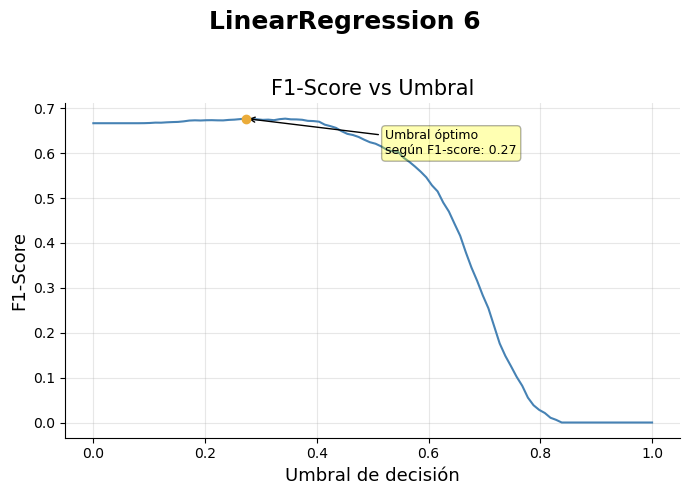

In [229]:
umbral_lr_6 = plot_umbrales(modelo=lr_6.best_estimator_,
                            score='F1-Score',
                            x=X_scaled_cv,
                            y=y_scaled_cv,
                            caja_x=0.25,
                            caja_y=0.08,
                            nombre='LinearRegression 6')

In [230]:
lr_6_results_umbral = metricas_evaluacion(modelo=lr_6.best_estimator_,
                                           x_test=X_scaled_test,
                                           y_test=y_scaled_test,
                                           nombre='LogisticRegression 6',
                                           conjunto='X_scaled',
                                           umbral=0.27)

lr_results_tracking.append(lr_6_results_umbral)
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0   LogisticRegression 1                     X_linear    0.7493     0.5438   
1   LogisticRegression 1                     X_linear    0.6300     0.4204   
2   LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3   LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4   LogisticRegression 3                     X_scaled    0.7465     0.5385   
5   LogisticRegression 3                     X_scaled    0.5983     0.4009   
6   LogisticRegression 4                     X_linear    0.7651     0.5710   
7   LogisticRegression 4                     X_linear    0.4539     0.3318   
8   LogisticRegression 5  X_linear[selected_features]    0.7633     0.5657   
9   LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
10  LogisticRegression 6                     X_scaled    0.7474     0.5401   
11  LogisticRegression 6                     X_scaled    0.5107     0.3571   

    Recall  F1-score     AUC  Umbral  
0   0.5859    0.5640  0.8052    0.50  
1   0.8889    0.5708  0.8052    0.36  
2   0.5926    0.5752  0.8045    0.50  
3   0.8990    0.5711  0.8045    0.36  
4   0.5892    0.5627  0.7974    0.50  
5   0.9125    0.5570  0.7974    0.34  
6   0.6094    0.5896  0.8089    0.50  
7   0.9596    0.4931  0.8089    0.43  
8   0.6229    0.5929  0.8137    0.50  
9   0.9226    0.5738  0.8137    0.34  
10  0.5892    0.5636  0.7977    0.50  
11  0.9596    0.5205  0.7977    0.27

In [231]:
lr_6_coef = pd.DataFrame({'Feature': X_scaled_cv.columns.values, 'Coeficiente': lr_6.best_estimator_.coef_[0]}).sort_values('Coeficiente', ascending=False)
lr_6_coef

Feature  Coeficiente
25                      ChargesTotal_scaled     0.320650
5                         MultipleLines_Yes     0.277333
1                         SeniorCitizen_Yes     0.268177
21           PaymentMethod_Electronic check     0.250455
24                    ChargesMonthly_scaled     0.248655
18                     PaperlessBilling_Yes     0.151513
17                        Contract_Two year     0.148769
13                          StreamingTV_Yes     0.148322
14                      StreamingMovies_Yes     0.112607
7               InternetService_Fiber optic     0.040236
2                               Partner_Yes     0.019842
0                               Gender_Male     0.008641
10                         OnlineBackup_Yes     0.005854
22               PaymentMethod_Mailed check     0.000000
11                     DeviceProtection_Yes     0.000000
16                        Contract_One year     0.000000
19  PaymentMethod_Bank transfer (automatic)    -0.012058
20    PaymentMethod_Credit card (automatic)    -0.023543
3                            Dependents_Yes    -0.073759
9                        OnlineSecurity_Yes    -0.090881
15                  Contract_Month-to-month    -0.107455
12                          TechSupport_Yes    -0.217561
8                         NoInternetService    -0.372978
6                       InternetService_DSL    -0.452835
4                          PhoneService_Yes    -0.505883
23                            Tenure_scaled    -1.652992

### <font color='#8b5fc4'>**Observaciones: LogisticRegression 6 - GridSearchCV: Penalty L1 (Lasso) - Conjunto X_scaled**</font>

El modelo `LogisticRegression 6` con penalidad L1 (Lasso), penaliza la excesiva complejidad del modelo, reduciendo a 0 los coeficientes de variables que considera tienen poco impacto en la predicción de la variable respuesta.
Las variables descartadas fueron:

* `PaymentMethod_Mailed check`
* `DeviceProtection_Yes`
* `Contract_One year`

Al modificar el umbral de decisión, obtiene el mismo **Recall** que `LogisticRegression 4` (**0.9596**), con una leve mejora en su **Precisión**, sin embargo, esta última sigue siendo demasiado baja, lo que se traduce, como se observó en dicho análisis, en costos innecesarios para la empresa.

In [232]:
pd.DataFrame(lr_results_tracking)

Model                      Dataset  Accuracy  Precision  \
0   LogisticRegression 1                     X_linear    0.7493     0.5438   
1   LogisticRegression 1                     X_linear    0.6300     0.4204   
2   LogisticRegression 2  X_linear[selected_features]    0.7577     0.5587   
3   LogisticRegression 2  X_linear[selected_features]    0.6263     0.4185   
4   LogisticRegression 3                     X_scaled    0.7465     0.5385   
5   LogisticRegression 3                     X_scaled    0.5983     0.4009   
6   LogisticRegression 4                     X_linear    0.7651     0.5710   
7   LogisticRegression 4                     X_linear    0.4539     0.3318   
8   LogisticRegression 5  X_linear[selected_features]    0.7633     0.5657   
9   LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
10  LogisticRegression 6                     X_scaled    0.7474     0.5401   
11  LogisticRegression 6                     X_scaled    0.5107     0.3571   

    Recall  F1-score     AUC  Umbral  
0   0.5859    0.5640  0.8052    0.50  
1   0.8889    0.5708  0.8052    0.36  
2   0.5926    0.5752  0.8045    0.50  
3   0.8990    0.5711  0.8045    0.36  
4   0.5892    0.5627  0.7974    0.50  
5   0.9125    0.5570  0.7974    0.34  
6   0.6094    0.5896  0.8089    0.50  
7   0.9596    0.4931  0.8089    0.43  
8   0.6229    0.5929  0.8137    0.50  
9   0.9226    0.5738  0.8137    0.34  
10  0.5892    0.5636  0.7977    0.50  
11  0.9596    0.5205  0.7977    0.27

## <font color='#ebac3a'>**Conclusiones Logistic Regresion**</font>

Los mejores candidatos de esta familia fueron:

|Modelo               | Conjunto                    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-----------------------------|-----------|-----------|-----------|-----------|----------|---------|
|LogisticRegression 1 |	X_linear	                | 0.6300	| 0.4204	| 0.8889	| 0.5708	| 0.8052   | 0.36    |
|LogisticRegression 3 |	X_scaled                    | 0.5983	| 0.4009	| 0.9125	| 0.5570	| 0.7974   | 0.34    |
|LogisticRegression 5 |	X_linear[selected_features]	| 0.6207	| 0.4164	| 0.9226	| 0.5738	| 0.8137   | 0.34    |

Entre ellos, se selecciona a `LogisticRegression 5` como el mejor representante de esta familia, debido a su elevado **Recall** *(métrica prioritaria)*. Además presenta el mejor valor de **AUC** *(área bajo la curva)* y **F1-score**.
Este, fue entrenado utilizando 12 features, que tambien se guardarán para las comparaciones finales entre modelos representantes de cada familia, con el objetivo de evaluar el mejor candidato para entornos productivos.

In [233]:
best_models.append(lr_5_results_umbral)
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34

In [234]:
with open(MODELS_PATH / 'best_logreg.pkl', 'wb') as f:
    pickle.dump(lr_5.best_estimator_, f)

In [235]:
with open(MODELS_PATH / 'features_best_logreg.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

## <font color='#ebac3a'>**K-Nearest Neighbors (KNN)**</font>

El modelo K-Nearest Neighbors (KNN) es un clasificador basado en la proximidad entre observaciones, utilizando por defecto la distancia euclídea como métrica.
Esto lo hace particularmente **sensible a la escala de las variables y a la presencia de outliers**, ya que estos pueden influir fuertemente en el cálculo de las distancias.

Además, el desempeño del modelo **depende fuertemente del parámetro k**, que define cuántos "vecinos" se consideran para determinar la clase de una nueva observación. Valores de k muy bajos pueden llevar a sobreajuste, mientras que valores demasiado altos pueden suavizar excesivamente las fronteras de decisión.

Debido a que KNN no aprende una función explícita durante el entrenamiento, sino que **realiza los cálculos de distancia** durante la predicción, se considera un modelo perezoso y relativamente costoso computacionalmente en grandes conjuntos de datos (si bien no es el caso ya que el conjunto de datos balanceado cuenta con aproximadamente 3300 observaciones).

Por estas razones, se realizará inicialmente una búsqueda de hiperparámetros mediante `GridSearchCV` para determinar el valor óptimo de k.

En cuanto al conjunto de datos, se utilizará `X_linear`, ya que además de ser sensible a escalas, este modelo no maneja bien la multicolinealidad.

In [236]:
knn_results_tracking = []

### <font color='#f07c3e'>**KNN 1: GridSearchCV - Conjunto X_linear**</font>

In [237]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [5, 10, 15, 20]}

knn_1 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=skf)

knn_1.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15, 20],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [238]:
knn_1.best_params_

{'leaf_size': 5, 'n_neighbors': 7}

In [239]:
#knn_1 = knn(leaf_size=5, n_neighbors=7)

#knn_1.fit(X_linear_cv, y_linear_cv)

In [240]:
#knn_1_results = metricas_evaluacion(modelo=knn_1,
#                                    x_test=X_linear_test,
#                                    y_test=y_linear_test,
#                                    nombre='KNN 1',
#                                    conjunto='X_linear')

#knn_results_tracking.append(knn_1_results)
#pd.DataFrame(knn_results_tracking)

In [241]:
#umbral_knn_1 = plot_umbrales(modelo=knn_1,
#                             score='F1-Score',
#                             x=X_linear_cv,
#                             y=y_linear_cv,
#                             caja_x=0.25,
#                             caja_y=0.08,
#                             nombre='KNN 1')

In [242]:
#knn_1_results_umbral = metricas_evaluacion(modelo=knn_1,
#                                    x_test=X_linear_test,
#                                    y_test=y_linear_test,
#                                    nombre='KNN 1',
#                                    conjunto='X_linear',
#                                    umbral=0.29)

#knn_results_tracking.append(knn_1_results_umbral)
#pd.DataFrame(knn_results_tracking)

In [243]:
knn_1_results = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear')

knn_results_tracking.append(knn_1_results)
pd.DataFrame(knn_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  KNN 1  X_linear    0.7251     0.5027  0.6364    0.5617  0.7513     0.5

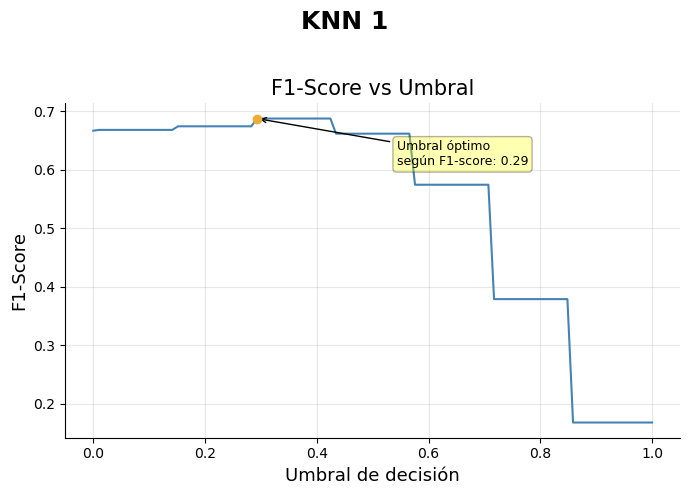

In [244]:
umbral_knn_1 = plot_umbrales(modelo=knn_1.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='KNN 1')

In [245]:
knn_1_results_umbral = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear',
                                    umbral=0.29)

knn_results_tracking.append(knn_1_results_umbral)
pd.DataFrame(knn_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  KNN 1  X_linear    0.7251     0.5027  0.6364    0.5617  0.7513    0.50
1  KNN 1  X_linear    0.6459     0.4278  0.8283    0.5642  0.7513    0.29

In [246]:
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34

### <font color='#8b5fc4'>**Observaciones: KNN 1 - GridSearchCV - Conjunto X_linear**</font>

El GridSearch determinó que los hiperparámetros óptimos para el modelo son:

* `leaf_size = 5`
* `n_neighbors = 7`

Este modelo consigue superar levemente el **Recall** de `RandomForest 5` (modelo seleccionado para representar dicha familia), pero con un **trade-off desfavorable**, ya que si bien se logra identificar más clientes que efectivamente abandonan (TP), la Precisión del modelo es aproximadamente **9%** más baja, muy similar a `LogisticRegression 5`, la cual cuenta con un **Recall aproximadamente 9% más elevado**.

Además, dado que **KNN realiza los cálculos de distancia en tiempo de predicción,** no es el modelo más adecuado para un entorno de producción donde se requiera velocidad de respuesta. Por lo que se realizará un último experimento con `K-Nearest Neighbors`, utilizando los hiperparámetros encontrados con `GridSearchCV`, esta vez utilizando **solo las variables seleccionadas por** `LogisticRegression 5`, que fueron determinadas como relevantes a través de sus coeficientes y utilizando un `GridSearchCV` más amplio. Esto permitirá evaluar si un conjunto reducido de variables mejora el desempeño general.

### <font color='#f07c3e'>**KNN 2: GridSearchCV - Conjunto X_linear - Selected Features**</font>

In [247]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [10, 15, 20, 25, 30]}

knn_2 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=skf)

knn_2.fit(X_linear_cv[selected_features], y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 15, 20, 25, 30],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [248]:
#knn_2 = knn(leaf_size=10, n_neighbors=3)

#knn_2.fit(X_linear_cv[selected_features], y_linear_cv)

In [249]:
#knn_2_results = metricas_evaluacion(modelo=knn_2,
#                                    x_test=X_linear_test[selected_features],
#                                    y_test=y_linear_test,
#                                    nombre='KNN 2',
#                                    conjunto='X_linear[selected_features]')

#knn_results_tracking.append(knn_2_results)
#pd.DataFrame(knn_results_tracking)

In [250]:
#umbral_knn_1 = plot_umbrales(modelo=knn_2,
#                             score='F1-Score',
#                             x=X_linear_cv[selected_features],
#                             y=y_linear_cv,
#                             caja_x=0.25,
#                             caja_y=0.08,
#                             nombre='KNN 2')

In [251]:
#knn_2_results_umbral = metricas_evaluacion(modelo=knn_2,
#                                           x_test=X_linear_test[selected_features],
#                                            y_test=y_linear_test,
#                                            nombre='KNN 2',
#                                            conjunto='X_linear[selected_features]',
#                                            umbral=0.33)

#knn_results_tracking.append(knn_2_results_umbral)
#pd.DataFrame(knn_results_tracking)

In [252]:
knn_2_results = metricas_evaluacion(modelo=knn_2.best_estimator_,
                                    x_test=X_linear_test[selected_features],
                                    y_test=y_linear_test,
                                    nombre='KNN 2',
                                    conjunto='X_linear[selected_features]')

knn_results_tracking.append(knn_2_results)
pd.DataFrame(knn_results_tracking)

Model                      Dataset  Accuracy  Precision  Recall  F1-score  \
0  KNN 1                     X_linear    0.7251     0.5027  0.6364    0.5617   
1  KNN 1                     X_linear    0.6459     0.4278  0.8283    0.5642   
2  KNN 2  X_linear[selected_features]    0.6897     0.4521  0.5724    0.5052   

      AUC  Umbral  
0  0.7513    0.50  
1  0.7513    0.29  
2  0.6888    0.50

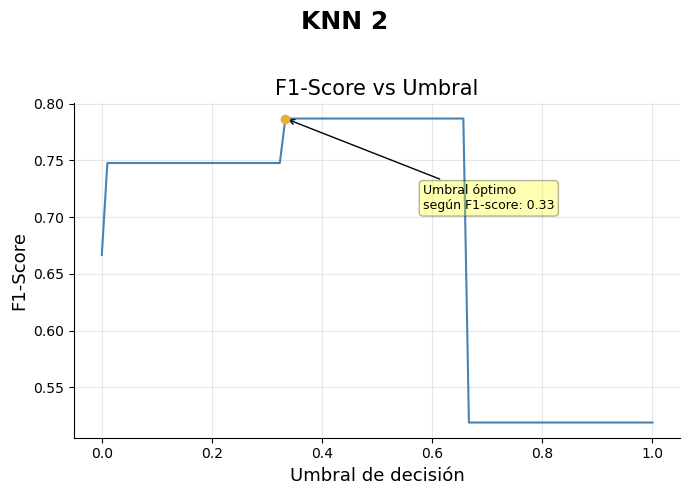

In [253]:
umbral_knn_1 = plot_umbrales(modelo=knn_2.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv[selected_features],
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='KNN 2')

In [254]:
knn_2_results_umbral = metricas_evaluacion(modelo=knn_2.best_estimator_,
                                    x_test=X_linear_test[selected_features],
                                    y_test=y_linear_test,
                                    nombre='KNN 2',
                                    conjunto='X_linear[selected_features]',
                                    umbral=0.33)

knn_results_tracking.append(knn_2_results_umbral)
pd.DataFrame(knn_results_tracking)

Model                      Dataset  Accuracy  Precision  Recall  F1-score  \
0  KNN 1                     X_linear    0.7251     0.5027  0.6364    0.5617   
1  KNN 1                     X_linear    0.6459     0.4278  0.8283    0.5642   
2  KNN 2  X_linear[selected_features]    0.6897     0.4521  0.5724    0.5052   
3  KNN 2  X_linear[selected_features]    0.4632     0.3250  0.8721    0.4735   

      AUC  Umbral  
0  0.7513    0.50  
1  0.7513    0.29  
2  0.6888    0.50  
3  0.6888    0.33

El modelo `KNN 2`, entrenado únicamente con las variables seleccionadas `por LogisticRegression 5`, presentó un desempeño inferior al anterior, ya que, si bien su **Recall** aumenta al modificar el umbral de decisión, el resto de métricas cae drásticamente.

Esto indica que reducir la dimensionalidad en el caso de KNN perjudica significativamente su desempeño, probablemente porque este tipo de modelo se beneficia de tener más dimensiones para calcular la distancia entre observaciones.

Sin embargo, `K-Nearest Neighbors` **no logró un rendimiento general competitivo**, pero aún así se lo conservará como el modelo representativo de esta familia para las comparaciones finales.

## <font color='#ebac3a'>**Conclusiones K-Nearest Neighbors (KNN)**</font>

El modelo **K-Nearest Neighbors** no consigue mejorar en las métricas de las familias anteriores. Especialmente en **Recall**, con aproximadamente 9% menor a la **Regresión Logística** seleccionada, con una **Precisión** similar


Dado que este modelo no consigue un buen desempeño y que también presenta desventajas computacionales para su implementación en producción, se concluye que no resulta ser una alternativa superadora frente a otras arquitecturas evaluadas.

Aún así, se conservará `KNN 1` para las evaluaciones finales.

In [255]:
best_models.append(knn_1_results_umbral)
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
3                 KNN 1                     X_linear    0.6459     0.4278   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34  
3  0.8283    0.5642  0.7513    0.29

In [256]:
with open(MODELS_PATH / 'best_knn.pkl', 'wb') as f:
    pickle.dump(knn_1.best_estimator_, f)

## <font color='#ebac3a'>**XGBoost Classifier**</font>

**XGBoost** es un algoritmo de machine learning basado en **árboles de decisión**. Construye múltiples árboles simples de forma **secuencial**, donde cada nuevo árbol intenta **corregir los errores** cometidos por los anteriores. De esta manera, cada iteración mejora progresivamente el desempeño del modelo.

Una de las razones por las que XGBoost es tan utilizado es que es **rápido**, **eficiente**, **maneja distintos tipos de datos** (incluyendo transformaciones automáticas mediante hiperparámetros), y suele lograr **muy buenos resultados**. Además, incluye múltiples mecanismos para **controlar el sobreajuste**, entre los cuales se destacan:

* **`max_depth`**: Limita la profundidad de los árboles, ayudando a evitar modelos demasiado complejos.
* **`min_child_weight`**: Controla la cantidad mínima de observaciones necesarias para dividir una hoja; al aumentarlo, se evita que el modelo haga divisiones poco significativas.
* **`reg_alpha` (L1 regularization)**: Penaliza el uso excesivo de variables, ayudando a simplificar el modelo.
* **`early_stopping`**: Detiene el entrenamiento si la métrica de evaluación (como **binary log loss**) no mejora luego de un número determinado de iteraciones.
* **`learning_rate`** (también `eta`): Controla el tamaño del paso de actualización. Un valor más bajo hace que el modelo aprenda más lentamente, pero reduce el riesgo de sobreajuste.

Además, este modelo es robusto frente al manejo de escalas y outliers, por lo que no es necesario reescalar las variables.

In [257]:
xgb_results_tracking = []

### <font color='#f07c3e'>**XGB Classifier 1 - Max Depth = 10 - Conjunto X**</font>

### ***Nota:***

Dado que XGBoost ofrece una gran cantidad de hiperparámetros que pueden ajustarse, se comenzará con un modelo base utilizando algunos valores por defecto (exceptuando max_depth, que se establece en 10). Luego, se aplicará GridSearchCV para optimizar algunos de los hiperparámetros más relevantes en función del problema y la métrica prioritaria (recall).

In [258]:
xgb_1 = XGBClassifier(max_depth=10, random_state=42, early_stopping_rounds=5, eval_metric='logloss')

xgb_1.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [259]:
xgb_1_results = metricas_evaluacion(modelo=xgb_1,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 1',
                                    conjunto='X')




xgb_results_tracking.append(xgb_1_results)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X      0.74     0.5232  0.6835    0.5927  0.7923   

   Umbral  
0     0.5

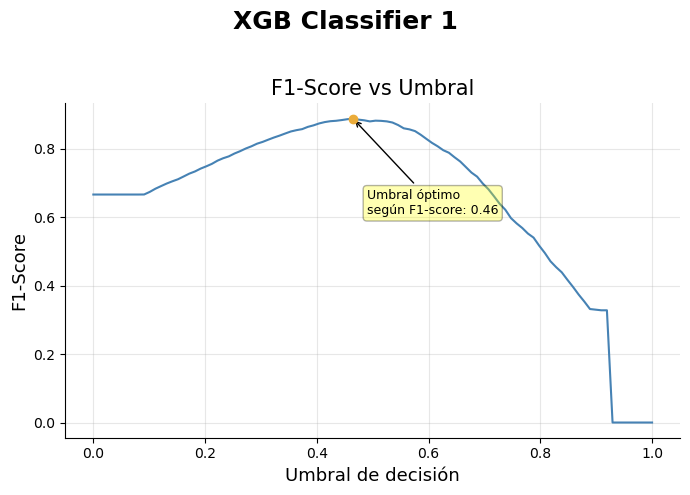

In [260]:
umbral_xgb_1 = plot_umbrales(modelo=xgb_1,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=0.025,
                             caja_y=0.28,
                             nombre='XGB Classifier 1')

In [261]:
xgb_1_results_umbral = metricas_evaluacion(modelo=xgb_1,
                                            x_test=X_test,
                                            y_test=y_test,
                                            nombre='XGB Classifier 1',
                                            conjunto='X',
                                            umbral=0.46)




xgb_results_tracking.append(xgb_1_results_umbral)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X    0.7400     0.5232  0.6835    0.5927  0.7923   
1  XGB Classifier 1       X    0.7251     0.5023  0.7475    0.6008  0.7923   

   Umbral  
0    0.50  
1    0.46

### <font color='#8b5fc4'>**Observaciones: XGB Classifier 1 - Max depth = 10 - Conjunto X**</font>

El modelo `XGB Classifier 1` (base de esta familia) muestra una estabilidad similar a la familia de **Random Forest**, donde los valores de **Recall** no son tan elevados, pero la precisión se mantiene por encima de **0.5**.

Al modificar el umbral de decisión, se obtiene una mejora de aproximadamente **5.4%** con un trade-off en **Precisión** de **2.09%**, lo cual resulta aceptable ya que la mejora en sensibilidad rempresenta más del doble de la caida en precisión.

A continuación se realizará un `GridSearchCV` con el objetivo de optimizar los hiperparámetros del modelo, en busca de mejorar sus métricas.

### <font color='#f07c3e'>**XGB Classifier 2 - GridSearchCV - Conjunto X**</font>

In [262]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_child_weight': [2, 5],
    'reg_alpha': [0.8, 1.0, 1.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'learning_rate': [0.001, 0.01, 0.1]
}


xgb_gs = XGBClassifier(random_state=42, early_stopping_rounds=5, eval_metric='logloss', n_estimators=1000)

xgb_2 = GridSearchCV(xgb_gs, param_grid=param_grid, scoring='recall', cv=skf)

fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

xgb_2.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_t...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.2, 0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [10, 15, 20], 'min_child_weight': [2, 5],
                         'reg_alpha': [0.8, 1.0, 1.2]},
             scoring='recall')

In [263]:
xgb_2.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 2,
 'reg_alpha': 1.0}

In [264]:
#xgb_2 = XGBClassifier(random_state=42, early_stopping_rounds=5, eval_metric='logloss', n_estimators=1000,
#                     gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=2, reg_alpha=1.0)

#fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

#xgb_2.fit(X_train, y_train, **fit_params)

In [265]:
#xgb_2_results = metricas_evaluacion(modelo=xgb_2,
#                                    x_test=X_test,
#                                    y_test=y_test,
#                                    nombre='XGB Classifier 2',
#                                    conjunto='X')

#xgb_results_tracking.append(xgb_2_results)
#pd.DataFrame(xgb_results_tracking)

In [266]:
#umbral_xgb_2 = plot_umbrales(modelo=xgb_2,
#                             score='F1-Score',
#                             x=X_train,
#                             y=y_train,
#                             caja_x=-0.1,
#                             caja_y=0.28,
#                             nombre='XGB Classifier 2')

In [267]:
#xgb_2_results_umbral = metricas_evaluacion(modelo=xgb_2,
#                                    x_test=X_test,
#                                    y_test=y_test,
#                                    nombre='XGB Classifier 2',
#                                    conjunto='X',
#                                    umbral=0.45)

#xgb_results_tracking.append(xgb_2_results_umbral)
#pd.DataFrame(xgb_results_tracking)

In [268]:
xgb_2_results = metricas_evaluacion(modelo=xgb_2.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 2',
                                    conjunto='X')

xgb_results_tracking.append(xgb_2_results)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X    0.7400     0.5232  0.6835    0.5927  0.7923   
1  XGB Classifier 1       X    0.7251     0.5023  0.7475    0.6008  0.7923   
2  XGB Classifier 2       X    0.7549     0.5455  0.6869    0.6080  0.8054   

   Umbral  
0    0.50  
1    0.46  
2    0.50

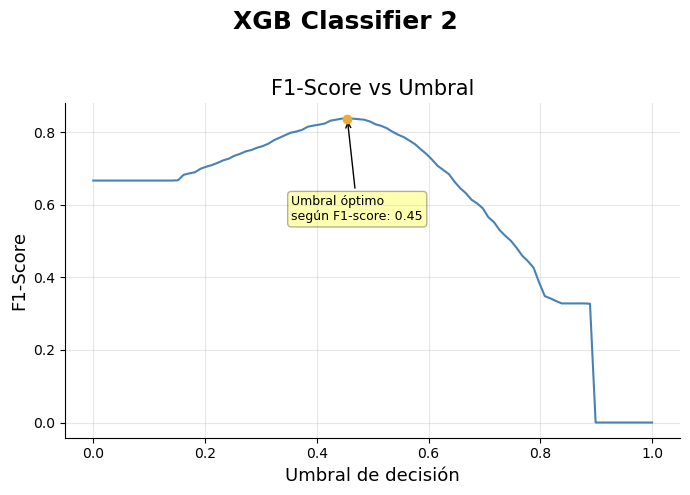

In [269]:
umbral_xgb_2 = plot_umbrales(modelo=xgb_2.best_estimator_,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=-0.1,
                             caja_y=0.28,
                             nombre='XGB Classifier 2')

In [270]:
xgb_2_results_umbral = metricas_evaluacion(modelo=xgb_2.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 2',
                                    conjunto='X',
                                    umbral=0.45)




xgb_results_tracking.append(xgb_2_results_umbral)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X    0.7400     0.5232  0.6835    0.5927  0.7923   
1  XGB Classifier 1       X    0.7251     0.5023  0.7475    0.6008  0.7923   
2  XGB Classifier 2       X    0.7549     0.5455  0.6869    0.6080  0.8054   
3  XGB Classifier 2       X    0.7288     0.5066  0.7744    0.6125  0.8054   

   Umbral  
0    0.50  
1    0.46  
2    0.50  
3    0.45

### <font color='#8b5fc4'>**Observaciones: XGB Classifier 2 - GridSearchCV - n_estimators=1000, early_stopping=5**</font>

El ajuste de los hiperparámetros inicialmente produce una leve mejora en todas las métricas del modelo:

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|XGB Classifier 1	  | X	        | 0.7400	| 0.5232	| 0.6835	| 0.5927	| 0.7923   | 0.50    |
|XGB Classifier 2	  | X	        | 0.7549	| 0.5455	| 0.6869	| 0.6080	| 0.8054   | 0.50    |


Utilizado el umbral de decisión óptimo determinado por la métrica F1-Score, esta diferencia se hace más notable:


|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|XGB Classifier 1	  | X	        | 0.7251	| 0.5023	| 0.7475	| 0.6008	| 0.7923   | 0.46    |
|XGB Classifier 2	  | X	        | 0.7288	| 0.5066	| 0.7744	| 0.6125	| 0.8054   | 0.45    |

Se sigue observando la estabilidad que presentan los modelos con arquitecturas de árbol. Los valores observados en **Recall** no alcanzan los niveles obtenidos por el modelo de **Regresión Logística**, sin embargo, este tipo de arquitectura incurre en menor cantidad de errores positivos, es decir, clasifica menos cantida de clientes que no abandonan como evasión (`Churn=1`).

Sin embargo, a pesar de ser un modelo que suele mostrar muy buen desempeño, el ajuste de hiperparámetros de `XGB Classifier 2` no consigue superar al modelo representativo de la anterior familia con arquitectura de árboles.

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|RandomForest 5	      | X	        | 0.7409	| 0.5208	| 0.8013	| 0.6313	| 0.8326   | 0.44    |
|XGB Classifier 2	  | X	        | 0.7288	| 0.5066	| 0.7744	| 0.6125	| 0.8054   | 0.45    |

### <font color='#f07c3e'>**XGB Classifier 3 - GridSearchCV - n_estimators=2000, early_stopping=10**</font>

In [271]:
param_grid = {
    'max_depth': [6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1]
}



xgb_gs = XGBClassifier(n_estimators=2000, early_stopping_rounds=10, eval_metric='logloss', random_state=42)

fit_params = {"eval_set": [(X_val, y_val)], "verbose": False}

xgb_3 = GridSearchCV(estimator=xgb_gs, param_grid=param_grid, scoring='recall', cv=skf)

xgb_3.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=2000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 10, 15],
                         'min_child_weight': [1, 3, 5],
                         'reg_alpha': [0, 0.5, 1],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='recall')

In [272]:
xgb_3.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'reg_alpha': 0,
 'subsample': 0.8}

In [273]:
#xgb_3 = XGBClassifier(n_estimators=2000, early_stopping_rounds=10, eval_metric='logloss', random_state=42, colsample_bytree=0.6,
#                      gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, reg_alpha=0, subsample=0.8)

#fit_params = {"eval_set": [(X_val, y_val)], "verbose": False}

#xgb_3.fit(X_train, y_train, **fit_params)


In [274]:
#xgb_3_results = metricas_evaluacion(modelo=xgb_3,
#                                    x_test=X_test,
#                                    y_test=y_test,
#                                    nombre='XGB Classifier 3',
#                                    conjunto='X')

#xgb_results_tracking.append(xgb_3_results)
#pd.DataFrame(xgb_results_tracking)

In [275]:
#umbral_xgb_3 = plot_umbrales(modelo=xgb_3,
#                             score='F1-Score',
#                             x=X_train,
#                             y=y_train,
#                             caja_x=-0.1,
#                             caja_y=0.28,
#                             nombre='XGB Classifier 3')

In [276]:
#xgb_3_results_umbral = metricas_evaluacion(modelo=xgb_3,
#                                            x_test=X_test,
#                                            y_test=y_test,
#                                            nombre='XGB Classifier 3',
#                                            conjunto='X',
#                                            umbral=0.43)

#xgb_results_tracking.append(xgb_3_results_umbral)
#pd.DataFrame(xgb_results_tracking)

In [277]:
xgb_3_results = metricas_evaluacion(modelo=xgb_3.best_estimator_,
                                    x_test=X_test,
                                    y_test=y_test,
                                    nombre='XGB Classifier 3',
                                    conjunto='X')

xgb_results_tracking.append(xgb_3_results)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X    0.7400     0.5232  0.6835    0.5927  0.7923   
1  XGB Classifier 1       X    0.7251     0.5023  0.7475    0.6008  0.7923   
2  XGB Classifier 2       X    0.7549     0.5455  0.6869    0.6080  0.8054   
3  XGB Classifier 2       X    0.7288     0.5066  0.7744    0.6125  0.8054   
4  XGB Classifier 3       X    0.7568     0.5464  0.7138    0.6190  0.8188   

   Umbral  
0    0.50  
1    0.46  
2    0.50  
3    0.45  
4    0.50

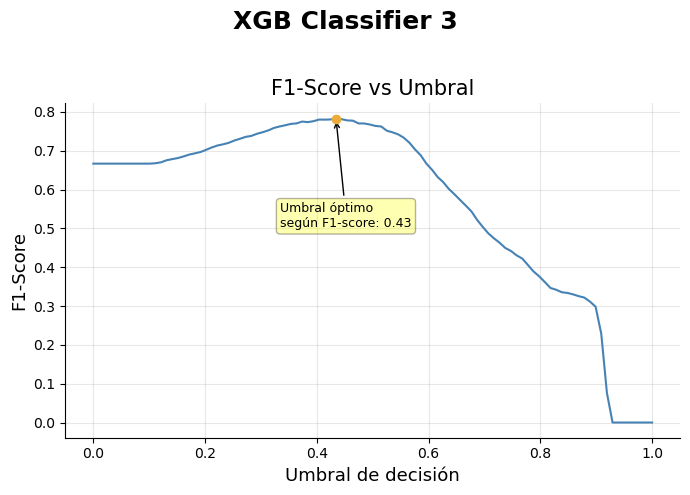

In [278]:
umbral_xgb_3 = plot_umbrales(modelo=xgb_3.best_estimator_,
                             score='F1-Score',
                             x=X_train,
                             y=y_train,
                             caja_x=-0.1,
                             caja_y=0.28,
                             nombre='XGB Classifier 3')

In [279]:
xgb_3_results_umbral = metricas_evaluacion(modelo=xgb_3.best_estimator_,
                                            x_test=X_test,
                                            y_test=y_test,
                                            nombre='XGB Classifier 3',
                                            conjunto='X',
                                            umbral=0.43)

xgb_results_tracking.append(xgb_3_results_umbral)
pd.DataFrame(xgb_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  XGB Classifier 1       X    0.7400     0.5232  0.6835    0.5927  0.7923   
1  XGB Classifier 1       X    0.7251     0.5023  0.7475    0.6008  0.7923   
2  XGB Classifier 2       X    0.7549     0.5455  0.6869    0.6080  0.8054   
3  XGB Classifier 2       X    0.7288     0.5066  0.7744    0.6125  0.8054   
4  XGB Classifier 3       X    0.7568     0.5464  0.7138    0.6190  0.8188   
5  XGB Classifier 3       X    0.7307     0.5085  0.8047    0.6232  0.8188   

   Umbral  
0    0.50  
1    0.46  
2    0.50  
3    0.45  
4    0.50  
5    0.43

In [280]:
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
3                 KNN 1                     X_linear    0.6459     0.4278   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34  
3  0.8283    0.5642  0.7513    0.29

### <font color='#8b5fc4'>**Observaciones: XGB Classifier 3 - GridSearchCV - n_estimators=2000, early_stopping=10**</font>

Esta segunda exploración con GridSearchCV, presentó mejoras en todas las métricas, especialmente en la métrica prioritaria (**Recall**)

```
param_grid = {
    'max_depth': [6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'learning_rate': [0.01, 0.05, 0.1]
}
```
Los hiperparámetros seleccionados como óptimos fueron:

* `max_depth=6`: controla la profundidad de los árboles
* `min_child_weight=1`: cantidad mínima de peso necesaria para dividir un nodo. Mientras más alto, más complejo es el modelo y menos sobreajuste. Sin embargo, GridSearch utilizó el valor mínimo ofrecido.
* `gamma=0.1`: ganancia mínima para hacer una división (reducción de la función objetivo, en este caso, `logloss`
* `subsample=0.8`: porcentaje de muestras de entrenamiento usadas por cada arbol. Esto ayuda a introducir aleatoriedad, ya que el modelo selecciona al azar, para este caso, 80% de las observaciones del conjunto de entrenamiento.
* `colsample_bytree=0.6`: porcentaje de columnas utilizadas por cada arbol. `XGB Classifier 3` al entrenar utilizó el 60% de las columnas presentes en el conjunto X_train.
* `reg_alpha=0`: penaliza el uso excesivo de variables, llevando los coeficientes de aquellas que considera irrelevantes a 0.
* `learning_rate=0.1`: variación en los parámetros del modelo por cada iteración de entrenamiento.

Esta configuración, permitió al modelo `XGB Classifier 3` obtener un resultado similar a `RandomForest 5`:

|Modelo               | Conjunto    | Accuracy  | Precision | Recall    | F1-Score  | AUC      | Umbral  |
|---------------------|-------------|-----------|-----------|-----------|-----------|----------|---------|
|RandomForest 5	      | X	        | 0.7409	| 0.5208	| 0.8013	| 0.6313	| 0.8326   | 0.44    |
|XGB Classifier 3	  | X	        | 0.7307	| 0.5085	| 0.8047	| 0.6232	| 0.8188   | 0.43    |

Por lo que este se conservará como representante de esta familia.

## <font color='#ebac3a'>**Conclusiones XGBoost Classifier**</font>

A pesar de su complejidad y buen rendimiento en otros contextos, el modelo `XGBoost Classifier` **no demostró un desempeño superior** en el problema en cuestión en relación a los otros modelos.

Si bien en esencia opera mediante **árboles de decisión**, por lo que su comportamiento fue similar al de `Random Forest Classifier`, se observó que la **complejidad agregada no aporta mejoras significativas en la capacidad del modelo para separar las clases** de manera efectiva. 

Una posible razón puede ser la limitada cantidad de datos disponibles, lo que dificulta al modelo para aprender patrones complejos en los datos.

Como se mencionó anteriormente: cuando no es necesario agregar complejidad, **no debemos hacerlo**.  
**Keep it simple.**

In [281]:
best_models.append(xgb_3_results_umbral)
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
3                 KNN 1                     X_linear    0.6459     0.4278   
4      XGB Classifier 3                            X    0.7307     0.5085   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34  
3  0.8283    0.5642  0.7513    0.29  
4  0.8047    0.6232  0.8188    0.43

In [282]:
try:
    with open(MODELS_PATH / 'best_xgb.pkl', 'wb') as f:
        pickle.dump(xgb_3.best_estimator_, f)
except Exception as e:
    with open(MODELS_PATH / 'best_xgb.pkl', 'wb') as f:
        pickle.dump(xgb_3, f)

## <font color='#ebac3a'>**Support Vector Machine**</font>

**Support Vector Machine (SVM)** es un algoritmo supervisado que busca encontrar la **frontera de decisión óptima** que **separe las clases** de un conjunto de datos, maximizando la **distancia (margen)** entre dicha frontera y los puntos más cercanos de cada clase, llamados **vectores de soporte**.

Aunque se basa en distancias, **la frontera de decisión no depende de todos los puntos**, sino **solo de aquellos vectores de soporte**. Cuanto **más amplio sea el margen**, mejor será la capacidad de **generalización** del modelo; sin embargo, esto puede generar **errores de clasificación**. Por el contrario, **márgenes más estrechos** pueden sobreajustarse al conjunto de entrenamiento.

El **parámetro `C`** controla este equilibrio:
* Un `C` **alto** penaliza fuertemente los errores → modelo más estricto, menor margen, mayor riesgo de sobreajuste.
* Un `C` **bajo** permite más errores → modelo más permisivo, mayor margen, posible subajuste.

Además, **SVM permite transformar los datos automáticamente** mediante el uso de **funciones kernel**, con el objetivo de encontrar **una frontera lineal en un espacio transformado**, incluso si los datos no son separables linealmente en su espacio original.

In [283]:
svm_results_tracking = []

### <font color='#f07c3e'>**SVM 1 - kernel = sigmoid**</font>

In [284]:
#from sklearn.calibration import CalibratedClassifierCV

svm_1 = SVC(kernel='sigmoid', gamma='auto', C=1.0, random_state=42, probability=True)

svm_1_cv_results = cross_validate(svm_1, X_scaled_cv, y_scaled_cv, cv=skf)

In [285]:
cv_score_interval(svm_1_cv_results, nombre='SVM 1', score='Recall')

Recall promedio de SVM 1: 0.6062
Desviación estándar del Recall de SVM 1: 0.0301
El Recall de SVM 1 estará entre [0.5460,0.6664] con un 95% de confianza


In [286]:
svm_1.fit(X_scaled_cv, y_scaled_cv)

SVC(gamma='auto', kernel='sigmoid', probability=True, random_state=42)

In [287]:
svm_1_results = metricas_evaluacion(modelo=svm_1,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 1',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_1_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled     0.753      0.553  0.5623    0.5576  0.7918     0.5

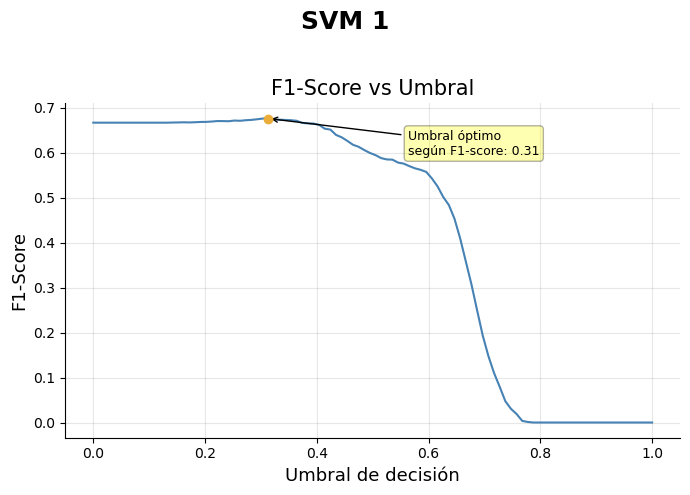

In [288]:
umbral_svm_1 = plot_umbrales(modelo=svm_1,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 1')

In [289]:
svm_1_results_umbral = metricas_evaluacion(modelo=svm_1,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 1',
                                            conjunto='X_scaled',
                                            umbral=0.31)

svm_results_tracking.append(svm_1_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7530     0.5530  0.5623    0.5576  0.7918    0.50
1  SVM 1  X_scaled    0.5098     0.3563  0.9562    0.5192  0.7918    0.31

### <font color='#8b5fc4'>**Observaciones: SVM 1 - kernel=sigmoid**</font>

El primer modelo `Support Vector Machine` fue entrenado utilizando el **kernel de tipo `sigmoid`**, obteniendo los siguientes resultados: 


| Modelo     | Conjunto    | Accuracy | Precision  | Recall   |F1-score   | AUC    | Umbral |
|------------|-------------|----------|------------|----------|-----------|--------|--------|
| SVM 1	     | X_scaled	   | 0.7530	  | 0.5530	   | 0.5623	  | 0.5576	  | 0.7918 | 0.50   |

Al modificar su umbral de decisión en el punto óptimo determinado por la métrica **F1-Score** sobre los datos de entrenamiento, se obtiene:

| Modelo     | Conjunto    | Accuracy | Precision  | Recall   |F1-score   | AUC    | Umbral |
|------------|-------------|----------|------------|----------|-----------|--------|--------|
| SVM 1      | X_scaled	   | 0.5098	  | 0.3563	   | 0.9562	  | 0.5192	  | 0.7918 | 0.31   |

Si bien la métrica prioritaria (**Recall**) resulta altamente competitiva, se observa una fuerte disminución en Accuracy y Precision, esto indica que el modelo alcanza un desempeño óptimo para su consideración como representante de la familia.
A continuación se llevará a cabo una búsqueda de hiperparámetros (`GridSearchCV`) para encontrar una **combinación óptima de `kernel`, `C` y `gamma`**, con el objetivo de mejorar tanto la sensibilidad como el equilibrio general del modelo.

### <font color='#f07c3e'>**SVM 2 - GridSearchCV - Conjunto X_scaled**</font>

In [290]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_2 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_2.fit(X_scaled_cv, y_scaled_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

In [291]:
svm_2.best_params_

{'C': 2.0, 'gamma': 'auto', 'kernel': 'sigmoid'}

In [292]:
#svm_2 = SVC(random_state=42, probability=True, C=2.0, gamma='auto', kernel='sigmoid')

#svm_2.fit(X_scaled_cv, y_scaled_cv)

In [293]:
#svm_2_results = metricas_evaluacion(modelo=svm_2,
#                                    x_test=X_scaled_test,
#                                    y_test=y_scaled_test,
#                                    nombre='SVM 2',
#                                    conjunto='X_scaled')

#svm_results_tracking.append(svm_2_results)
#pd.DataFrame(svm_results_tracking)

In [294]:
#umbral_svm_2 = plot_umbrales(modelo=svm_2,
#                             score='F1-Score',
#                             x=X_scaled_cv,
#                             y=y_scaled_cv,
#                             caja_x=0.25,
#                             caja_y=0.08,
#                             nombre='SVM 2')

In [295]:
#svm_2_results_umbral = metricas_evaluacion(modelo=svm_2,
#                                            x_test=X_scaled_test,
#                                            y_test=y_scaled_test,
#                                            nombre='SVM 2',
#                                            conjunto='X_scaled',
#                                            umbral=0.12)

#svm_results_tracking.append(svm_2_results_umbral)
#pd.DataFrame(svm_results_tracking)

In [296]:
svm_2_results = metricas_evaluacion(modelo=svm_2.best_estimator_,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 2',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_2_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7530     0.5530  0.5623    0.5576  0.7918    0.50
1  SVM 1  X_scaled    0.5098     0.3563  0.9562    0.5192  0.7918    0.31
2  SVM 2  X_scaled    0.7064     0.4750  0.5758    0.5205  0.7190    0.50

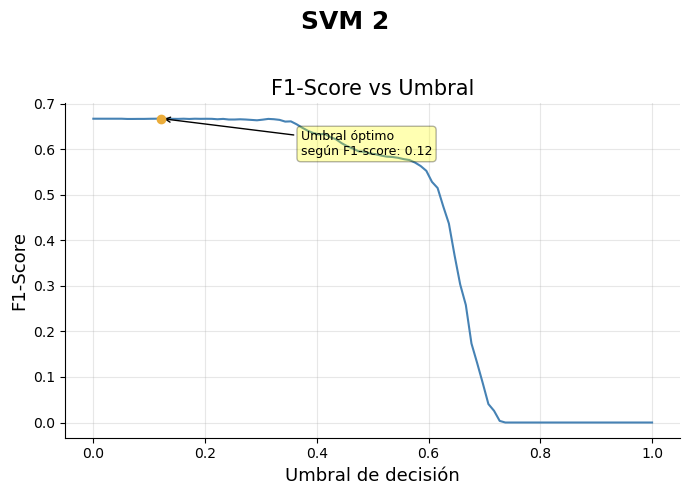

In [297]:
umbral_svm_2 = plot_umbrales(modelo=svm_2.best_estimator_,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 2')

In [298]:
svm_2_results_umbral = metricas_evaluacion(modelo=svm_2,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 2',
                                            conjunto='X_scaled',
                                            umbral=0.12)

svm_results_tracking.append(svm_2_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7530     0.5530  0.5623    0.5576  0.7918    0.50
1  SVM 1  X_scaled    0.5098     0.3563  0.9562    0.5192  0.7918    0.31
2  SVM 2  X_scaled    0.7064     0.4750  0.5758    0.5205  0.7190    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7190    0.12

### <font color='#8b5fc4'>**Observaciones: SVM 2 - GridSearchCV - Conjunto X_scaled**</font>

Inicialmente es posible observar que el ajuste en los hiperparámetros produjo una disminución en todas las métricas excepto por una leve mejora en **Recall**.

El modelo muestra un valor de **AUC** aproximadamente **7.3% más bajo**. Lo que indica que este no es capaz de separar las clases desbalanceadas mejor que el modelo anterior.

Además, el umbral de decisión que maximiza la métrica F1-score en los datos de entrenamiento (clases balanceadas) es extremadamente bajo, lo que hace que, para identificar casi el 100% de clientes que abandonan, la capacidad del modelo de identificar correctamente a los clientes que no planean abandonar la empresa se reduzca demasiado.

### <font color='#f07c3e'>**SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear**</font>

Se entrenará un tercer modelo de esta familia utilizando el conjunto X_linear, y forzando el uso de `kernel=linear`. Ya que al trabajar con distancia, este modelo puede entrar en conflictos al manejar la multicolinealidad presente en el conjunto `X_scaled` donde se utilizo una codificación `one_hot_encoder(drop='if_binary')`.

In [299]:
param_grid = {
    'kernel': ['linear'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_3 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_3.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear']},
             scoring='recall')

In [300]:
svm_3.best_params_

{'C': 2.0, 'gamma': 'auto', 'kernel': 'linear'}

In [301]:
#svm_3 = SVC(random_state=42, probability=True, C=2.0, gamma='auto', kernel='linear')

#svm_3.fit(X_linear_cv, y_linear_cv)

In [302]:
#svm_3_results = metricas_evaluacion(modelo=svm_3,
#                                    x_test=X_linear_test,
#                                    y_test=y_linear_test,
#                                    nombre='SVM 3',
#                                    conjunto='X_linear')

#svm_results_tracking.append(svm_3_results)
#pd.DataFrame(svm_results_tracking)

In [303]:
#umbral_svm_3 = plot_umbrales(modelo=svm_3,
#                             score='F1-Score',
#                             x=X_linear_cv,
#                             y=y_linear_cv,
#                             caja_x=0.25,
#                             caja_y=0.08,
#                             nombre='SVM 3')

In [304]:
#svm_3_results_umbral = metricas_evaluacion(modelo=svm_3,
#                                            x_test=X_linear_test,
#                                            y_test=y_linear_test,
#                                            nombre='SVM 3',
#                                            conjunto='X_linear',
#                                            umbral=0.33)

#svm_results_tracking.append(svm_3_results_umbral)
#pd.DataFrame(svm_results_tracking)

In [305]:
svm_3_results = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='SVM 3',
                                    conjunto='X_linear')

svm_results_tracking.append(svm_3_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7530     0.5530  0.5623    0.5576  0.7918    0.50
1  SVM 1  X_scaled    0.5098     0.3563  0.9562    0.5192  0.7918    0.31
2  SVM 2  X_scaled    0.7064     0.4750  0.5758    0.5205  0.7190    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7190    0.12
4  SVM 3  X_linear    0.7540     0.5563  0.5488    0.5525  0.8073    0.50

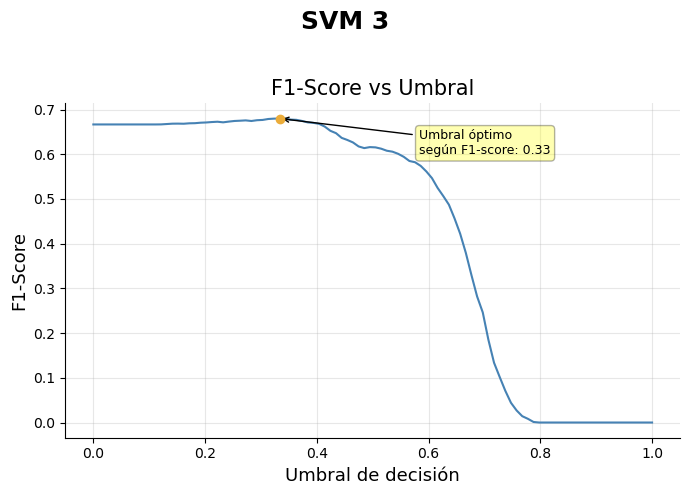

In [306]:
umbral_svm_3 = plot_umbrales(modelo=svm_3.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 3')

In [307]:
svm_3_results_umbral = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                            x_test=X_linear_test,
                                            y_test=y_linear_test,
                                            nombre='SVM 3',
                                            conjunto='X_linear',
                                            umbral=0.33)

svm_results_tracking.append(svm_3_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7530     0.5530  0.5623    0.5576  0.7918    0.50
1  SVM 1  X_scaled    0.5098     0.3563  0.9562    0.5192  0.7918    0.31
2  SVM 2  X_scaled    0.7064     0.4750  0.5758    0.5205  0.7190    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7190    0.12
4  SVM 3  X_linear    0.7540     0.5563  0.5488    0.5525  0.8073    0.50
5  SVM 3  X_linear    0.5881     0.3960  0.9293    0.5553  0.8073    0.33

In [308]:
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
3                 KNN 1                     X_linear    0.6459     0.4278   
4      XGB Classifier 3                            X    0.7307     0.5085   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34  
3  0.8283    0.5642  0.7513    0.29  
4  0.8047    0.6232  0.8188    0.43

### <font color='#8b5fc4'>**Observaciones: SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear**</font>

El modelo `SVM 3` consigue superar al resto de modelos dentro de esta familia.

Se comprueba que al utilizar el conjunto `X_linear`, este se beneficia de la codificación `one_hot_encoder(drop='first')`, la cual evita la introducción manual de multicolinealidad al conjunto de datos.

Aún así, este no consigue mejorar la estabilidad presente en las otras familias de algoritmos, como `Random Forest` y `Linear Regression`.

## <font color='#ebac3a'>**Conclusiones Support Vector Machine**</font>

El algoritmo de **Support Vector Machine** consiguió alcanzar el **Recall** más alto entre todos los modelos entrenados. Utilizando los hiperparámetros adecuados, y un conjunto de datos preprocesado apropiadamente para dicho modelo, este logra maximizar la métrica prioritaria para el problema de negocios, aún manteniendo una buena estabilidad en términos generales.

Sin embargo, la **Precisión** del mismo cae por debajo de 0.4, lo cual puede resultar en la destinación de recursos a un sector de clientes que realmente no necesita ser intervenido. 

Como representante de esta famlia, se tomará el modelo `SVM 3`.

In [309]:
best_models.append(svm_3_results_umbral)
pd.DataFrame(best_models)

Model                      Dataset  Accuracy  Precision  \
0        Baseline Model                            X    0.6915     0.4663   
1        RandomForest 5                            X    0.7409     0.5208   
2  LogisticRegression 5  X_linear[selected_features]    0.6207     0.4164   
3                 KNN 1                     X_linear    0.6459     0.4278   
4      XGB Classifier 3                            X    0.7307     0.5085   
5                 SVM 3                     X_linear    0.5881     0.3960   

   Recall  F1-score     AUC  Umbral  
0  0.7912    0.5868  0.7418    0.41  
1  0.8013    0.6313  0.8326    0.44  
2  0.9226    0.5738  0.8137    0.34  
3  0.8283    0.5642  0.7513    0.29  
4  0.8047    0.6232  0.8188    0.43  
5  0.9293    0.5553  0.8073    0.33

In [310]:
try:
    with open(MODELS_PATH / 'best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3.best_estimator_, f)
except Exception:
    with open(MODELS_PATH / 'best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3, f)

# <font color='#5a9bd4'>**5. Evaluación Best Models**</font>

A continuación se llevarán a cabo distintas evaluaciones sobre los modelos seleccionados como representantes de cada familia.

El objetivo es analizar distintos aspectos del desempeño de estos para determinar cual presenta las mejores condiciones para entornos productivos.

In [311]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'rb') as f:
    random_forest = pickle.load(f)

with open(MODELS_PATH / 'best_logreg.pkl', 'rb') as f:
    log_reg = pickle.load(f)

with open(MODELS_PATH / 'best_knn.pkl', 'rb') as f:
    knn = pickle.load(f)

with open(MODELS_PATH / 'best_xgb.pkl', 'rb') as f:
    xgb = pickle.load(f)

with open(MODELS_PATH / 'best_svm.pkl', 'rb') as f:
    svm = pickle.load(f)

In [312]:
with open(MODELS_PATH / 'features_best_logreg.pkl', 'rb') as f:
    selected_features = pickle.load(f)
selected_features

array(['Tenure_scaled', 'InternetService_Fiber optic',
       'ChargesTotal_scaled', 'PaymentMethod_Electronic check',
       'ChargesMonthly_scaled', 'PaperlessBilling_Yes',
       'OnlineSecurity_Yes', 'TechSupport_Yes', 'Contract_One year',
       'SeniorCitizen_Yes', 'Dependents_Yes', 'Partner_Yes'], dtype=object)

## <font color='#ebac3a'>**Métricas Generales y Umbrales de Decisión**</font>

### <font color='#f07c3e'>**Métricas Generales**</font>

In [313]:
random_forest_eval = metricas_evaluacion(random_forest, 
                                         X_test,
                                         y_test, 
                                         nombre='Best Random Forest', 
                                         conjunto='X')

log_reg_eval = metricas_evaluacion(log_reg, 
                                   X_linear_test[selected_features], 
                                   y_linear_test, 
                                   nombre='Best Logistic Regression', 
                                   conjunto='X_linear[selected_features]')

knn_eval = metricas_evaluacion(knn,
                               X_linear_test,
                               y_linear_test, 
                               nombre='Best K-Nearest Neighbors', 
                               conjunto='X_linear')

xgb_eval = metricas_evaluacion(xgb, 
                               X_test, 
                               y_test, 
                               nombre='Best XGBoost Classifier', 
                               conjunto='X')



svm_eval = metricas_evaluacion(svm, 
                               X_linear_test, 
                               y_linear_test, 
                               nombre='Best Support Vector Machine', 
                               conjunto='X_linear')


metricas_eval = [random_forest_eval, log_reg_eval, knn_eval, xgb_eval, svm_eval]

pd.DataFrame(metricas_eval)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7698   
1     Best Logistic Regression  X_linear[selected_features]    0.7633   
2     Best K-Nearest Neighbors                     X_linear    0.7251   
3      Best XGBoost Classifier                            X    0.7568   
4  Best Support Vector Machine                     X_linear    0.7540   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.5654  0.7273    0.6362  0.8326     0.5  
1     0.5657  0.6229    0.5929  0.8137     0.5  
2     0.5027  0.6364    0.5617  0.7513     0.5  
3     0.5464  0.7138    0.6190  0.8188     0.5  
4     0.5563  0.5488    0.5525  0.8073     0.5

### <font color='#f07c3e'>**Umbrales de decisión**</font>

In [314]:
modelos = [random_forest, log_reg, knn, xgb, svm]

nombres = ['Best Random Forest', 
           'Best Linear Regression', 
           'Best K-Nearest Neighbors', 
           'Best XGB Classifier', 
           'Best Support Vector Machine']

X_conjuntos = [X_test, 
               X_linear_test[selected_features],
               X_linear_test,
               X_test,
               X_linear_test]

y_conjuntos = [y_test, 
               y_linear_test,
               y_linear_test,
               y_test,
               y_linear_test]

nombres_conjuntos = ['X',
                     'X_linear[selected_features]',
                     'X_linear',
                     'X',
                     'X_linear']

rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] > 0.9:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.6766   
1       Best Linear Regression  X_linear[selected_features]    0.6309   
2          Best XGB Classifier                            X    0.6664   
3  Best Support Vector Machine                     X_linear    0.6198   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.4573  0.9024    0.6070  0.8326    0.34  
1     0.4223  0.9057    0.5760  0.8137    0.35  
2     0.4491  0.9057    0.6004  0.8188    0.35  
3     0.4150  0.9125    0.5705  0.8073    0.35

In [315]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7148   
1       Best Linear Regression  X_linear[selected_features]    0.6747   
2          Best XGB Classifier                            X    0.6925   
3  Best Support Vector Machine                     X_linear    0.6785   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.4914  0.8620    0.6259  0.8326    0.39  
1     0.4539  0.8620    0.5947  0.8137    0.39  
2     0.4695  0.8552    0.6062  0.8188    0.38  
3     0.4571  0.8620    0.5974  0.8073    0.38

In [316]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] > 0.8:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7409   
1       Best Linear Regression  X_linear[selected_features]    0.7130   
2     Best K-Nearest Neighbors                     X_linear    0.6459   
3          Best XGB Classifier                            X    0.7307   
4  Best Support Vector Machine                     X_linear    0.6934   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.5208  0.8013    0.6313  0.8326    0.44  
1     0.4889  0.8148    0.6111  0.8137    0.42  
2     0.4278  0.8283    0.5642  0.7513    0.42  
3     0.5085  0.8047    0.6232  0.8188    0.43  
4     0.4689  0.8114    0.5943  0.8073    0.40

In [317]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)
        
        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break
            
pd.DataFrame(resultados_umbrales)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7148   
1       Best Linear Regression  X_linear[selected_features]    0.6747   
2          Best XGB Classifier                            X    0.6925   
3  Best Support Vector Machine                     X_linear    0.6785   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.4914  0.8620    0.6259  0.8326    0.39  
1     0.4539  0.8620    0.5947  0.8137    0.39  
2     0.4695  0.8552    0.6062  0.8188    0.38  
3     0.4571  0.8620    0.5974  0.8073    0.38

### ***Nota***:

Dado que el modelo `K-Nearest Neighbors` no consiguío alcanzar el **Recall** esperado dentro del rango de umbrales establecido, se descartará.
Su valor de AUC inferior a 0.8 es un indicador de que este modelo no consigue manejar la clasificación de clases tan bien como el resto

In [318]:
metricas_eval.pop(2)

{'Model': 'Best K-Nearest Neighbors',
 'Dataset': 'X_linear',
 'Accuracy': 0.7251,
 'Precision': 0.5027,
 'Recall': 0.6364,
 'F1-score': 0.5617,
 'AUC': 0.7513,
 'Umbral': 0.5}

In [402]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
precision = []

for metrica in metricas_eval:
    modelo_rec = {}
    modelo_prec = {}
    for key, value in metrica.items():
        
        if key == 'Model':
            modelo_rec[key] = value
            modelo_prec[key] = value
        if key == 'Recall':
            modelo_rec['Recall (Umbral=0.5)'] = value
        if key == 'Precision':
            modelo_prec['Precision (Umbral=0.5)'] = value

    recall.append(modelo_rec)
    precision.append(modelo_prec)

for i, metrica in enumerate(resultados_umbrales):
    modelo_rec = recall[i]
    modelo_prec = precision[i]
    for key, value in metrica.items():
        if key == 'Recall':
            name = 'Recall (Umbral modificado)'
            modelo_rec[name] = value
        if key == 'Precision':
            name = 'Precision (Umbral modificado)'
            modelo_prec[name] = value

In [403]:
df_recall_diff = pd.DataFrame(recall)
df_precision_diff = pd.DataFrame(precision)

In [404]:
diff = (df_recall_diff["Recall (Umbral modificado)"] - df_recall_diff["Recall (Umbral=0.5)"])
df_recall_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

diff = (df_precision_diff["Precision (Umbral modificado)"] - df_precision_diff["Precision (Umbral=0.5)"])
df_precision_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

In [405]:
df_recall_diff

Model  Recall (Umbral=0.5)  \
0           Best Random Forest               0.7273   
1     Best Logistic Regression               0.6229   
2      Best XGBoost Classifier               0.7138   
3  Best Support Vector Machine               0.5488   

   Recall (Umbral modificado) Variación  
0                      0.8620    13.47%  
1                      0.8620    23.91%  
2                      0.8552    14.14%  
3                      0.8620    31.32%

In [323]:
df_precision_diff

Model  Precision (Umbral=0.5)  \
0           Best Random Forest                  0.5654   
1     Best Logistic Regression                  0.5657   
2      Best XGBoost Classifier                  0.5464   
3  Best Support Vector Machine                  0.5563   

   Precision (Umbral modificado) Variación  
0                         0.4914    -7.40%  
1                         0.4539   -11.18%  
2                         0.4695    -7.69%  
3                         0.4571    -9.92%

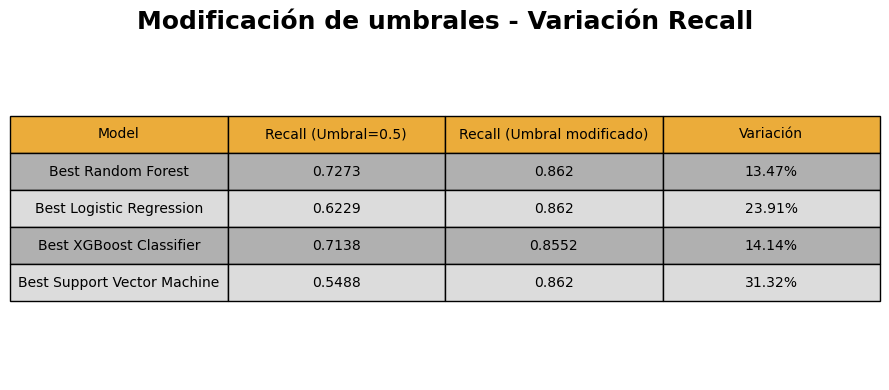

In [408]:
generar_tabla(df_recall_diff,
              title='Modificación de umbrales - Variación Recall',
              save='recall_diff',
              figsize=(9,4))

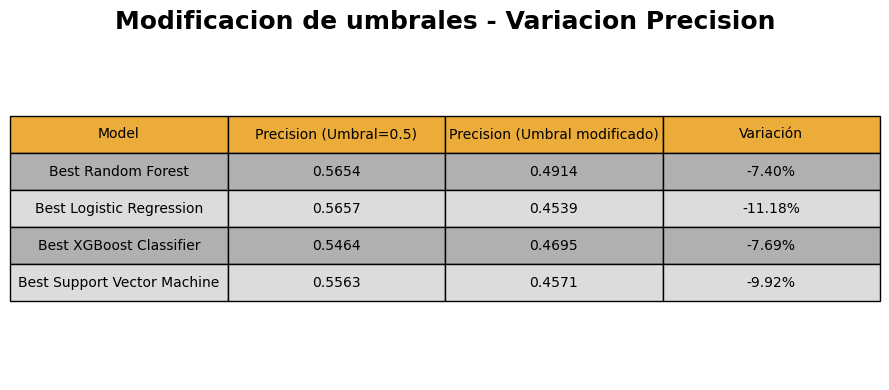

In [407]:
generar_tabla(df_precision_diff,
              title='Modificacion de umbrales - Variacion Precision',
              save='precision_diff',
              figsize=(9,4))

## <font color='#ebac3a'>**Conclusiones Métricas Generales y Umbrales de Decisión**</font>

Al evaluar las métricas de los modelos seleccionados como representantes de cada familia, se observa que el modelo `Best Random Forest` es el que mejor maneja el desbalance de clases. Este alcanza un valor de **AUC = 0.8326**, lo que indica que, si se seleccionan aleatoriamente un caso positivo (Churn = 1) y uno negativo (Churn = 0), el modelo tiene un **83.26% de probabilidad** de asignar una puntuación mayor al caso positivo.  
Esta métrica refleja la capacidad del modelo para discriminar entre ambas clases sin depender de un umbral específico, lo cual resulta especialmente valioso en contextos con clases desbalanceadas.

Sin modificar el umbral de decisión (por defecto en 0.5), `Best Random Forest` también presenta los valores más altos de **Recall** y **F1-score**, lo que refuerza su rendimiento y estabilidad general.

| Modelo                       | Dataset                      | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
|------------------------------|------------------------------|----------|-----------|--------|----------|--------|--------|
| Best Random Forest           | X                            | 0.7698   | 0.5654    | 0.7273 | 0.6362   | 0.8326 | 0.5    |
| Best Logistic Regression     | X_linear[selected_features]  | 0.7633   | 0.5657    | 0.6229 | 0.5929   | 0.8137 | 0.5    |
| Best K-Nearest Neighbors     | X_linear                     | 0.7251   | 0.5027    | 0.6364 | 0.5617   | 0.7513 | 0.5    |
| Best XGBoost Classifier      | X                            | 0.7568   | 0.5464    | 0.7138 | 0.6190   | 0.8188 | 0.5    |
| Best Support Vector Machine  | X_linear                     | 0.7540   | 0.5563    | 0.5488 | 0.5525   | 0.8073 | 0.5    |

Dado que el objetivo de negocio es **reducir el abandono de clientes**, se prioriza que el modelo sea capaz de **identificar correctamente la mayor cantidad de abandonos**. Para lograr esto, se exploraron distintos **umbrales de decisión** que permitieran maximizar la sensibilidad (**Recall**), manteniendo valores aceptables de **Precisión** y **F1-score**, de modo que las campañas de retención sean efectivas y, al mismo tiempo, rentables.

Los **umbrales entre 0.38 y 0.39** permitieron alcanzar valores de **Recall superiores a 0.85**, con una **Precisión** en el rango de **0.45 a 0.50**.

| Modelo                       | Dataset                      | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
|------------------------------|------------------------------|----------|-----------|--------|----------|--------|--------|
| Best Random Forest           | X                            | 0.7148   | 0.4914    | 0.8620 | 0.6259   | 0.8326 | 0.39   |
| Best Logistic Regression     | X_linear[selected_features]  | 0.6747   | 0.4539    | 0.8620 | 0.5947   | 0.8137 | 0.39   |
| Best XGBoost Classifier      | X                            | 0.6925   | 0.4695    | 0.8552 | 0.6062   | 0.8188 | 0.38   |
| Best Support Vector Machine  | X_linear                     | 0.6785   | 0.4571    | 0.8620 | 0.5974   | 0.8073 | 0.38   |

Aún con estas modificaciones en el umbral, el modelo `Best Random Forest` continúa mostrando las métricas más equilibradas y robustas. 
Si observamos las variaciones en la métrica prioritaria (**Recall**), este presenta la menor variación necesaria para alcanzar el valor esperado.

| Model	                       | Recall (Umbral=0.5)  | Recall (Umbral modificado)	| Variación |
|------------------------------|----------------------|-----------------------------|-----------|
| Best Random Forest	       | 0.7273	              | 0.8620	                    | 13.47%    |
| Best Logistic Regression	   | 0.6229	              | 0.8620	                    | 23.91%    |
| Best XGBoost Classifier	   | 0.7138	              | 0.8552	                    | 14.14%    |
| Best Support Vector Machine  | 0.5488	              | 0.8620	                    | 31.32%    |


Esto se traduce en la menor caída en **Precisión** para alcanzar dicho objetivo:


| Model	                       | Precision (Umbral=0.5)  | Precision (Umbral modificado)	| Variación |
|------------------------------|-------------------------|----------------------------------|-----------|
| Best Random Forest	       | 0.5654     	         | 0.4914	                        | -7.40%    |
| Best Logistic Regression	   | 0.5657	                 | 0.4539                           | -11.18%   |
| Best XGBoost Classifier	   | 0.5464      	         | 0.4695	                        | -7.69%    | 
| Best Support Vector Machine  | 0.5563	                 | 0.4571	                        | -9.92%    |


Esto lo postula como **candidato principal (Champion Model)** para su implementación en entornos productivos, al ofrecer un buen compromiso entre sensibilidad y precisión, clave para una estrategia efectiva de retención de clientes.

## <font color='#ebac3a'>**Subajuste (Underfitting) y Subajuste (Overfitting)**</font>

In [326]:
random_forest_train = metricas_evaluacion(random_forest, X_cv, y_cv, 'Best Random Forest', conjunto='X')
log_reg_train = metricas_evaluacion(log_reg, X_linear_cv[selected_features], 
                                    y_linear_cv, 'Best Logistic Regression', conjunto='X_linear[selected_features]')
xgb_train = metricas_evaluacion(xgb, X_cv, y_cv, 'Best XGBoost Classifier', conjunto='X')
svm_train = metricas_evaluacion(svm, X_linear_cv, y_linear_cv, 'Best Support Vector Machine', conjunto='X_linear')
metricas_train = [random_forest_train, log_reg_train, xgb_train, svm_train]

pd.DataFrame(metricas_train)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.8659   
1     Best Logistic Regression  X_linear[selected_features]    0.6252   
2      Best XGBoost Classifier                            X    0.7603   
3  Best Support Vector Machine                     X_linear    0.6208   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.8580  0.8769    0.8673  0.9481     0.5  
1     0.6220  0.6383    0.6301  0.6809     0.5  
2     0.7628  0.7555    0.7591  0.8515     0.5  
3     0.6261  0.5996    0.6126  0.6784     0.5

In [327]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
f1 = []

for metrica in metricas_train:
    modelo_rec = {}
    modelo_f1 = {}
    for key, value in metrica.items():
        
        if key == 'Model':
            modelo_rec[key] = value
            modelo_f1[key] = value
        if key == 'Recall':
            modelo_rec['Recall Train'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Train'] = value

    recall.append(modelo_rec)
    f1.append(modelo_f1)

for i, metrica in enumerate(metricas_eval):
    modelo_rec = recall[i]
    modelo_f1 = f1[i]
    for key, value in metrica.items():
        if key == 'Recall':
            modelo_rec['Recall Test'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Test'] = value

In [328]:
for modelo in recall:
    diff = np.round(modelo['Recall Test'] - modelo['Recall Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

for modelo in f1:
    diff = np.round(modelo['F1-score Test'] - modelo['F1-score Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

df_recall_diff = pd.DataFrame(recall)
df_f1_diff = pd.DataFrame(f1)

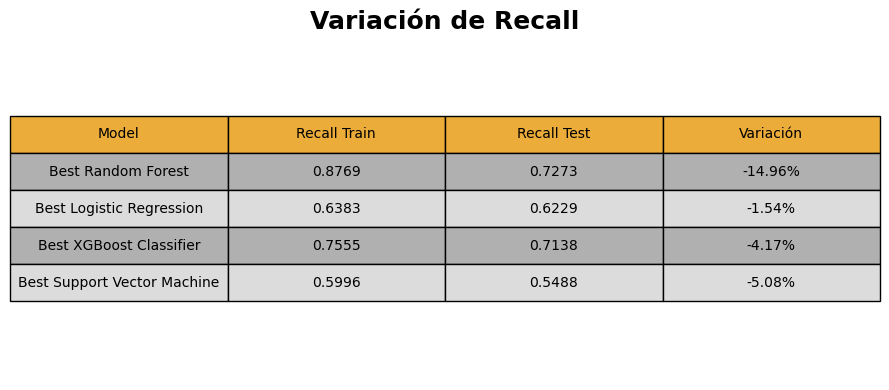

In [399]:
generar_tabla(df_recall_diff,
              title='Variación de Recall',
              save='recall_train_test',
              figsize=(9,4))

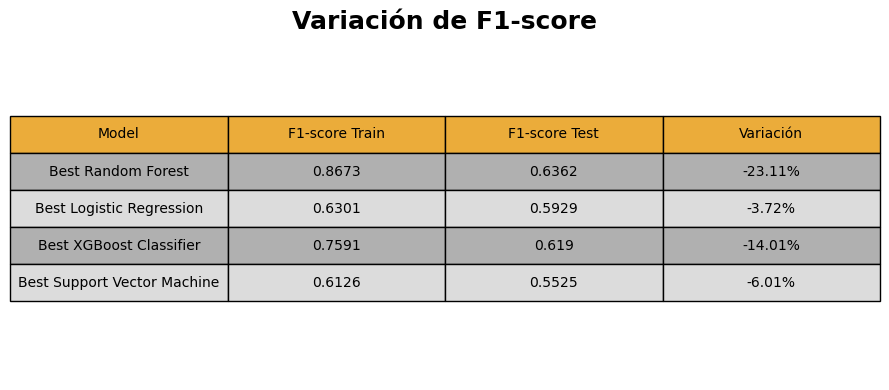

In [400]:
generar_tabla(df_f1_diff,
              title='Variación de F1-score',
              save='f1_train_test',
              figsize=(9,4))

In [331]:
df_recall_diff

Model  Recall Train  Recall Test Variación
0           Best Random Forest        0.8769       0.7273   -14.96%
1     Best Logistic Regression        0.6383       0.6229    -1.54%
2      Best XGBoost Classifier        0.7555       0.7138    -4.17%
3  Best Support Vector Machine        0.5996       0.5488    -5.08%

In [332]:
df_f1_diff

Model  F1-score Train  F1-score Test Variación
0           Best Random Forest          0.8673         0.6362   -23.11%
1     Best Logistic Regression          0.6301         0.5929    -3.72%
2      Best XGBoost Classifier          0.7591         0.6190   -14.01%
3  Best Support Vector Machine          0.6126         0.5525    -6.01%

## <font color='#ebac3a'>**Conclusiones: Subajuste (Underfitting) y Sobreajuste (Overfitting)**</font>

### <font color='#8b5fc4'>**Subajuste (Underfitting)**</font>

En cuanto a este aspecto, ninguno de los modelos mostró un subajuste (underfitting), ya que durante el entrenamiento todos alcanzan un desempeño aceptable en sus métricas:

| Model	                       | Dataset	                 | Accuracy	  | Precision   | Recall	| F1-score	 | AUC	   | Umbral |
|------------------------------|-----------------------------|------------|-------------|-----------|------------|---------|--------|
| Best Random Forest	       | X	                         | 0.8659	  | 0.8580	    | 0.8769	| 0.8673	 | 0.9481  | 0.5    |
| Best Logistic Regression	   | X_linear[selected_features] | 0.6252	  | 0.6220	    | 0.6383	| 0.6301	 | 0.6809  | 0.5    |
| Best XGBoost Classifier	   | X	                         | 0.7603	  | 0.7628	    | 0.7555	| 0.7591	 | 0.8515  | 0.5    |
| Best Support Vector Machine  | X_linear	                 | 0.6208	  | 0.6261	    | 0.5996	| 0.6126	 | 0.6784  | 0.5    |

Al observar el valor del **Accuracy** (ya que los datos de entrenamiento han sido balanceados), es posible ver que todos superan al menos el **60%**, lo que indica que no hacen predicciones al azar, sino que han logrado aprender relaciones útiles entre las variables.

### <font color='#8b5fc4'>**Sobreajuste (Overfitting)**</font>

#### <font color='#e9611d'>**Best Random Forest**</font>

El modelo `Best Random Forest` presenta un fuerte sobreajuste. Durante el entrenamiento, sus métricas tienen un promedio general de 0.87, mientras que al evaluarlo en el conjunto de prueba, estas disminuyen significativamente:

| Métrica            | Train	     |  Test	       | Variación  |
|--------------------|---------------|-----------------|------------|
| Recall	         | 0.8769	     | 0.7273	       | -14.96%    |
| F1-score           | 0.8673	     | 0.6362	       | -23.11%    |

A pesar de este comportamiento, sigue siendo el modelo que mejor separa las clases en el conjunto de prueba, lo que indica que ha capturado patrones relevantes, aunque también podría beneficiarse de una mayor regularización.


#### <font color='#e9611d'>**Best Logistic Regression**</font>

`Best Logistic Regression` se muestra como el modelo más estable. Sus métricas se mantienen bastante similares tanto en entrenamiento como en prueba:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall	         | 0.6383	     | 0.6229	      | -1.54%     |
| F1-score           | 0.6301	     | 0.5929	      | -3.72%     |

Sin embargo, para alcanzar un **Recall** aceptable ajustando el umbral de decisión, este modelo requiere un mayor **sacrificio en Precisión**, lo cual podría impactar la eficiencia de las acciones derivadas.


#### <font color='#e9611d'>**Best XGB Classifier**</font>

El modelo `Best XGB Classifier` también muestra indicios de sobreajuste, especialmente en la métrica **F1-score**. Esto confirma que las arquitecturas basadas en árboles, aunque potentes, tienden a memorizar patrones de entrenamiento:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall             | 0.7555	     | 0.7138	      | -4.17%     |
| F1-score           | 0.7591	     | 0.6190	      | -14.01%    |

A pesar de la caída, el modelo sigue manteniendo una capacidad de predicción razonable sobre datos no vistos.

#### <font color='#e9611d'>**Best Support Vector Machine**</font>

`Best Support Vector Machine` presenta las métricas más bajas en general. Si bien las diferencias entre entrenamiento y prueba no son elevadas, los valores en ambas etapas rondan el 0.58:

| Métrica            | Train	     |  Test	      | Variación  |
|--------------------|---------------|----------------|------------|
| Recall	         | 0.5996	     | 0.5488	      | -5.08%     |
| F1-score           | 0.6126	     | 0.5525	      | -6.01%     |

Esto sugiere que, a diferencia de lo que se observó durante el entrenamiento, este no logra capturar patrones relevantes cuando es evaluado con datos no vistos *(test dataset)*, posiblemente debido a su naturaleza lineal frente a un problema con relaciones más complejas.

## <font color='#ebac3a'>**Best Models Confusion Matrices**</font>

En la exploración de umbrales de decisión, se determinó que un escenario "idoneo", era conseguir que los modelos pudieran identificar el 85% de los casos de clientes que deciden abandonar la empresa.

Para ello, inevitablemente es necesario una compensación en la intervención de clientes que no tienen probabilidades de cancelar sus servicios.

A través de las matrices de confusión, es posible observar "cuantos clientes serán intervenidos erroneamente" al utilizar cada uno de los modelos seleccionados.

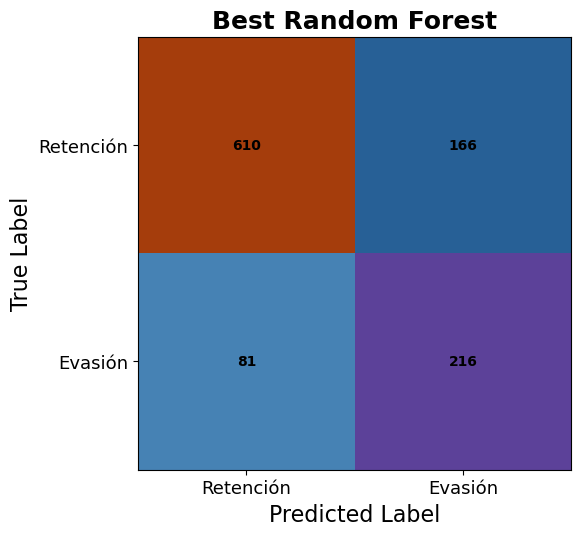

In [333]:
plot_conf_mat(model=random_forest,
              x=X_test,
              y=y_test,
              name='Best Random Forest',
              save='confmat_random_forest')

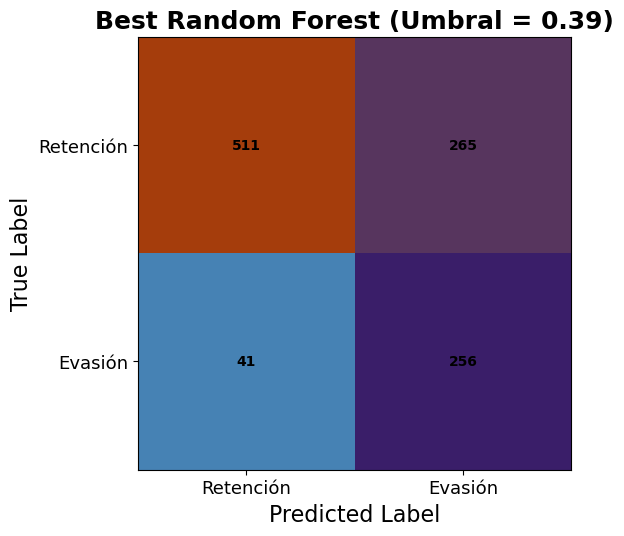

In [334]:
plot_conf_mat(model=random_forest,
              x=X_test,
              y=y_test,
              name='Best Random Forest (Umbral = 0.39)',
              save='confmat_random_forest_umbral',
              umbral=0.39)

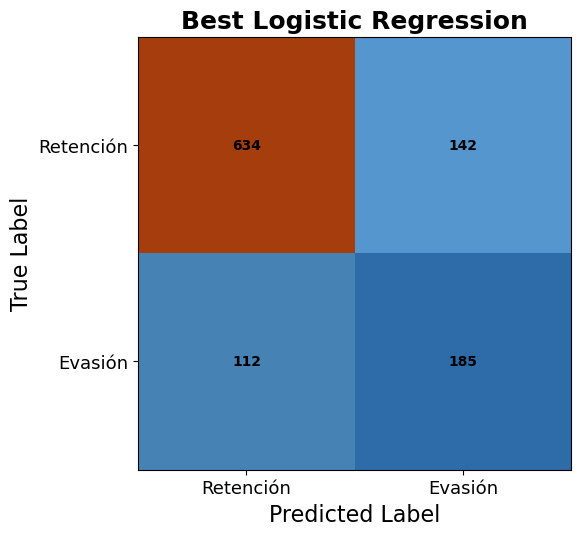

In [335]:
plot_conf_mat(model=log_reg,
              x=X_linear_test[selected_features],
              y=y_linear_test,
              name='Best Logistic Regression',
              save='confmat_log_reg')

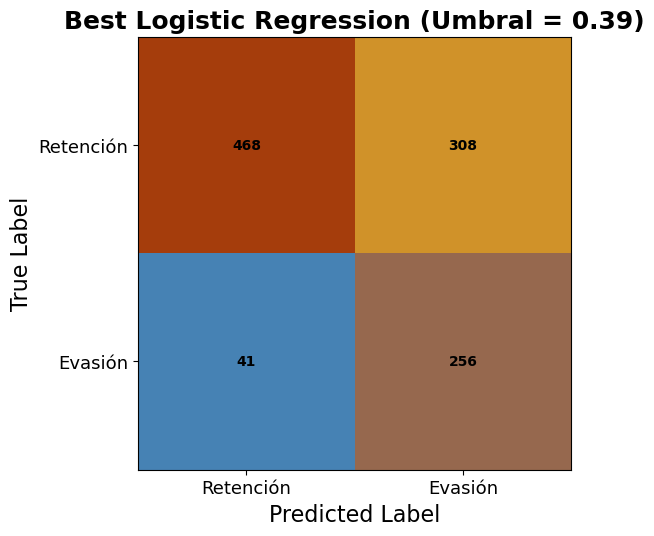

In [336]:
plot_conf_mat(model=log_reg,
              x=X_linear_test[selected_features],
              y=y_linear_test,
              name='Best Logistic Regression (Umbral = 0.39)',
              save='confmat_log_reg_umbral',
              umbral=0.39)

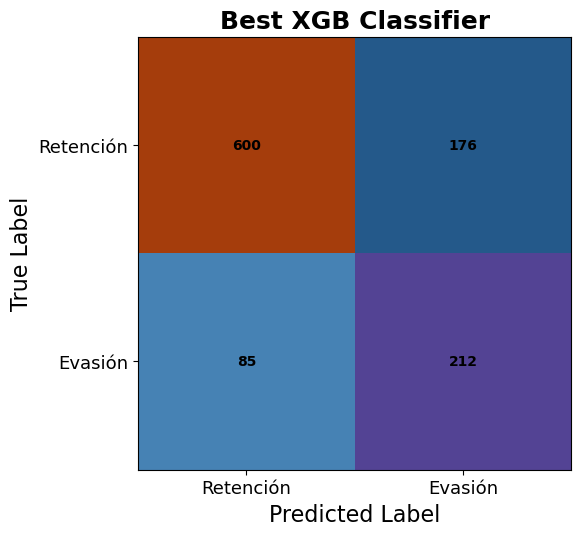

In [337]:
plot_conf_mat(model=xgb,
              x=X_test,
              y=y_test,
              name='Best XGB Classifier',
              save='confmat_xgb')

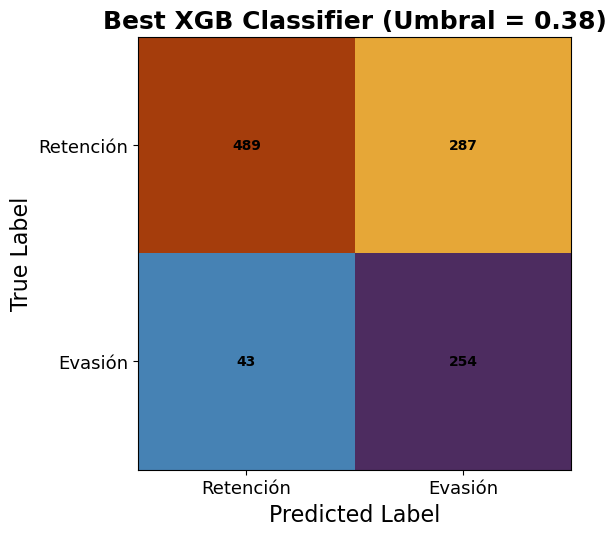

In [338]:
plot_conf_mat(model=xgb,
              x=X_test,
              y=y_test,
              name='Best XGB Classifier (Umbral = 0.38)',
              save='confmat_xgb_umbral',
              umbral=0.38)

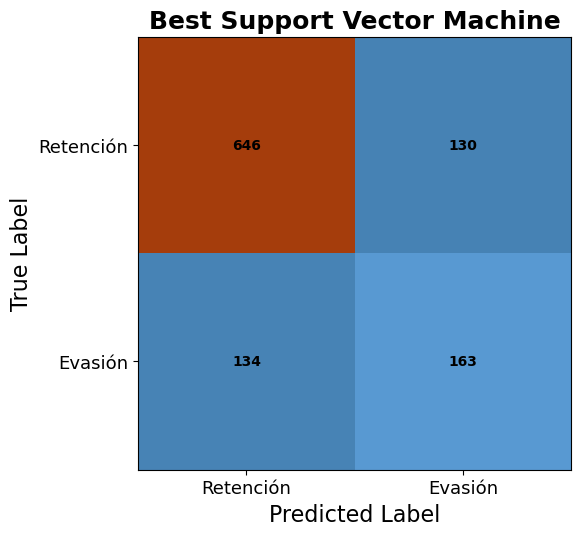

In [339]:
plot_conf_mat(model=svm,
              x=X_linear_test,
              y=y_linear_test,
              name='Best Support Vector Machine',
              save='confmat_svm')

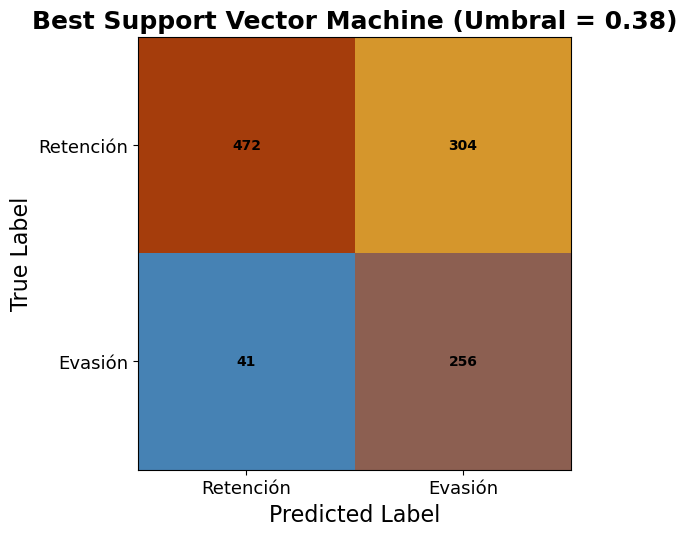

In [340]:
plot_conf_mat(model=svm,
              x=X_linear_test,
              y=y_linear_test,
              name='Best Support Vector Machine (Umbral = 0.38)',
              save='confmat_svm_umbral',
              umbral=0.38)

## <font color='#ebac3a'>**Conclusiones: Matrices de Confusión**</font>

Para alcanzar el 85% de casos postivios identificados correctamente, cada uno de los modelos clasifica erróneamente como abandono:

|Modelo                       | Casos Positivos Verdaderos | Casos Positivos Falsos |
|-----------------------------|----------------------------|------------------------|
| Best Random Forest          | 256                        | 265                    |
| Best Logistic Regression    | 256                        | 308                    |
| Best XGB Classifier         | 254                        | 287                    |
| Best Support Vector Machine | 256                        | 304                    |


Como puede verse en la tabla anterior, al modificar el umbral de decisión para que todos los modelos sean capaces de identificar correctamente el 85% de casos de clientes que abandonan (`Churn = 1`), el que incurre en menor cantidad de **Falsos Positivos** es `Best Random Forest`. Esto significa que este modelo es ideal para dirigir campañas de retención, captando una proporción elevada de clientes propensos a cancelar sus servicios, aún siendo eficiente

## <font color='#ebac3a'>**Importancias y Coeficientes**</font>

### <font color='#f07c3e'>**Best Random Forest - Importancias**</font>

In [341]:
rf_importancias = random_forest.feature_importances_
features = X_test.columns

df_importancias_rf = pd.DataFrame({'Feature': features,
                                   'Importancia': rf_importancias}).sort_values('Importancia', ascending=False)
df_importancias_rf

Feature  Importancia
23                                   Tenure     0.201828
25                             ChargesTotal     0.195428
24                           ChargesMonthly     0.127672
15                  Contract_Month-to-month     0.061776
21           PaymentMethod_Electronic check     0.037018
12                          TechSupport_Yes     0.036106
17                        Contract_Two year     0.027935
7               InternetService_Fiber optic     0.027061
9                        OnlineSecurity_Yes     0.026136
18                     PaperlessBilling_Yes     0.024943
0                               Gender_Male     0.019606
5                         MultipleLines_Yes     0.018431
14                      StreamingMovies_Yes     0.017865
16                        Contract_One year     0.017757
13                          StreamingTV_Yes     0.017615
3                            Dependents_Yes     0.016910
10                         OnlineBackup_Yes     0.016560
2                               Partner_Yes     0.016240
6                       InternetService_DSL     0.015794
1                         SeniorCitizen_Yes     0.014550
11                     DeviceProtection_Yes     0.014464
22               PaymentMethod_Mailed check     0.012855
20    PaymentMethod_Credit card (automatic)     0.011235
19  PaymentMethod_Bank transfer (automatic)     0.010881
4                          PhoneService_Yes     0.009429
8                         NoInternetService     0.003907

In [342]:
df_importancias_rf[:10]

Feature  Importancia
23                          Tenure     0.201828
25                    ChargesTotal     0.195428
24                  ChargesMonthly     0.127672
15         Contract_Month-to-month     0.061776
21  PaymentMethod_Electronic check     0.037018
12                 TechSupport_Yes     0.036106
17               Contract_Two year     0.027935
7      InternetService_Fiber optic     0.027061
9               OnlineSecurity_Yes     0.026136
18            PaperlessBilling_Yes     0.024943

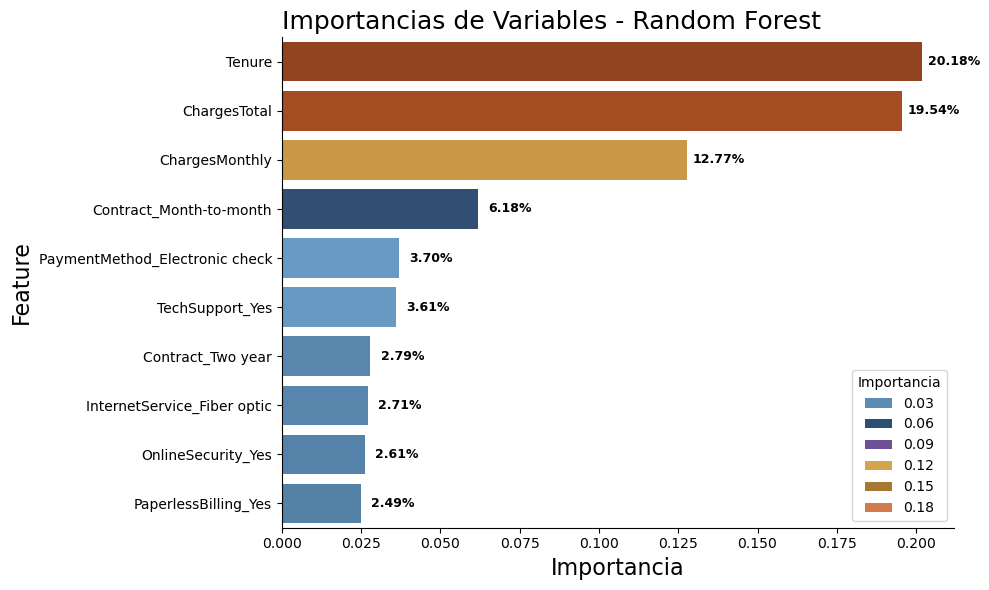

In [343]:
plot_analisis_variables(df=df_importancias_rf, 
                        analisis='Importancia',
                        nombre_modelo='Random Forest',
                        n_vars=10,
                        save='RandomForest_importancias',
                        space=0.05)

In [344]:
rf_importancia_10 = np.round(df_importancias_rf['Importancia'].head(10).sum(), 4)
print(f'Importancia de las 10 variables más relevantes: {rf_importancia_10}')

Importancia de las 12 variables más relevantes: 0.7659


### <font color='#8b5fc4'>**Observaciones: Best Random Forest - Importancias**</font>

A partir de las importancias determinadas por el mejor modelo de Random Forest, se seleccionaron las 10 variables con una importancia superior a **0.02**:

* `Tenure`
* `ChargesTotal`
* `ChargesMonthly`
* `Contract_Month-to-month`
* `PaymentMethod_Electronic check`
* `TechSupport_Yes`
* `Contract_Two year`
* `InternetService_Fiber optic`
* `OnlineSecurity_Yes`
* `PaperlesBilling_Yes`


La suma de sus importancias alcanza un **76.59%**, lo que indica que estas variables explican la mayor parte de las decisiones del modelo. En otras palabras, contribuyen en tres cuartas partes a reducir la impureza de los nodos de los árboles de decisión.

En particular, las tres variables numéricas —`Tenure` (**20.18%**), `ChargesTotal` (**19.54%**) y `ChargesMonthly` (**12.77%**)— representan juntas el **52.49%** de la importancia total. Esto sugiere que el modelo empieza a dividir los datos principalmente en función de estas variables, logrando más de la mitad de la reducción de impureza con ellas solas.

Sin embargo, este tipo de modelo no permite evaluar **cuánto** impacta cada variable en la probabilidad de Evasión (Churn). La importancia asignada a cada variable refleja **qué tan útil** resulta para reducir la impureza entre clases durante la construcción de los árboles, pero **no permite interpretar ni la magnitud ni la dirección** de su efecto sobre el resultado, ya que **no se basa en coeficientes** como lo hacen los modelos lineales.

### <font color='#f07c3e'>**Best Logistic Regression - Coeficientes**</font>

In [345]:
coeficientes = log_reg.coef_
features = X_linear_test[selected_features].columns

df_coeficientes_logreg = pd.DataFrame({'Feature': features,
                                       'Coeficiente': coeficientes[0]}).sort_values('Coeficiente', ascending=False)

df_coeficientes_logreg

Feature  Coeficiente
2              ChargesTotal_scaled     0.717976
4            ChargesMonthly_scaled     0.358198
3   PaymentMethod_Electronic check     0.291330
1      InternetService_Fiber optic     0.277426
9                SeniorCitizen_Yes     0.271842
5             PaperlessBilling_Yes     0.244093
11                     Partner_Yes    -0.000572
8                Contract_One year    -0.056687
10                  Dependents_Yes    -0.077505
6               OnlineSecurity_Yes    -0.168953
7                  TechSupport_Yes    -0.235722
0                    Tenure_scaled    -1.856258

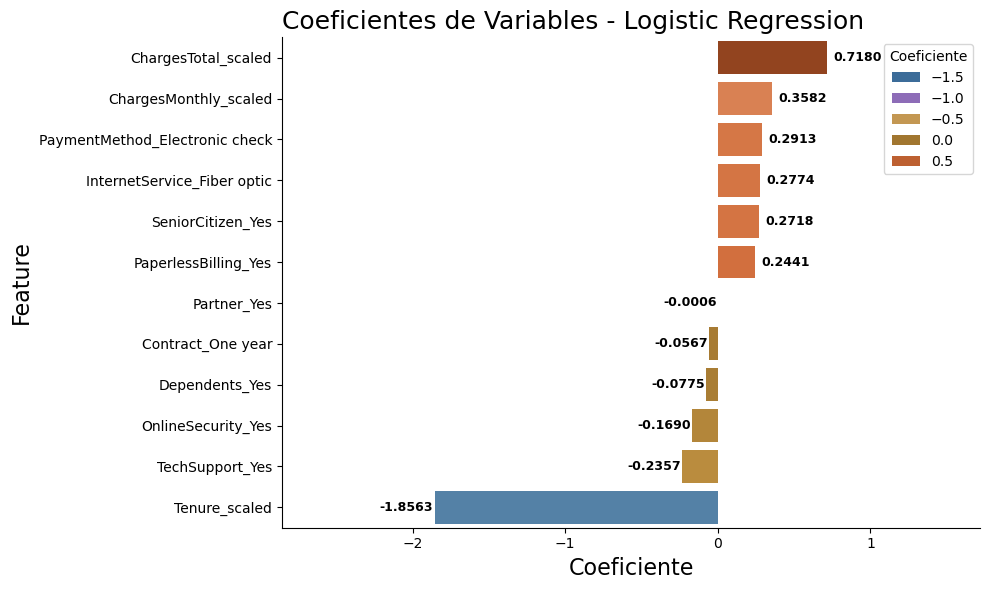

In [346]:
plot_analisis_variables(df=df_coeficientes_logreg, 
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression',
                        save='LogReg_coeficientes')

### <font color='#8b5fc4'>**Observaciones: Best Logistic Regression - Coeficientes**</font>

Los modelos lineales como **Regresión Logística** ofrecen una ventaja significativa frente a los modelos de árboles: permiten interpretar tanto la **dirección** como la **magnitud** del impacto de cada variable sobre la **probabilidad de Evasión (Churn)**.

Este análisis se basa en un modelo entrenado utilizando `OneHotEncoder(drop='first')` y penalización **L1 (Lasso)**, lo que implica:
* Los coeficientes están **en relación a la categoría omitida** de cada variable categórica.
* Las variables irrelevantes son automáticamente descartadas (`coef = 0`).


#### **Dirección del impacto**
- **Coeficientes positivos**: Aumentan la probabilidad de churn.
- **Coeficientes negativos**: Disminuyen la probabilidad de churn.


#### **Magnitud del impacto**
Los coeficientes representan el cambio en los **log-odds** de churn por unidad de cambio en la variable (escalada), manteniendo constantes las demás.

$$
\Large \text{log-odds} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n
$$

Para convertir los logits a probabilidades usamos la función sigmoide, y para interpretar el cambio marginal usamos el **odds ratio**:

$$
\Large odds_{ratio} = e^{\beta_i}
$$


#### **Variables protectoras contra churn**

* `Tenure_scaled = -1.8563`

$$
\Large odds_{ratio} = e^{-1.8563} \approx 0.15 
$$
$$
\Large 1 - 0.15 \approx 0.85  = \text{Reduce las chances en } \approx 85\%
$$

* `TechSupport_Yes = -0.2357`

$$
\Large  odds_{ratio} = e^{-0.2357} \approx 0.79 
$$
$$
\Large 1 - 0.79 = \text{Reduce las chances en } \approx 20.1\%
$$

* `OnlineSecurity_Yes = -0.1690`  

$$
\Large  odds_{ratio} = e^{-0.1690} \approx 0.84 
$$
$$
\Large 1 - 0.84 = \text{Reduce las chances en } \approx 16\%
$$

* `Dependents_Yes = 0.0775` y `Contract_One year = 0.0567`

También contribuyen a **reducir la probabilidad de churn**.


#### **Variables que aumentan el riesgo de churn**

* `ChargesTotal_scaled = 0.7180`  

$$
\Large  odds_{ratio} = e^{0.7180} \approx 2.05  \Rightarrow \text{Aumenta el riesgo 2 veces}
$$


* `ChargesMonthly_scaled = 0.3582`  

$$
\Large  odds_{ratio} = e^{0.7180} \approx 1.43  \Rightarrow \text{Aumenta el riesgo 0.43 veces}
$$

* `PaymentMethod_Electronic check = 0.2913`
* `InternetService_Fiber optic = 0.2774`
* `SeniorCitizen_Yes = 0.2718`
* `PaperlessBilling_Yes = 0.2440`
  
  Estas variables también se asocian a **mayor propensión a churn**.


#### **Variables omitidas vs coeficientes**

Dado que se usó `drop='first'`, todos los coeficientes de variables categóricas deben interpretarse **relativamente a la categoría omitida**. Por ejemplo:

- `InternetService_Fiber optic` está en relación a `InternetService_DSL` (omitida). Lo que implica que, por ejemplo, esta variable al tener coeficiente positivo, los log-odds (logits) aumentan en $1 - e^{\beta_i}$ en relación a si el cliente tiene `InternetService_DSL = 1`
- `PaymentMethod_Electronic check`, `Mailed check`, y `Credit card` se comparan con `Bank transfer (automatic)` de la misma manera.


#### **Tensión aparente entre** `ChargesTotal` y `Tenure`

Aunque estas dos variables están altamente correlacionadas (0.94), lo que singifica que se comportan de manera directamente proporcional, sus coeficientes tienen signos opuestos:

* `Tenure_scaled` tiene un coeficiente negativo (protege contra churn).
* `ChargesTotal_scaled` tiene un coeficiente positivo (aumenta riesgo de churn).

Esta aparente contradicción puede explicarse porque:

- **`Tenure` refleja antigüedad y lealtad**: clientes con más tiempo suelen ser más fieles y menos propensos a abandonar.
- **`ChargesTotal` representa el monto acumulado cobrado** y puede captar otros factores, como clientes con altos cargos que podrían estar insatisfechos o que enfrentan cambios recientes en tarifas o servicios.

En otras palabras, el modelo podría estar detectando que, entre clientes con alta antigüedad, aquellos con cargos acumulados muy elevados presentan un riesgo mayor de churn, quizás debido a insatisfacción por costos crecientes o servicios cambiantes. Probablemente los clientes que fueron seleccionados como outliers en la etapa anterior, pero que se decidieron conservar para captar justamente este tipo de fenómenos. Lo que sugiere que deberían analizarse de forma separada, buscando qué factores son los que llevan a clientes con un Gasto Total (ChargesTotal) elevado a abandonar la empresa.


#### **Conclusión**

La regresión logística con una seleccion de variables mediante experimentos, permitió construir un modelo interpretable, robusto y selectivo.  
Gracias al uso de codificación `drop='first'`, se logra:

- Evitar la multicolinealidad.
- Detectar **factores clave de riesgo y protección**.
- Explicar con claridad la lógica del modelo al negocio.

In [347]:
odds_ratios = []
interpretaciones = []

for coeficiente in df_coeficientes_logreg['Coeficiente']:
    odds_ratio = np.round(np.exp(coeficiente), 4)
    odds_ratios.append(odds_ratio)
    if coeficiente > 0:
        impacto = np.round((odds_ratio - 1)*100, 2)
        interpretacion = f'Aumenta las chances en: {impacto}%'
    elif coeficiente < 0:
        impacto = np.round((1 - odds_ratio)*100, 2)
        interpretacion = f'Disminuye las chances en: {impacto}%'
    else:
        interpretacion = 'Sin impacto'
    interpretaciones.append(interpretacion)
    
df_coeficientes_logreg['Odds Ratio'] = odds_ratios
df_coeficientes_logreg['Interpretación'] = interpretaciones

df_coeficientes_logreg

Feature  Coeficiente  Odds Ratio  \
2              ChargesTotal_scaled     0.717976      2.0503   
4            ChargesMonthly_scaled     0.358198      1.4307   
3   PaymentMethod_Electronic check     0.291330      1.3382   
1      InternetService_Fiber optic     0.277426      1.3197   
9                SeniorCitizen_Yes     0.271842      1.3124   
5             PaperlessBilling_Yes     0.244093      1.2765   
11                     Partner_Yes    -0.000572      0.9994   
8                Contract_One year    -0.056687      0.9449   
10                  Dependents_Yes    -0.077505      0.9254   
6               OnlineSecurity_Yes    -0.168953      0.8445   
7                  TechSupport_Yes    -0.235722      0.7900   
0                    Tenure_scaled    -1.856258      0.1563   

                      Interpretación  
2    Aumenta las chances en: 105.03%  
4     Aumenta las chances en: 43.07%  
3     Aumenta las chances en: 33.82%  
1     Aumenta las chances en: 31.97%  
9     Aumenta las chances en: 31.24%  
5     Aumenta las chances en: 27.65%  
11   Disminuye las chances en: 0.06%  
8    Disminuye las chances en: 5.51%  
10   Disminuye las chances en: 7.46%  
6   Disminuye las chances en: 15.55%  
7    Disminuye las chances en: 21.0%  
0   Disminuye las chances en: 84.37%

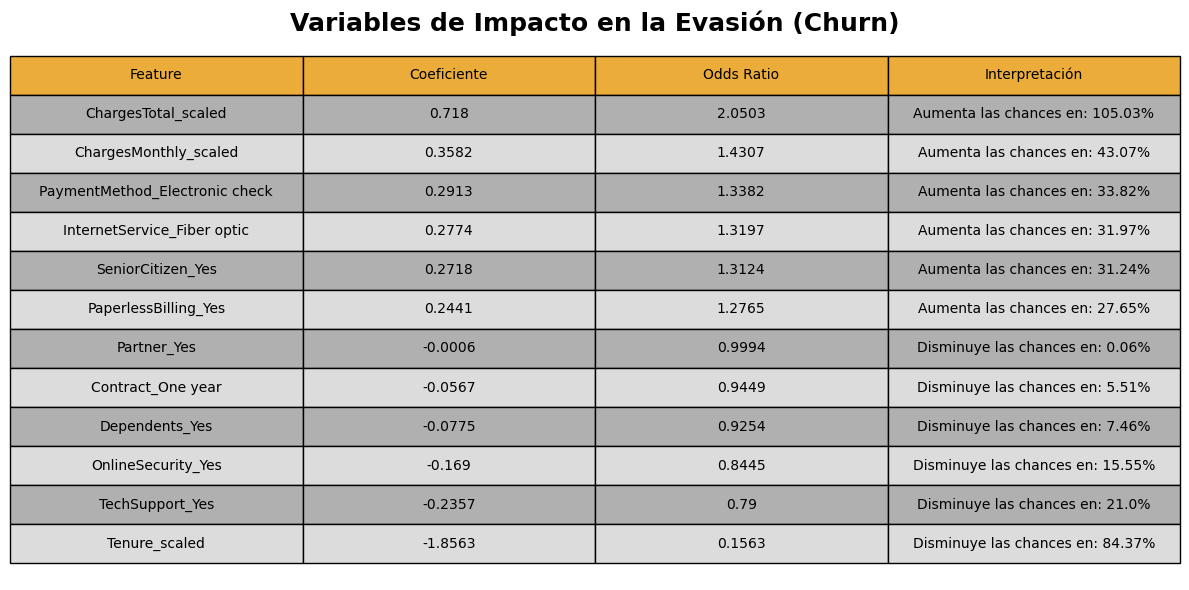

In [348]:
generar_tabla(df_coeficientes_logreg,
              title='Variables de Impacto en la Evasión (Churn)',
              save='tabla_coef_logreg',
              figsize=(12,6))

#### Unidad Robusta Tenure

In [350]:
index = cols_robust_scaler.index('Tenure')

mediana = robust_scaler.center_[index]
iqr = robust_scaler.scale_[index]

print(f"Una unidad escalada en Tenure equivale a {int(iqr)} meses.")
print(f"La mediana de Tenure es de {int(mediana)}.")

Una unidad escalada en Tenure equivale a 47 meses.
La mediana de Tenure es de 30.


#### Unidad Robusta ChargesMonthly

In [422]:
cols_robust_scaler = robust_scaler.feature_names_in_.tolist()
index = cols_robust_scaler.index('ChargesMonthly')

mediana = robust_scaler.center_[index]
iqr = robust_scaler.scale_[index]

print(f"Una unidad escalada en ChargesTotal equivale a {iqr:.2f} unidades monetarias reales.")
print(f"La mediana de ChargesTotal es de {mediana:.2f}.")

Una unidad escalada en ChargesTotal equivale a 54.55 unidades monetarias reales.
La mediana de ChargesTotal es de 70.80.


#### Unidad Robusta ChargesTotal

In [349]:
cols_robust_scaler = robust_scaler.feature_names_in_.tolist()
index = cols_robust_scaler.index('ChargesTotal')

mediana = robust_scaler.center_[index]
iqr = robust_scaler.scale_[index]

print(f"Una unidad escalada en ChargesTotal equivale a {iqr:.2f} unidades monetarias reales.")
print(f"La mediana de ChargesTotal es de {mediana:.2f}.")

Una unidad escalada en ChargesTotal equivale a 3537.60 unidades monetarias reales.
La mediana de ChargesTotal es de 1421.90.


### <font color='#f07c3e'>**Best XGBoost Classifier - Importancias**</font>

In [351]:
#xgb_best = xgb.best_estimator_
importancias_xgb = xgb.feature_importances_ #xgb_best.feature_importances_
features = X_test.columns

df_importancias_xgb = pd.DataFrame({'Feature': features,
                                    'Importancia': importancias_xgb}).sort_values('Importancia', ascending=False)

df_importancias_xgb

Feature  Importancia
15                  Contract_Month-to-month     0.269077
7               InternetService_Fiber optic     0.085223
23                                   Tenure     0.068217
17                        Contract_Two year     0.068177
12                          TechSupport_Yes     0.045972
25                             ChargesTotal     0.043740
16                        Contract_One year     0.036461
21           PaymentMethod_Electronic check     0.033650
9                        OnlineSecurity_Yes     0.028213
14                      StreamingMovies_Yes     0.027107
13                          StreamingTV_Yes     0.026849
22               PaymentMethod_Mailed check     0.024226
18                     PaperlessBilling_Yes     0.023910
5                         MultipleLines_Yes     0.023607
3                            Dependents_Yes     0.023440
4                          PhoneService_Yes     0.022489
24                           ChargesMonthly     0.021914
20    PaymentMethod_Credit card (automatic)     0.017665
6                       InternetService_DSL     0.016352
0                               Gender_Male     0.015960
1                         SeniorCitizen_Yes     0.015642
11                     DeviceProtection_Yes     0.014140
10                         OnlineBackup_Yes     0.013836
8                         NoInternetService     0.012369
2                               Partner_Yes     0.010966
19  PaymentMethod_Bank transfer (automatic)     0.010799

In [352]:
df_importancias_xgb[df_importancias_xgb['Importancia'] > 0.02]

Feature  Importancia
15         Contract_Month-to-month     0.269077
7      InternetService_Fiber optic     0.085223
23                          Tenure     0.068217
17               Contract_Two year     0.068177
12                 TechSupport_Yes     0.045972
25                    ChargesTotal     0.043740
16               Contract_One year     0.036461
21  PaymentMethod_Electronic check     0.033650
9               OnlineSecurity_Yes     0.028213
14             StreamingMovies_Yes     0.027107
13                 StreamingTV_Yes     0.026849
22      PaymentMethod_Mailed check     0.024226
18            PaperlessBilling_Yes     0.023910
5                MultipleLines_Yes     0.023607
3                   Dependents_Yes     0.023440
4                 PhoneService_Yes     0.022489
24                  ChargesMonthly     0.021914

In [353]:
len(df_importancias_xgb[df_importancias_xgb['Importancia'] > 0.02])

17

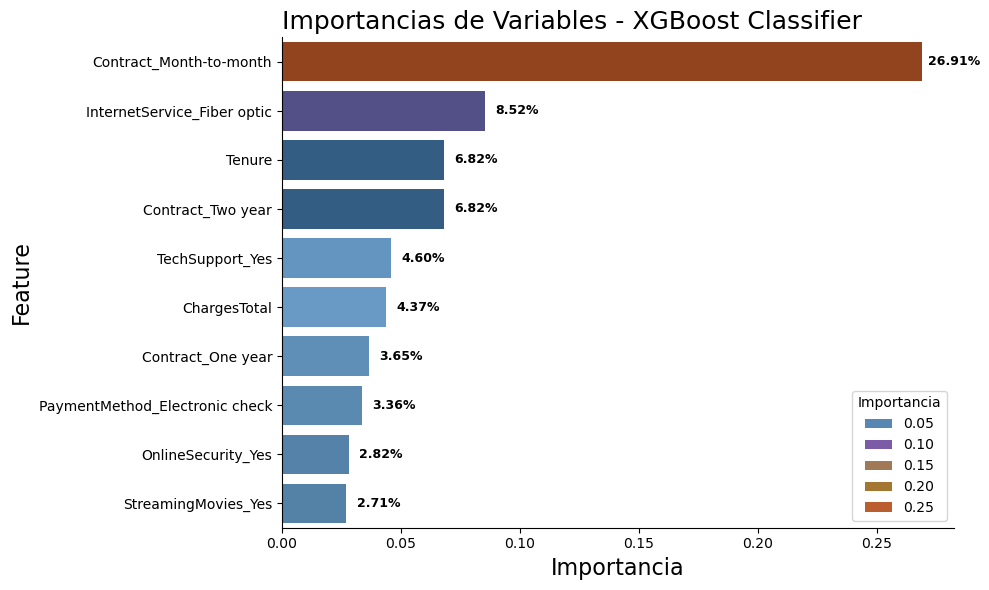

In [354]:
plot_analisis_variables(df=df_importancias_xgb, 
                        analisis='Importancia',
                        nombre_modelo='XGBoost Classifier',
                        save='XGB_importances',
                        n_vars=10,
                        space=0.05)

In [355]:
xgb_importancia_10 = np.round(df_importancias_xgb['Importancia'].head(10).sum(), 4)
print(f'Importancia de las 12 variables más relevantes: {xgb_importancia_10}')

Importancia de las 12 variables más relevantes: 0.7057999968528748


Las **10 variables** más importantes según el modelo `Best XGB Classifier` representan el **70.57%** de las decisiones tomadas por los árboles de decisión que lo componen. Esto indica que, en promedio, los árboles basaron la mayor parte de sus **criterios de ramificación** en las siguientes variables:

* `Contract_Month-to-month`
* `InternetService_Fiber optic`
* `Tenure`
* `Contract_Two year`
* `TechSupport_Yes`
* `ChargesTotal`
* `Contract_One year`
* `PhoneService_Yes`
* `PaymentMethod_Electronic check`
* `OnlineSecurity_Yes`
* `StreamingMoives_Yes`

Destaca la gran predominancia de `Contract_Month-to-month`, lo cual indica que esta variable por sí sola ayuda a reducir las impurezas por más del **25%**.
Sin embargo, los modelos de arquitectura de árbol no permiten cuantificar el impacto de cada una de ellas, sino solo entender que tanto ayudan a reducir la impureza entre clases.

### <font color='#f07c3e'>**Best Support Vector Machine - Coeficientes**</font>

In [356]:
svm_coeficientes = svm.coef_[0]
features = X_linear_cv.columns

df_coeficientes_svm = pd.DataFrame({'Feature': features,
                                    'Coeficiente': svm_coeficientes}).sort_values('Coeficiente', ascending=False)
df_coeficientes_svm

Feature  Coeficiente
6             InternetService_Fiber optic     1.306777
18         PaymentMethod_Electronic check     0.297383
1                       SeniorCitizen_Yes     0.232752
12                        StreamingTV_Yes     0.227853
5                       MultipleLines_Yes     0.216517
16                   PaperlessBilling_Yes     0.208265
13                    StreamingMovies_Yes     0.204225
15                      Contract_Two year     0.109581
19             PaymentMethod_Mailed check     0.100936
10                   DeviceProtection_Yes     0.058175
17  PaymentMethod_Credit card (automatic)     0.025508
2                             Partner_Yes     0.010502
9                        OnlineBackup_Yes    -0.004237
0                             Gender_Male    -0.016000
3                          Dependents_Yes    -0.024558
8                      OnlineSecurity_Yes    -0.052651
11                        TechSupport_Yes    -0.059619
14                      Contract_One year    -0.061560
22                    ChargesTotal_scaled    -0.083803
21                  ChargesMonthly_scaled    -0.245003
7                       NoInternetService    -0.290493
4                        PhoneService_Yes    -0.688932
20                          Tenure_scaled    -1.394731

In [357]:
var_risk = df_coeficientes_svm.head(5)
var_prot = df_coeficientes_svm.tail(5)

df_coeficientes_svm = pd.concat([var_risk, var_prot])

In [358]:
df_coeficientes_svm

Feature  Coeficiente
6      InternetService_Fiber optic     1.306777
18  PaymentMethod_Electronic check     0.297383
1                SeniorCitizen_Yes     0.232752
12                 StreamingTV_Yes     0.227853
5                MultipleLines_Yes     0.216517
22             ChargesTotal_scaled    -0.083803
21           ChargesMonthly_scaled    -0.245003
7                NoInternetService    -0.290493
4                 PhoneService_Yes    -0.688932
20                   Tenure_scaled    -1.394731

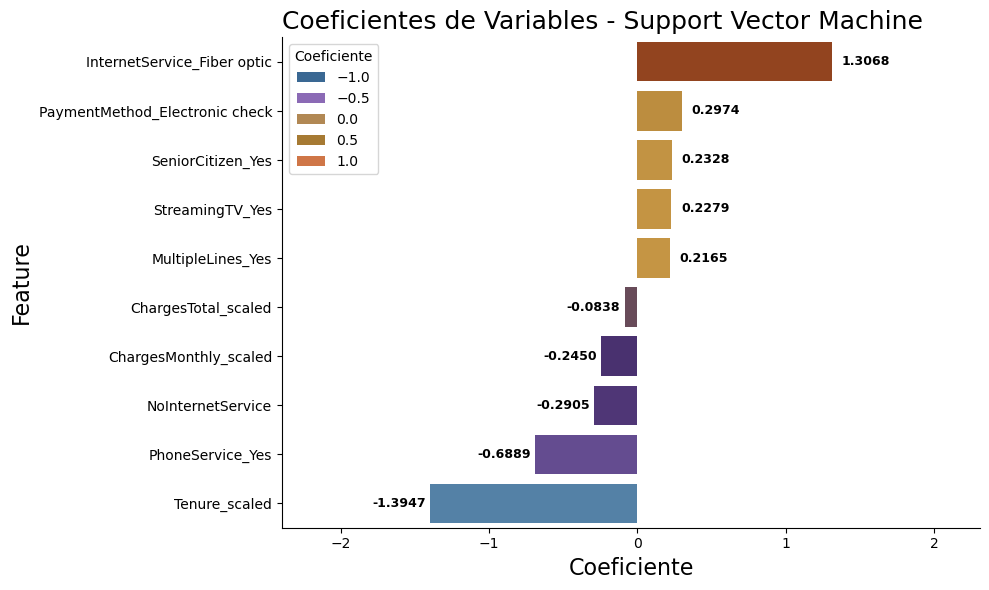

In [359]:
plot_analisis_variables(df=df_coeficientes_svm, 
                        analisis='Coeficiente',
                        nombre_modelo='Support Vector Machine',
                        save='SVM',
                        n_vars=10,
                        space=0.3)

A diferencia de la `Regresión Logística`, los coeficientes de `Support Vector Machine` no se interpretan como probabilidades. En este caso:

- El **signo** del coeficiente indica si una variable reduce (negativo) o incrementa (positivo) la propensión al abandono (`Churn = 1`).
- La **magnitud** refleja la importancia relativa de cada variable para la decisión del modelo, pero no es cuantificable en términos de impacto exacto.


### Variables con mayor poder de retención (coeficientes negativos):

| Variable              | Coeficiente |
|-----------------------|-------------|
| Tenure_scaled         | -1.3947     |
| PhoneService_Yes      | -0.6889     |
| NoInternetService     | -0.2905     |
| ChargesMonthly_scaled | -0.2450     |
| ChargesTotal_scaled   | -0.0838     |


### Variables de mayor riesgo de abandono (coeficientes positivos):

| Variable                         | Coeficiente |
|----------------------------------|-------------|
| InternetService_Fiber optic      | 1.3068      |
| PaymentMethod_Electronic check   | 0.2974      |
| SeniorCitizen_Yes                | 0.2328      |
| StreamingTV_Yes                  | 0.2279      |
| MultipleLines_Yes                | 0.2165      |

# <font color='#5a9bd4'>**6. Champion Model**</font>

In [360]:
pd.DataFrame(metricas_eval)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7698   
1     Best Logistic Regression  X_linear[selected_features]    0.7633   
2      Best XGBoost Classifier                            X    0.7568   
3  Best Support Vector Machine                     X_linear    0.7540   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.5654  0.7273    0.6362  0.8326     0.5  
1     0.5657  0.6229    0.5929  0.8137     0.5  
2     0.5464  0.7138    0.6190  0.8188     0.5  
3     0.5563  0.5488    0.5525  0.8073     0.5

In [361]:
pd.DataFrame(resultados_umbrales)

Model                      Dataset  Accuracy  \
0           Best Random Forest                            X    0.7148   
1       Best Linear Regression  X_linear[selected_features]    0.6747   
2          Best XGB Classifier                            X    0.6925   
3  Best Support Vector Machine                     X_linear    0.6785   

   Precision  Recall  F1-score     AUC  Umbral  
0     0.4914  0.8620    0.6259  0.8326    0.39  
1     0.4539  0.8620    0.5947  0.8137    0.39  
2     0.4695  0.8552    0.6062  0.8188    0.38  
3     0.4571  0.8620    0.5974  0.8073    0.38


| Model                    | Dataset                     | Accuracy | Precision | Recall | F1-score | AUC   | Umbral |
|--------------------------|-----------------------------|----------|-----------|--------|----------|-------|--------|
| Best Random Forest       | X                           | 0.7698   | 0.5654    | 0.7273 | 0.6362   | 0.8326| 0.50   |
| Best Logistic Regression | X_linear[selected_features] | 0.7633   | 0.5657    | 0.6229 | 0.5929   | 0.8137| 0.50   |
| Best XGBoost Classifier  | X                           | 0.7568   | 0.5464    | 0.7138 | 0.6190   | 0.8188| 0.50   |
| Best SVM                 | X_linear                    | 0.7540   | 0.5563    | 0.5488 | 0.5525   | 0.8073| 0.50   |

| Model                    | Dataset                     | Accuracy | Precision | Recall | F1-score | AUC   | Umbral |
|--------------------------|-----------------------------|----------|-----------|--------|----------|-------|--------|
| Best Random Forest       | X                           | 0.7148   | 0.4914    | 0.8620 | 0.6259   | 0.8326| 0.39   |
| Best Logistic Regression | X_linear[selected_features] | 0.6747   | 0.4539    | 0.8620 | 0.5947   | 0.8137| 0.39   |
| Best XGBoost Classifier  | X                           | 0.6925   | 0.4695    | 0.8552 | 0.6062   | 0.8188| 0.38   |
| Best SVM                 | X_linear                    | 0.6785   | 0.4571    | 0.8620 | 0.5974   | 0.8073| 0.38   |



#### 📌 **Objetivo de Negocio**

El objetivo principal del negocio es **predecir de forma anticipada qué clientes tienen mayor probabilidad de cancelar el servicio**, permitiendo accionar campañas de retención a tiempo. Para ello, se buscó el umbral de decisión que permitiera a los modelos representantes de cada familia alcanzar un valor de **Recall** *(métrica prioritaria)* de 0.85. Es decir, que fuesen **capaces de identificar el abandono el 85% de las veces**. 

Salvo `Best K-Nearest Neighbors` (el cual fue descartado durante las evaluaciones por este motivo), todos los modelos consiguieron alcanzar el valor esperado de **Recall**, con umbrales de decisión entre 0.38 y 0.39.
Esto cualquier cliente con probabilidad de abandono > 0.38 sería clasificado como caso de riesgo.

#### ⚖️ **Trade-off: Sensibilidad vs Precisión**

Debido al trade-off inherente en la relación entre **Sensibilidad *(Recall)*** y **Precisión *(Precision)***, para ser capaces de identificar correctamente el 85% de clientes que tienden a abandonar la empresa, es necesario incurrir en mayor cantidad de **Falsos Positivos**, es decir, clientes clasificados como abandono, que realmente no eran de riesgo. Por esta razón, el objetivo fue encontrar el modelo que presentara un **Recall** lo suficientemente alto para aumentar la retención de clientes, pero que a su vez minimizara la cantidad de **Falsos Positivos** para que las campañas de retención sean efectivas y eficientes en costos.

#### 🏅 **Modelo Seleccionado**

Después de los experimentos realizados y las conclusiones inferidas, se seleccionará a `Best Random Forest` como **Champion Model** para su uso en entorno productivo.
A pesar de mostrar un fuerte sobreajuste a los datos de entrenamiento, este es el que mejor consigue generalizar el patrón presente en los datos, ya que este muestra el valor de **Precision** más alto, entre los modelos ajustados para obtener un mínimo de 0.85 en **Recall**.
Al observar su valor **F1-score** y **AUC**, vemos que este es el modelo que mejor clasifica y el más capaz de manejar las clases desbalanceadas, ya que la distribución de las en los clientes de la empresa (distrubución que refleja la realidad), no está balanceada.

In [362]:
assert hasattr(one_hot, 'transformers_')  # Esto solo existe si fue fiteado

with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot, f)

with open(CHAMPION_PATH / 'target_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    
with open(CHAMPION_PATH / 'champion_model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

with open(CHAMPION_PATH / 'columns_order.pkl', 'wb') as f:
    pickle.dump(X_cv.columns.to_list(), f)


# <font color='#5a9bd4'>**7. Pipeline de prueba en entorno productivo**</font>

Se generará una pipeline de entorno productivo recibiendo un archivo json con datos crudos (generados artificialmente con `SMOTENC` a partir de una muestra de los datos originales).
Esto permitirá evaluar el proceso de ETL, predicción, y comunicación de resultados en un archivo simple de visualizar o analizar.

## <font color='#ebac3a'>**Generación de datos artificiales**</font>

In [ ]:
URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

df_smote = pd.read_json(URL)
df_smote.head()

try:
    URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    df_smote = pd.concat([df_smote, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    df_smote = df_smote.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [364]:
proporcion = df_smote['Churn'].value_counts(normalize=True)

In [365]:
proporcion_yes = proporcion.loc['Yes']
proporcion_yes

0.2765659955257271

In [366]:
proporcion_no = proporcion.loc['No']
proporcion_no

0.723434004474273

In [367]:
df_smote

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure  \
0     8562-GHPPI  Female            No      No         No       1   
1     5196-WPYOW    Male            No     Yes        Yes      67   
2     8785-CJSHH  Female            No     Yes         No      60   
3     3594-KADLU    Male            No     Yes         No       3   
4     4671-VJLCL  Female            No      No         No      63   
...          ...     ...           ...     ...        ...     ...   
7147  5310-NOOVA    Male            No      No         No      46   
7148  7302-ZHMHP  Female            No      No         No       1   
7149  7356-AYNJP  Female            No      No         No       4   
7150  7601-WFVZV    Male            No      No         No       1   
7151  1248-DYXUB    Male            No     Yes        Yes      52   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
0             Yes            No              No             No  ...   
1             Yes            No             DSL            Yes  ...   
2             Yes           Yes     Fiber optic             No  ...   
3              No            No             DSL            Yes  ...   
4             Yes           Yes             DSL            Yes  ...   
...           ...           ...             ...            ...  ...   
7147          Yes            No              No             No  ...   
7148          Yes            No              No             No  ...   
7149          Yes           Yes              No             No  ...   
7150          Yes            No              No             No  ...   
7151          Yes           Yes              No             No  ...   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0             No          No              No  Month-to-month               No   
1            Yes          No              No        One year               No   
2             No         Yes             Yes  Month-to-month              Yes   
3            Yes          No              No  Month-to-month               No   
4            Yes         Yes              No        Two year              Yes   
...          ...         ...             ...             ...              ...   
7147          No          No              No        Two year               No   
7148          No          No              No  Month-to-month               No   
7149          No          No              No        One year               No   
7150          No          No              No  Month-to-month               No   
7151          No          No              No        Two year               No   

                PaymentMethod ChargesDaily ChargesMonthly  ChargesTotal  Churn  
0     Credit card (automatic)         0.66          19.80         19.80     No  
1                Mailed check         2.00          60.05       3994.05     No  
2            Electronic check         3.33          99.80       5985.75     No  
3                Mailed check         1.17          35.10        101.10     No  
4     Credit card (automatic)         2.66          79.85       4861.45     No  
...                       ...          ...            ...           ...    ...  
7147         Electronic check         0.66          19.95        907.05     No  
7148             Mailed check         0.64          19.15         19.15     No  
7149         Electronic check         0.80          23.90         97.50     No  
7150             Mailed check         0.65          19.55         19.55     No  
7151             Mailed check         0.83          24.80       1229.10     No  

[7152 rows x 22 columns]

In [368]:
cat_cols = df_smote.select_dtypes(include='object').columns.tolist()
num_cols = df_smote.select_dtypes(include=['int','float'], exclude='object').columns.tolist()
cat_cols.remove('CustomerID')
cat_cols.remove('Churn')
target = 'Churn'

In [369]:
le_dict = {}

for col in cat_cols + [target]:
    le = LabelEncoder()
    df_smote[col] = le.fit_transform(df_smote[col])
    le_dict[col] = le

In [370]:
X_smote = df_smote.drop(['CustomerID', target], axis=1)
y_smote = df_smote[target]

cat_indices = [X_smote.columns.get_loc(col) for col in cat_cols]

In [371]:
X_smote.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [372]:
cat_indices

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [373]:
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_os, y_os = smote.fit_resample(X_smote, y_smote)

In [374]:
X_os[target] = y_os

In [375]:
df_artificial = X_os.copy()

In [376]:
for col in cat_cols + [target]:
    df_artificial[col] = le_dict[col].inverse_transform(df_artificial[col])

In [377]:
df_artificial.sample(10)

Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
5211    Male            No     Yes        Yes      11          Yes   
4451    Male            No     Yes        Yes      57          Yes   
3810  Female            No     Yes        Yes      12          Yes   
2993  Female            No      No         No       5          Yes   
4903    Male            No      No         No       1          Yes   
9434  Female            No      No         No      34          Yes   
7302    Male            No      No         No      16          Yes   
3464    Male            No      No         No       3          Yes   
1369  Female           Yes     Yes        Yes      72          Yes   
576     Male            No      No         No       1          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
5211            No              No             No           No  ...   
4451            No     Fiber optic             No          Yes  ...   
3810            No              No             No           No  ...   
2993           Yes     Fiber optic             No           No  ...   
4903            No     Fiber optic             No           No  ...   
9434            No     Fiber optic             No           No  ...   
7302           Yes     Fiber optic             No           No  ...   
3464            No              No             No           No  ...   
1369           Yes             DSL            Yes          Yes  ...   
576             No     Fiber optic             No           No  ...   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
5211          No          No              No  Month-to-month               No   
4451          No         Yes             Yes        One year              Yes   
3810          No          No              No  Month-to-month              Yes   
2993          No         Yes             Yes  Month-to-month              Yes   
4903          No          No              No  Month-to-month              Yes   
9434          No          No             Yes  Month-to-month              Yes   
7302          No         Yes             Yes  Month-to-month              Yes   
3464          No          No              No        One year               No   
1369         Yes         Yes             Yes        Two year               No   
576           No         Yes              No  Month-to-month              Yes   

                  PaymentMethod ChargesDaily  ChargesMonthly  ChargesTotal  \
5211  Bank transfer (automatic)     0.700000       20.950000    267.350000   
4451    Credit card (automatic)     3.250000       97.550000   5598.000000   
3810    Credit card (automatic)     0.670000       20.100000    232.400000   
2993               Mailed check     3.130000       93.900000    486.850000   
4903               Mailed check     2.350000       70.600000     70.600000   
9434           Electronic check     3.186123       95.459165   3206.785755   
7302           Electronic check     3.242454       97.332431   1589.258126   
3464               Mailed check     0.710000       21.200000     52.050000   
1369    Credit card (automatic)     3.080000       92.450000   6440.250000   
576            Electronic check     2.660000       79.950000     79.950000   

      Churn  
5211     No  
4451     No  
3810     No  
2993    Yes  
4903     No  
9434    Yes  
7302    Yes  
3464     No  
1369    Yes  
576     Yes  

[10 rows x 21 columns]

In [378]:
df_artificial['CustomerID'] = [f'99999-AD{i}' for i in range(len(df_artificial))]

In [379]:
df_artificial.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn',
       'CustomerID'],
      dtype='object')

In [380]:
order = ['CustomerID','Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn']

df_artificial = df_artificial[order]
df_artificial.head()

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  99999-AD0  Female            No      No         No       1          Yes   
1  99999-AD1    Male            No     Yes        Yes      67          Yes   
2  99999-AD2  Female            No     Yes         No      60          Yes   
3  99999-AD3    Male            No     Yes         No       3           No   
4  99999-AD4  Female            No      No         No      63          Yes   

  MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
0            No              No             No  ...          No          No   
1            No             DSL            Yes  ...         Yes          No   
2           Yes     Fiber optic             No  ...          No         Yes   
3            No             DSL            Yes  ...         Yes          No   
4           Yes             DSL            Yes  ...         Yes         Yes   

  StreamingMovies        Contract PaperlessBilling            PaymentMethod  \
0              No  Month-to-month               No  Credit card (automatic)   
1              No        One year               No             Mailed check   
2             Yes  Month-to-month              Yes         Electronic check   
3              No  Month-to-month               No             Mailed check   
4              No        Two year              Yes  Credit card (automatic)   

  ChargesDaily ChargesMonthly  ChargesTotal  Churn  
0         0.66          19.80         19.80     No  
1         2.00          60.05       3994.05     No  
2         3.33          99.80       5985.75     No  
3         1.17          35.10        101.10     No  
4         2.66          79.85       4861.45     No  

[5 rows x 22 columns]

In [381]:
df_artificial.shape

(10348, 22)

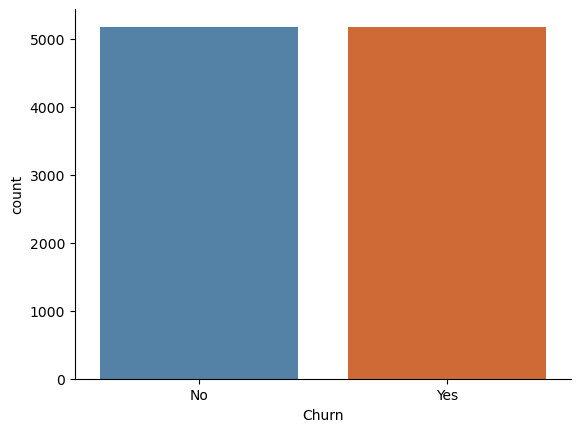

In [382]:
counts = df_artificial.groupby('Churn')['Churn'].value_counts().reset_index()
sns.barplot(data=counts, x='Churn', y='count', hue='Churn', palette=churn_colors)
sns.despine()

In [383]:
counts

Churn  count
0    No   5174
1   Yes   5174

In [384]:
proporcion_yes = int((df_artificial.shape[0] / 2)* proporcion_yes)
proporcion_no = int((df_artificial.shape[0] / 2) * proporcion_no)

In [385]:
proporcion_yes, proporcion_no

(1430, 3743)

In [386]:
df_artificial_yes = df_artificial[df_artificial['Churn'] == 'Yes'].sample(proporcion_yes)
df_artificial_no = df_artificial[df_artificial['Churn'] == 'No'].sample(proporcion_no)

In [387]:
df_artificial = pd.concat([df_artificial_yes, df_artificial_no])
df_artificial

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure  \
5881  99999-AD5881  Female            No     Yes        Yes       1   
2872  99999-AD2872    Male            No      No        Yes       6   
6172  99999-AD6172    Male            No      No         No       2   
3339  99999-AD3339  Female            No     Yes         No       7   
9925  99999-AD9925  Female            No      No         No       1   
...            ...     ...           ...     ...        ...     ...   
5583  99999-AD5583  Female            No     Yes        Yes      46   
2425  99999-AD2425  Female            No     Yes         No      53   
5359  99999-AD5359  Female            No      No         No      10   
1433  99999-AD1433  Female            No     Yes         No      57   
3497  99999-AD3497    Male            No     Yes        Yes      63   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
5881          Yes           Yes     Fiber optic            Yes  ...   
2872          Yes            No     Fiber optic             No  ...   
6172          Yes           Yes     Fiber optic             No  ...   
3339          Yes            No     Fiber optic             No  ...   
9925          Yes            No     Fiber optic             No  ...   
...           ...           ...             ...            ...  ...   
5583          Yes            No              No             No  ...   
2425          Yes            No     Fiber optic             No  ...   
5359           No            No             DSL            Yes  ...   
1433          Yes           Yes     Fiber optic             No  ...   
3497           No            No             DSL             No  ...   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
5881          No         Yes             Yes  Month-to-month              Yes   
2872          No         Yes             Yes  Month-to-month               No   
6172          No          No              No  Month-to-month              Yes   
3339          No         Yes              No  Month-to-month              Yes   
9925          No          No              No  Month-to-month               No   
...          ...         ...             ...             ...              ...   
5583          No          No              No        Two year               No   
2425         Yes         Yes             Yes        One year              Yes   
5359          No          No              No  Month-to-month               No   
1433         Yes         Yes             Yes        One year              Yes   
3497         Yes          No              No        Two year               No   

                  PaymentMethod ChargesDaily ChargesMonthly  ChargesTotal  \
5881           Electronic check     3.420000     102.450000    102.450000   
2872               Mailed check     3.150000      94.500000    575.450000   
6172           Electronic check     2.730000      82.000000    184.650000   
3339           Electronic check     2.700000      81.100000    576.650000   
9925           Electronic check     2.492059      74.756628     74.756628   
...                         ...          ...            ...           ...   
5583    Credit card (automatic)     0.650000      19.400000    958.150000   
2425           Electronic check     3.120000      93.450000   4872.200000   
5359               Mailed check     0.990000      29.750000    301.900000   
1433  Bank transfer (automatic)     3.650000     109.400000   6252.700000   
3497  Bank transfer (automatic)     1.310000      39.350000   2395.050000   

      Churn  
5881    Yes  
2872    Yes  
6172    Yes  
3339    Yes  
9925    Yes  
...     ...  
5583     No  
2425     No  
5359     No  
1433     No  
3497     No  

[5173 rows x 22 columns]

In [388]:
df_artificial['Churn'].value_counts(normalize=True)

Churn
No     0.723565
Yes    0.276435
Name: proportion, dtype: float64

In [389]:
df_artificial.to_json(DATA_PATH / 'datos_artificiales_labeled.json', orient='records')

In [390]:
df_artificial_proba = df_artificial.drop('Churn', axis=1)
df_artificial_proba.to_json(DATA_PATH / 'datos_artificiales_proba.json', orient='records')

In [391]:
with open(CHAMPION_PATH / 'cat_cols.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

In [392]:
num_cols = df_artificial.select_dtypes(include=['float', 'int'], exclude='object').columns.tolist()
num_cols

['Tenure', 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal']

In [393]:
with open(CHAMPION_PATH / 'num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)

#### **Nota**:

Los datos originales también se mantendrán dentro de la carpeta del proyecto por motivos de completitud, ya que fueron obtenidos a partir del URL utilizado en el proyecto anterior.

In [ ]:
URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

df_smote = pd.read_json(URL)
df_smote.to_json(DATA_PATH /'preprocessed_TelecomX_data.json', orient='records')

try:
    URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    outliers.to_json(DATA_PATH / 'clientes_altovalor_abandonan.json', orient='records')
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

## <font color='#ebac3a'>**Pipeline de prueba**</font>

In [395]:
def run_pipeline(file: str, mode: str='production'):

    """
    Función para correr pipeline en producción, el cual puede ser utilizado para predicciones o monitoreo del desempeño del modelo.
    ---------------------------------------------------------------------
    Parámetros:
        file: str
            Recibe URL o nombre del archivo JSON utilizado por el modelo champion para realizar las predicciones
        mode: str
            Modo de ejecutar el pipeline. Recibe dos opciones: 
                'production' -> devuelve [CustomerID, Probabilidad de Churn, Etiqueta Churn] | 
                'monitor' -> devuelve métricas de evaluación del modelo: [Accuracy, Precision, Recall, F1-score]
    ---------------------------------------------------------------------
    Returns:
        Archivo JSON con resultados del modo seleccionado (logs)
        En notebook:
            'production': pandas.core.frame.DataFrame -> DataFrame con las predicciones obtenidas
            'monitor': Dict -> Diccionario con métricas de evaluación obtenidas
    """


    start_time = timer()

    with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'rb') as f:
        one_hot = pickle.load(f)
    
    with open(CHAMPION_PATH / 'target_encoder.pkl', 'rb') as f:
        target_encoder = pickle.load(f)
        
    with open(CHAMPION_PATH / 'champion_model.pkl', 'rb') as f:
        modelo = pickle.load(f)
    
    with open(CHAMPION_PATH / 'columns_order.pkl', 'rb') as f:
       order_cols = pickle.load(f)
    
    with open(CHAMPION_PATH / 'cat_cols.pkl', 'rb') as f:
       cat_cols = pickle.load(f)
    
    with open(CHAMPION_PATH / 'num_cols.pkl', 'rb') as f:
       num_cols = pickle.load(f)
    if 'ChargesDaily' in num_cols:
        num_cols.remove('ChargesDaily')

    data = pd.read_json(file)

    if 'ChargesDaily' in data.columns:
        data.drop('ChargesDaily', axis=1)
    
    log = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    if mode == 'production':
        # Conservar IDs de clientes
        customers_ids = data['CustomerID']
        # Descartar columnas no utilizadas por el modelo
        data = data.drop('CustomerID', axis=1)
        # Codificar variables categoricas
        data = one_hot.transform(data)
        # Generar data frame
        df = pd.DataFrame(data, columns=order_cols)
        # Obtener probabilidad de churn con el modelo champion
        pred_proba = modelo.predict_proba(df)[:, 1]
        # Obtener churn label con el modelo champion
        
        pred_labels = (pred_proba >= 0.39).astype(int)
        # Generar DataFrame con los resultados
        results = pd.DataFrame({'CustomerID': customers_ids,
                                'Probabilidad Churn': np.round(pred_proba, 4),
                                'Churn': pred_labels})
        # Guardar los resultados del modelo en archivo JSON
        results.to_json(PRODUCTION_PATH / f'pipeline_results_{log}.json')
        return results
        
    elif mode == 'monitor':
        # Descartar columnas no utilizadas por el modelo
        data = data.drop('CustomerID', axis=1)
        # Separar labels para evaluación del modelo
        y = data['Churn']
        # Codificar variable respuesta
        y = label_encoder.transform(y).ravel()
        # Preparar datos para realizar predicciones
        data = data.drop('Churn', axis=1)
        # Codificar variables categóricas
        data = one_hot.transform(data)
        # Generar DataFrame
        df = pd.DataFrame(data, columns=order_cols)
        # Obtener predicciones del modelo sin umbral
        y_preds = modelo.predict(df)
        # Obtener métricas de evaluación sin umbral
        metricas = metricas_evaluacion(modelo, df, y, f'Champion_{log}', conjunto='X')
        # Realizar predicciones de probabilidades con el modelo
        y_proba = modelo.predict_proba(df)[:, 1]
        # Obtener predicciones del modelo con umbral
        y_preds_proba = (y_proba >= 0.39).astype(int)
        # Obtener métricas de evaluacion con umbral
        metricas_umbral = metricas_evaluacion(modelo, df, y, f'Champion_{log}', conjunto='X', umbral=0.39)
        # Finalizar timer
        end_time = timer()
        # Guardar tiempo de predicción
        metricas['prediction_time'] = np.round(end_time - start_time)
        metricas_umbral['prediction_time'] = np.round(end_time - start_time)
        # Lista para guardar las metricas
        df_metricas = []
        # Agregar metricas a la lista para generar DataFrame
        df_metricas.append(metricas)
        df_metricas.append(metricas_umbral)
        
        df_metricas = pd.DataFrame(df_metricas)
        df_metricas.to_json(MONITOR_PATH / f'monitor_results_{log}.json')
        return df_metricas
    else:
        raise ValueError('Esta función recibe solo mode = "production" o "monitor"')

In [ ]:
URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/datos_artificiales_proba.json'

run_pipeline(file=URL, mode='production')

CustomerID  Probabilidad Churn  Churn
0        99999-AD0              0.1020      0
1        99999-AD1              0.1641      0
2        99999-AD2              0.2537      0
3        99999-AD3              0.5521      1
4        99999-AD4              0.6612      1
...            ...                 ...    ...
4151  99999-AD4151              0.6357      1
4152  99999-AD4152              0.6725      1
4153  99999-AD4153              0.3894      0
4154  99999-AD4154              0.2422      0
4155  99999-AD4155              0.6073      1

[4156 rows x 3 columns]

In [ ]:
URL = 'https://raw.githubusercontent.com/Ivesqui/Challenge2_TelecomX/refs/heads/main/src/datos_artificiales_labeled.json'

run_pipeline(file=URL, mode='monitor')

Model Dataset  Accuracy  Precision  Recall  F1-score  \
0  Champion_20250730_173753       X    0.8417      0.833  0.8547    0.8437   
1  Champion_20250730_173753       X    0.8270      0.761  0.9533    0.8464   

     AUC  Umbral  prediction_time  
0  0.904    0.50              2.0  
1  0.904    0.39              2.0